<p style="background-color:#808080;"><span style="color:#ffffff;"><i> 
<img src="https://www.kitepackaging.co.uk/images/kite-logo-2021.png" alt="Logo" width="100" height="200">

>>>>#                            **KITE PACKAGING : Customer density and order type clustering**

#

<div style="text-align: center;">
    <img src="https://media.kitepackaging.co.uk/images/content/kite-fleet-6df6ac59-afec-490a-b826-5ccf19a1d715..png?width=2400&optimize=medium" alt="Logo" width="800" height="700">
</div>
'''

<p style="background-color:#808080;"><span style="color:#ffffff;"><i> 
<img src="https://www.kitepackaging.co.uk/images/kite-logo-2021.png" alt="Logo" width="100" height="200">

# Objective
- the objective of this workbook is explore the data and identify possible clusters that could be beneficial for insourcing.
- to group the orders by area so that we can optimise delivery routes by consolidating orders within close proximity.

# 1. Creating merged datasets
 1. Merging other datasets (customers information and order details) with the "orders" dataset.
 2. Merging other datasets (customer information and orders) with the "order details" dataset.

### Import necessary libraries and files

In [1]:
# Import the necessary libraries, packages, and modules.
# Data analysis:
import numpy as np
import pandas as pd
import re

# Visualisation:
import matplotlib.pyplot as plt
import seaborn as sns

# k-means
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

# Visualising a map
#import folium

# Adding additional clusters
#from sklearn.neighbors import KDTree
#from sklearn.neighbors import BallTree

#Creating a model
#import pulp

In [2]:
# Load the CSV file as customers.
customers = pd.read_csv('customers_clean.csv', index_col=0) 

# View the DataFrame.
print(f"The dataset has {customers.shape[0]} rows and {customers.shape[1]} columns.")
customers.head()

The dataset has 23178 rows and 6 columns.


,website_id,delivery_postcode,delivery_country,latitude,longitude,distance_miles
0,245,L39 2,United Kingdom,53.561637,-2.896693,124.359
1,597,PR3 1,United Kingdom,53.867059,-2.719333,143.584
2,739,CV2 2,United Kingdom,52.424559,-1.463448,6.401
3,993,W1W 8,United Kingdom,51.519216,-0.140903,92.912
4,994,LE15 8,United Kingdom,52.656127,-0.702324,55.656


In [3]:
# Load the CSV file as orders.
orders = pd.read_csv('orders_clean.csv', index_col=0) 

# View the DataFrame.
print(f"The dataset has {orders.shape[0]} rows and {orders.shape[1]} columns.")
orders.head()

The dataset has 31004 rows and 15 columns.


,order_id,website_id,order_date,status,status_id,payment_option,payment_type,courier,products_ex_vat,delivery_ex_vat,vat,total,date_despatched,delivery_cost,total_price
0,2729772,971172,2024-06-03,Dispatched,6,Paypal,1,DX Express,26.46,7.37,6.76,40.59,2024-06-03,6.95,33.83
1,2729773,971173,2024-06-03,Dispatched,6,Payment Gateway,2,DX Express,18.80,7.37,5.23,31.40,2024-06-03,6.95,26.17
2,2729774,889210,2024-06-03,Dispatched,6,Payment Gateway,2,DX Freight,351.07,19.99,74.22,445.28,2024-06-03,25.33,371.06
3,2729775,971174,2024-06-03,Dispatched,6,Payment Gateway,2,DX Express,56.14,0.00,11.23,67.37,2024-06-03,6.95,56.14
4,2729776,971175,2024-06-03,Dispatched,6,Paypal,1,DX Freight,144.16,0.00,28.84,173.00,2024-06-03,16.87,144.16


In [4]:
# Load the CSV file as orders_details.
orders_details = pd.read_csv('order_details_clean.csv', index_col=0) 

# View the DataFrame.
print(f"The dataset has {orders_details.shape[0]} rows and {orders_details.shape[1]} columns.")
orders_details.head()

The dataset has 76573 rows and 14 columns.


,order_id,part_number,description,packs,pack_price,units_per_pack,pack_weight,pallet_quantity,cubic_m_per_unit,total_pack_price,total_units,pallet_space,line_weight_recalc,total_cubic_m
0,2729772,BB305X435,Clear bubble bags 305x435mm - pack of 150,1,26.46,150,2.55,2400,0.000925,26.46,150,0.062500,2.55,0.138750
1,2729773,PBL1215,Light duty polythene bags - 11.75x14.75 inches...,1,18.80,1000,4.40,180000,0.000006,18.80,1000,0.005556,4.40,0.006000
2,2729774,CSW222X150X88-BPB6,Brown postal boxes - 222x150x88mm (8.75x6x3.5 ...,1,20.55,50,3.90,2200,0.000726,20.55,50,0.022727,3.90,0.036300
3,2729774,PS320X140X420-BROWN,Twist handle paper carrier bags brown 320x140x...,1,52.28,250,5.00,3750,0.000144,52.28,250,0.066667,5.00,0.036000
4,2729774,TPK048050S,"Paper kraft tape - 48mm x 50m, Solvent - pack ...",3,13.05,6,1.28,2592,0.000677,39.15,18,0.006944,3.84,0.012186


## a) Create a merged orders dataframe


### Merge customers information with orders dataset

In [5]:
# View columns
print(customers.columns)
print(orders.columns)

Index(['website_id', 'delivery_postcode', 'delivery_country', 'latitude',
       'longitude', 'distance_miles'],
      dtype='object')
Index(['order_id', 'website_id', 'order_date', 'status', 'status_id',
       'payment_option', 'payment_type', 'courier', 'products_ex_vat',
       'delivery_ex_vat', 'vat', 'total', 'date_despatched', 'delivery_cost',
       'total_price'],
      dtype='object')


In [6]:
# Select only the necessary columns from customers df for merging.
customers_columns = customers[['website_id', 'delivery_postcode','distance_miles', 'latitude', 'longitude']]

# Merge the DataFrames on 'website_id'.
orders_df1 = pd.merge(orders, customers_columns, on='website_id', how='left')

# View dataframe.
print(orders_df1.info())
orders_df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31004 entries, 0 to 31003
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_id           31004 non-null  int64  
 1   website_id         31004 non-null  int64  
 2   order_date         31004 non-null  object 
 3   status             31004 non-null  object 
 4   status_id          31004 non-null  int64  
 5   payment_option     31004 non-null  object 
 6   payment_type       31004 non-null  int64  
 7   courier            31004 non-null  object 
 8   products_ex_vat    31004 non-null  float64
 9   delivery_ex_vat    31004 non-null  float64
 10  vat                31004 non-null  float64
 11  total              31004 non-null  float64
 12  date_despatched    31004 non-null  object 
 13  delivery_cost      31004 non-null  float64
 14  total_price        31004 non-null  float64
 15  delivery_postcode  30919 non-null  object 
 16  distance_miles     309

,order_id,website_id,order_date,status,status_id,payment_option,payment_type,courier,products_ex_vat,delivery_ex_vat,vat,total,date_despatched,delivery_cost,total_price,delivery_postcode,distance_miles,latitude,longitude
0,2729772,971172,2024-06-03,Dispatched,6,Paypal,1,DX Express,26.46,7.37,6.76,40.59,2024-06-03,6.95,33.83,HU6 9,125.859,53.781069,-0.371417
1,2729773,971173,2024-06-03,Dispatched,6,Payment Gateway,2,DX Express,18.80,7.37,5.23,31.40,2024-06-03,6.95,26.17,SE8 3,111.199,51.482013,-0.029615
2,2729774,889210,2024-06-03,Dispatched,6,Payment Gateway,2,DX Freight,351.07,19.99,74.22,445.28,2024-06-03,25.33,371.06,NG11 7,48.507,52.898976,-1.173471
3,2729775,971174,2024-06-03,Dispatched,6,Payment Gateway,2,DX Express,56.14,0.00,11.23,67.37,2024-06-03,6.95,56.14,G44 5,314.067,55.814208,-4.255686
4,2729776,971175,2024-06-03,Dispatched,6,Paypal,1,DX Freight,144.16,0.00,28.84,173.00,2024-06-03,16.87,144.16,LS24 9,123.908,53.868379,-1.252846


In [7]:
# Check for missing values.
orders_df1.isna().sum()

order_id              0
website_id            0
order_date            0
status                0
status_id             0
payment_option        0
payment_type          0
courier               0
products_ex_vat       0
delivery_ex_vat       0
vat                   0
total                 0
date_despatched       0
delivery_cost         0
total_price           0
delivery_postcode    85
distance_miles       85
latitude             85
longitude            85
dtype: int64

> There are missing values in delivery_postcode, distance_miles, latitude and longitude.\
> Some of the customers were deleted in the customer file during the cleaning phase. Orders with no corresponding customer information will be deleted.

In [8]:
# Remove null values only in specific columns.
orders_df1 = orders_df1.dropna(subset=['delivery_postcode', 'distance_miles']).reset_index(drop=True)

# View Info.
orders_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30919 entries, 0 to 30918
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_id           30919 non-null  int64  
 1   website_id         30919 non-null  int64  
 2   order_date         30919 non-null  object 
 3   status             30919 non-null  object 
 4   status_id          30919 non-null  int64  
 5   payment_option     30919 non-null  object 
 6   payment_type       30919 non-null  int64  
 7   courier            30919 non-null  object 
 8   products_ex_vat    30919 non-null  float64
 9   delivery_ex_vat    30919 non-null  float64
 10  vat                30919 non-null  float64
 11  total              30919 non-null  float64
 12  date_despatched    30919 non-null  object 
 13  delivery_cost      30919 non-null  float64
 14  total_price        30919 non-null  float64
 15  delivery_postcode  30919 non-null  object 
 16  distance_miles     309

In [9]:
# Check for missing values.
orders_df1.isna().sum()

order_id             0
website_id           0
order_date           0
status               0
status_id            0
payment_option       0
payment_type         0
courier              0
products_ex_vat      0
delivery_ex_vat      0
vat                  0
total                0
date_despatched      0
delivery_cost        0
total_price          0
delivery_postcode    0
distance_miles       0
latitude             0
longitude            0
dtype: int64

### Merge orders df (orders_df1) with order details summary totals

In [10]:
# View headings.
print(orders_details.columns)
print(orders_df1.columns)

Index(['order_id', 'part_number', 'description', 'packs', 'pack_price',
       'units_per_pack', 'pack_weight', 'pallet_quantity', 'cubic_m_per_unit',
       'total_pack_price', 'total_units', 'pallet_space', 'line_weight_recalc',
       'total_cubic_m'],
      dtype='object')
Index(['order_id', 'website_id', 'order_date', 'status', 'status_id',
       'payment_option', 'payment_type', 'courier', 'products_ex_vat',
       'delivery_ex_vat', 'vat', 'total', 'date_despatched', 'delivery_cost',
       'total_price', 'delivery_postcode', 'distance_miles', 'latitude',
       'longitude'],
      dtype='object')


In [11]:
# Group the order details by 'order_id' and sum the required columns.
orders_summary = orders_details.groupby('order_id')[['total_cubic_m', 'pallet_space', 'line_weight_recalc']
                                                   ].sum().reset_index()

# Merge the summarised DataFrame (orders_summary) with orders_df1.
orders_df1 = pd.merge(orders_df1, orders_summary, on='order_id', how='left')

# View the DataFrame structure and data.
print(orders_df1.info())
orders_df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30919 entries, 0 to 30918
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            30919 non-null  int64  
 1   website_id          30919 non-null  int64  
 2   order_date          30919 non-null  object 
 3   status              30919 non-null  object 
 4   status_id           30919 non-null  int64  
 5   payment_option      30919 non-null  object 
 6   payment_type        30919 non-null  int64  
 7   courier             30919 non-null  object 
 8   products_ex_vat     30919 non-null  float64
 9   delivery_ex_vat     30919 non-null  float64
 10  vat                 30919 non-null  float64
 11  total               30919 non-null  float64
 12  date_despatched     30919 non-null  object 
 13  delivery_cost       30919 non-null  float64
 14  total_price         30919 non-null  float64
 15  delivery_postcode   30919 non-null  object 
 16  dist

,order_id,website_id,order_date,status,status_id,payment_option,payment_type,courier,products_ex_vat,delivery_ex_vat,...,date_despatched,delivery_cost,total_price,delivery_postcode,distance_miles,latitude,longitude,total_cubic_m,pallet_space,line_weight_recalc
0,2729772,971172,2024-06-03,Dispatched,6,Paypal,1,DX Express,26.46,7.37,...,2024-06-03,6.95,33.83,HU6 9,125.859,53.781069,-0.371417,0.138750,0.062500,2.55
1,2729773,971173,2024-06-03,Dispatched,6,Payment Gateway,2,DX Express,18.80,7.37,...,2024-06-03,6.95,26.17,SE8 3,111.199,51.482013,-0.029615,0.006000,0.005556,4.40
2,2729774,889210,2024-06-03,Dispatched,6,Payment Gateway,2,DX Freight,351.07,19.99,...,2024-06-03,25.33,371.06,NG11 7,48.507,52.898976,-1.173471,0.280986,0.397727,54.28
3,2729775,971174,2024-06-03,Dispatched,6,Payment Gateway,2,DX Express,56.14,0.00,...,2024-06-03,6.95,56.14,G44 5,314.067,55.814208,-4.255686,0.103600,0.111111,6.16
4,2729776,971175,2024-06-03,Dispatched,6,Paypal,1,DX Freight,144.16,0.00,...,2024-06-03,16.87,144.16,LS24 9,123.908,53.868379,-1.252846,0.360400,0.188768,33.71


### Create a dataframe with only necessary columns

In [12]:
#Determining unique values of the categorical variables.
unique_values = orders_df1[['status', 'status_id',
       'payment_option', 'payment_type', 'courier']].apply(lambda x: x.unique())

# Display unique values.
unique_values

status                                                 [Dispatched]
status_id                                                       [6]
payment_option    [Paypal, Payment Gateway, On Account, Cheque, ...
payment_type                                        [1, 2, 3, 0, 4]
courier           [DX Express, DX Freight, MFS, Split, DHLExpres...
dtype: object

In [13]:
# Delete unnessary columns.
orders_df1 = orders_df1.drop(['status', 'status_id',
                              'payment_option', 'payment_type', 'vat', 'total'], axis= 1)

# View Dataframe
orders_df1.head()

,order_id,website_id,order_date,courier,products_ex_vat,delivery_ex_vat,date_despatched,delivery_cost,total_price,delivery_postcode,distance_miles,latitude,longitude,total_cubic_m,pallet_space,line_weight_recalc
0,2729772,971172,2024-06-03,DX Express,26.46,7.37,2024-06-03,6.95,33.83,HU6 9,125.859,53.781069,-0.371417,0.138750,0.062500,2.55
1,2729773,971173,2024-06-03,DX Express,18.80,7.37,2024-06-03,6.95,26.17,SE8 3,111.199,51.482013,-0.029615,0.006000,0.005556,4.40
2,2729774,889210,2024-06-03,DX Freight,351.07,19.99,2024-06-03,25.33,371.06,NG11 7,48.507,52.898976,-1.173471,0.280986,0.397727,54.28
3,2729775,971174,2024-06-03,DX Express,56.14,0.00,2024-06-03,6.95,56.14,G44 5,314.067,55.814208,-4.255686,0.103600,0.111111,6.16
4,2729776,971175,2024-06-03,DX Freight,144.16,0.00,2024-06-03,16.87,144.16,LS24 9,123.908,53.868379,-1.252846,0.360400,0.188768,33.71


In [14]:
# View columns.
orders_df1.columns

Index(['order_id', 'website_id', 'order_date', 'courier', 'products_ex_vat',
       'delivery_ex_vat', 'date_despatched', 'delivery_cost', 'total_price',
       'delivery_postcode', 'distance_miles', 'latitude', 'longitude',
       'total_cubic_m', 'pallet_space', 'line_weight_recalc'],
      dtype='object')

In [15]:
# Re-order the columns for ease of use.
orders_df1 = orders_df1[['order_id', 'website_id', 'order_date', 'date_despatched', 'courier',
                       'products_ex_vat', 'delivery_ex_vat', 'total_price', 'delivery_cost',
                       'total_cubic_m','pallet_space', 'line_weight_recalc',
                       'delivery_postcode', 'distance_miles', 'latitude', 'longitude']]

# View the DataFrame.
print(f"The dataset has {orders_df1.shape[0]} rows and {orders_df1.shape[1]} columns.")
orders_df1.head()

The dataset has 30919 rows and 16 columns.


,order_id,website_id,order_date,date_despatched,courier,products_ex_vat,delivery_ex_vat,total_price,delivery_cost,total_cubic_m,pallet_space,line_weight_recalc,delivery_postcode,distance_miles,latitude,longitude
0,2729772,971172,2024-06-03,2024-06-03,DX Express,26.46,7.37,33.83,6.95,0.138750,0.062500,2.55,HU6 9,125.859,53.781069,-0.371417
1,2729773,971173,2024-06-03,2024-06-03,DX Express,18.80,7.37,26.17,6.95,0.006000,0.005556,4.40,SE8 3,111.199,51.482013,-0.029615
2,2729774,889210,2024-06-03,2024-06-03,DX Freight,351.07,19.99,371.06,25.33,0.280986,0.397727,54.28,NG11 7,48.507,52.898976,-1.173471
3,2729775,971174,2024-06-03,2024-06-03,DX Express,56.14,0.00,56.14,6.95,0.103600,0.111111,6.16,G44 5,314.067,55.814208,-4.255686
4,2729776,971175,2024-06-03,2024-06-03,DX Freight,144.16,0.00,144.16,16.87,0.360400,0.188768,33.71,LS24 9,123.908,53.868379,-1.252846


In [16]:
# Rename delivery and products_ex_vat.
orders_df1 = orders_df1.rename(columns={
    'delivery_ex_vat': 'delivery_price',
    'products_ex_vat': 'products_price'})

# View the DataFrame.
orders_df1.head()

,order_id,website_id,order_date,date_despatched,courier,products_price,delivery_price,total_price,delivery_cost,total_cubic_m,pallet_space,line_weight_recalc,delivery_postcode,distance_miles,latitude,longitude
0,2729772,971172,2024-06-03,2024-06-03,DX Express,26.46,7.37,33.83,6.95,0.138750,0.062500,2.55,HU6 9,125.859,53.781069,-0.371417
1,2729773,971173,2024-06-03,2024-06-03,DX Express,18.80,7.37,26.17,6.95,0.006000,0.005556,4.40,SE8 3,111.199,51.482013,-0.029615
2,2729774,889210,2024-06-03,2024-06-03,DX Freight,351.07,19.99,371.06,25.33,0.280986,0.397727,54.28,NG11 7,48.507,52.898976,-1.173471
3,2729775,971174,2024-06-03,2024-06-03,DX Express,56.14,0.00,56.14,6.95,0.103600,0.111111,6.16,G44 5,314.067,55.814208,-4.255686
4,2729776,971175,2024-06-03,2024-06-03,DX Freight,144.16,0.00,144.16,16.87,0.360400,0.188768,33.71,LS24 9,123.908,53.868379,-1.252846


In [17]:
# Ensure the date columns are in datetime format.
orders_df1['order_date'] = pd.to_datetime(orders_df1['order_date'])
orders_df1['date_despatched'] = pd.to_datetime(orders_df1['date_despatched'])

#View info to check format.
orders_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30919 entries, 0 to 30918
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            30919 non-null  int64         
 1   website_id          30919 non-null  int64         
 2   order_date          30919 non-null  datetime64[ns]
 3   date_despatched     30919 non-null  datetime64[ns]
 4   courier             30919 non-null  object        
 5   products_price      30919 non-null  float64       
 6   delivery_price      30919 non-null  float64       
 7   total_price         30919 non-null  float64       
 8   delivery_cost       30919 non-null  float64       
 9   total_cubic_m       30919 non-null  float64       
 10  pallet_space        30919 non-null  float64       
 11  line_weight_recalc  30919 non-null  float64       
 12  delivery_postcode   30919 non-null  object        
 13  distance_miles      30919 non-null  float64   

In [18]:
# Save DataFrame as csv.
#orders_df1.to_csv('orders_merged_df.csv')

## b) Merged orders details with created orders dataframe (orders_df1)

In [19]:
# View columns.
print(orders_df1.columns)
print(orders_details.columns)

Index(['order_id', 'website_id', 'order_date', 'date_despatched', 'courier',
       'products_price', 'delivery_price', 'total_price', 'delivery_cost',
       'total_cubic_m', 'pallet_space', 'line_weight_recalc',
       'delivery_postcode', 'distance_miles', 'latitude', 'longitude'],
      dtype='object')
Index(['order_id', 'part_number', 'description', 'packs', 'pack_price',
       'units_per_pack', 'pack_weight', 'pallet_quantity', 'cubic_m_per_unit',
       'total_pack_price', 'total_units', 'pallet_space', 'line_weight_recalc',
       'total_cubic_m'],
      dtype='object')


In [20]:
# Select only the necessary columns from orders_df1 for merging.
orders_columns = orders_df1[['order_id','website_id', 'delivery_postcode', 
                             'distance_miles', 'latitude', 'longitude', 'courier']]

# Merge the DataFrames on 'order_id'.
orders_details_df1 = pd.merge(orders_details, orders_columns, on='order_id', how='left')

# View dataframe.
print(orders_details_df1.info())
orders_details_df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76573 entries, 0 to 76572
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            76573 non-null  int64  
 1   part_number         76573 non-null  object 
 2   description         76573 non-null  object 
 3   packs               76573 non-null  int64  
 4   pack_price          76573 non-null  float64
 5   units_per_pack      76573 non-null  int64  
 6   pack_weight         76573 non-null  float64
 7   pallet_quantity     76573 non-null  int64  
 8   cubic_m_per_unit    72449 non-null  float64
 9   total_pack_price    76573 non-null  float64
 10  total_units         76573 non-null  int64  
 11  pallet_space        76573 non-null  float64
 12  line_weight_recalc  76573 non-null  float64
 13  total_cubic_m       72449 non-null  float64
 14  website_id          73885 non-null  float64
 15  delivery_postcode   73885 non-null  object 
 16  dist

,order_id,part_number,description,packs,pack_price,units_per_pack,pack_weight,pallet_quantity,cubic_m_per_unit,total_pack_price,total_units,pallet_space,line_weight_recalc,total_cubic_m,website_id,delivery_postcode,distance_miles,latitude,longitude,courier
0,2729772,BB305X435,Clear bubble bags 305x435mm - pack of 150,1,26.46,150,2.55,2400,0.000925,26.46,150,0.062500,2.55,0.138750,971172.0,HU6 9,125.859,53.781069,-0.371417,DX Express
1,2729773,PBL1215,Light duty polythene bags - 11.75x14.75 inches...,1,18.80,1000,4.40,180000,0.000006,18.80,1000,0.005556,4.40,0.006000,971173.0,SE8 3,111.199,51.482013,-0.029615,DX Express
2,2729774,CSW222X150X88-BPB6,Brown postal boxes - 222x150x88mm (8.75x6x3.5 ...,1,20.55,50,3.90,2200,0.000726,20.55,50,0.022727,3.90,0.036300,889210.0,NG11 7,48.507,52.898976,-1.173471,DX Freight
3,2729774,PS320X140X420-BROWN,Twist handle paper carrier bags brown 320x140x...,1,52.28,250,5.00,3750,0.000144,52.28,250,0.066667,5.00,0.036000,889210.0,NG11 7,48.507,52.898976,-1.173471,DX Freight
4,2729774,TPK048050S,"Paper kraft tape - 48mm x 50m, Solvent - pack ...",3,13.05,6,1.28,2592,0.000677,39.15,18,0.006944,3.84,0.012186,889210.0,NG11 7,48.507,52.898976,-1.173471,DX Freight


In [21]:
# Check for missing values.
orders_details_df1.isna().sum()

order_id                 0
part_number              0
description              0
packs                    0
pack_price               0
units_per_pack           0
pack_weight              0
pallet_quantity          0
cubic_m_per_unit      4124
total_pack_price         0
total_units              0
pallet_space             0
line_weight_recalc       0
total_cubic_m         4124
website_id            2688
delivery_postcode     2688
distance_miles        2688
latitude              2688
longitude             2688
courier               2688
dtype: int64

>**Observation:** \
> There are missing values in the data brought in.\
> Some of the customers were deleted in the customer file/ merged orders file during the cleaning phase.\
Orders details with no corresponding customer information will be deleted.

In [22]:
# Delete rows with null values in specified columns.
columns_to_check = ['website_id', 'delivery_postcode', 'distance_miles', 'latitude', 'longitude', 'courier']
orders_details_df1 = orders_details_df1.dropna(subset=columns_to_check)

# Reset the index.
orders_details_df1.reset_index(drop=True, inplace=True)

In [23]:
# Check for missing values.
orders_details_df1.isna().sum()

order_id                 0
part_number              0
description              0
packs                    0
pack_price               0
units_per_pack           0
pack_weight              0
pallet_quantity          0
cubic_m_per_unit      3955
total_pack_price         0
total_units              0
pallet_space             0
line_weight_recalc       0
total_cubic_m         3955
website_id               0
delivery_postcode        0
distance_miles           0
latitude                 0
longitude                0
courier                  0
dtype: int64

In [24]:
# Save DataFrame as csv.
# orders_details_df1.to_csv('orders_details_merged_df.csv')

## c) Check that the 2 new dataframes are using the same sample

In [25]:
# View columns
print(orders_df1.columns)
print(orders_details_df1.columns)

Index(['order_id', 'website_id', 'order_date', 'date_despatched', 'courier',
       'products_price', 'delivery_price', 'total_price', 'delivery_cost',
       'total_cubic_m', 'pallet_space', 'line_weight_recalc',
       'delivery_postcode', 'distance_miles', 'latitude', 'longitude'],
      dtype='object')
Index(['order_id', 'part_number', 'description', 'packs', 'pack_price',
       'units_per_pack', 'pack_weight', 'pallet_quantity', 'cubic_m_per_unit',
       'total_pack_price', 'total_units', 'pallet_space', 'line_weight_recalc',
       'total_cubic_m', 'website_id', 'delivery_postcode', 'distance_miles',
       'latitude', 'longitude', 'courier'],
      dtype='object')


In [26]:
# Check that totals agree to make sure that I have the same dataset population:
# Specify the columns you want to compare
columns_to_check = ['total_cubic_m', 'pallet_space', 'line_weight_recalc']

# Calculate the sum of each column in orders_details_df1.
orders_details_totals = orders_details_df1[columns_to_check].sum()

# Calculate the sum of each column in orders_df1.
orders_totals = orders_df1[columns_to_check].sum()

# Compare the totals.
comparison = orders_details_totals == orders_totals

# Display the comparison results.
print("Column Totals Match for Each Column:")
print(comparison)

# Display the mismatched columns:
mismatched_columns = comparison[comparison == False]
if not mismatched_columns.empty:
    print("\nMismatched Columns:")
    print(mismatched_columns)
else:
    print("\nAll columns match.")


# Calculate the differences.
differences = orders_details_totals - orders_totals

# Show only the columns where totals differ.
print("\nDifferences in Totals for Mismatched Columns:")
print(differences[differences != 0])

Column Totals Match for Each Column:
total_cubic_m          True
pallet_space          False
line_weight_recalc    False
dtype: bool

Mismatched Columns:
pallet_space          False
line_weight_recalc    False
dtype: bool

Differences in Totals for Mismatched Columns:
pallet_space          1.818989e-12
line_weight_recalc   -2.328306e-10
dtype: float64


>**Observation:** \
Immaterial- delta is likey due to rounding.

# 2. Explore the orders dataset

## a) Orders dataframe (orders_df1)

In [27]:
# Basic descriptive statistics.
orders_df1[['total_price', 'delivery_cost', 'total_cubic_m',
            'pallet_space','line_weight_recalc']].describe()

,total_price,delivery_cost,total_cubic_m,pallet_space,line_weight_recalc
count,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000
mean,196.187372,23.951654,0.598607,0.434710,67.031934
std,313.354177,37.877780,1.455994,1.695101,140.531192
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,52.920000,6.890000,0.053149,0.045833,11.240000
50%,103.800000,11.470000,0.173120,0.133333,25.060000
75%,217.875000,29.510000,0.578438,0.428571,63.000000
max,7790.000000,1565.880000,107.163000,250.000000,3067.200000


<Figure size 800x600 with 0 Axes>

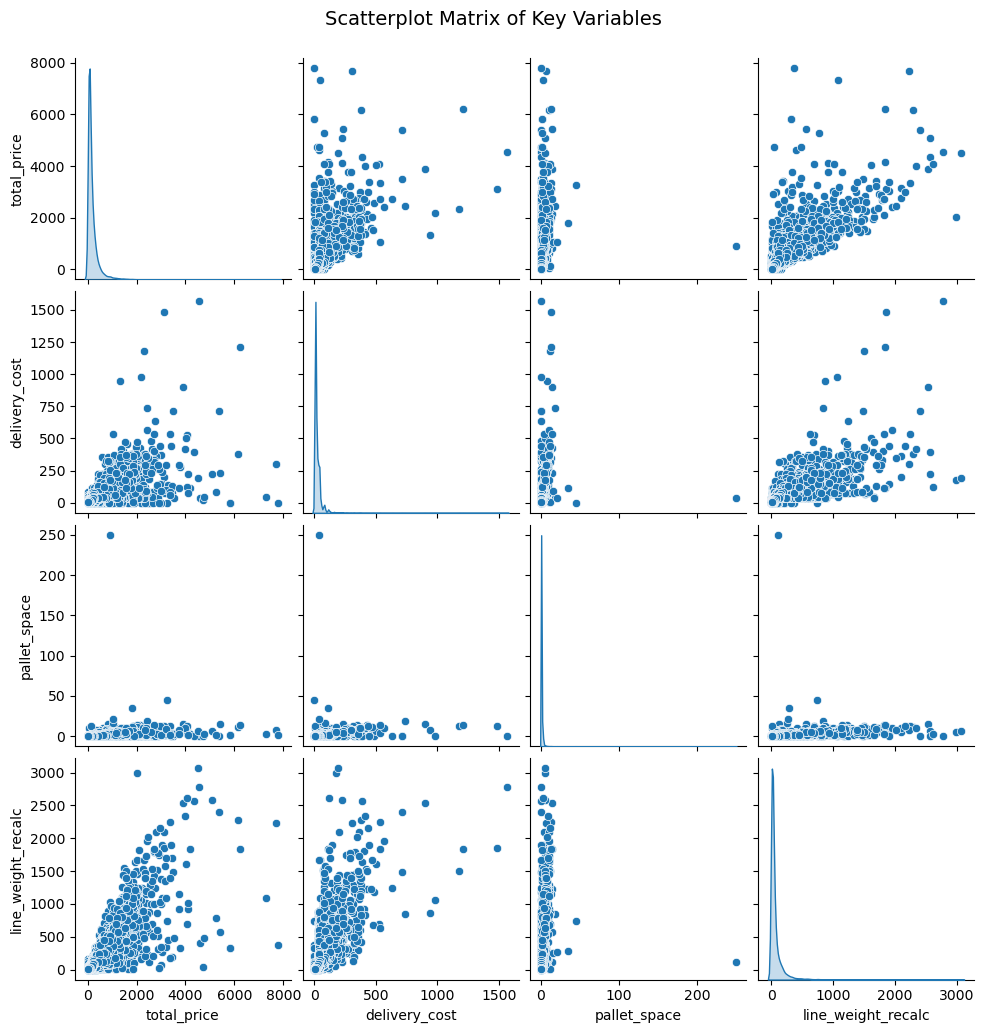

In [28]:
#Set the figure size to make the plot bigger
plt.figure(figsize=(8, 6))

# Create scatterplot with Seaborn
sns.pairplot(orders_df1, 
             x_vars=['total_price','delivery_cost', 'pallet_space', 'line_weight_recalc'],
             y_vars=['total_price','delivery_cost', 'pallet_space', 'line_weight_recalc'],
             diag_kind='kde'
            )

# Add a title to the entire figure.
plt.suptitle('Scatterplot Matrix of Key Variables', 
             fontsize=14, 
             y=1.03)  

# Show the plot
plt.show()

In [29]:
#View correlation table
orders_df1[['total_price', 'delivery_cost', 'pallet_space', 'line_weight_recalc']].corr()

,total_price,delivery_cost,pallet_space,line_weight_recalc
total_price,1.000000,0.689330,0.354246,0.835452
delivery_cost,0.689330,1.000000,0.389039,0.780994
pallet_space,0.354246,0.389039,1.000000,0.364331
line_weight_recalc,0.835452,0.780994,0.364331,1.000000


>**Observation:** \
> Delivery cost and Price are not strongly correlated with Pallet Space, this could be an indicator of a key variable that should be investigated for insourcing as it suggested that it captures different aspects of logistic costs.\
> Line weight has a strong posistive correlation with Delivery cost and total price.\
> Cubic m had lots of missing values and so will not be used.

## b) Orders by order date and dispatch day.

In [30]:
# Create metrics.
# Group by order_date to get daily metrics
daily_orders = orders_df1.groupby('order_date').size()
daily_revenue = orders_df1.groupby('order_date')['total_price'].sum()
daily_cost = orders_df1.groupby('order_date')['delivery_cost'].sum()
daily_cubic_m = orders_df1.groupby('order_date')['total_cubic_m'].sum()
daily_pallet_space = orders_df1.groupby('order_date')['pallet_space'].sum()
daily_weight = orders_df1.groupby('order_date')['line_weight_recalc'].sum()

# Group by date_despatched to get daily dispatched metrics
daily_orders_dispatch = orders_df1.groupby('date_despatched').size()
daily_revenue_dispatch = orders_df1.groupby('date_despatched')['total_price'].sum()
daily_cost_dispatch = orders_df1.groupby('date_despatched')['delivery_cost'].sum()
daily_cubic_m_dispatch = orders_df1.groupby('date_despatched')['total_cubic_m'].sum()
daily_pallet_space_dispatch = orders_df1.groupby('date_despatched')['pallet_space'].sum()
daily_weight_dispatch = orders_df1.groupby('date_despatched')['line_weight_recalc'].sum()

### Compare order date with dispatch date.

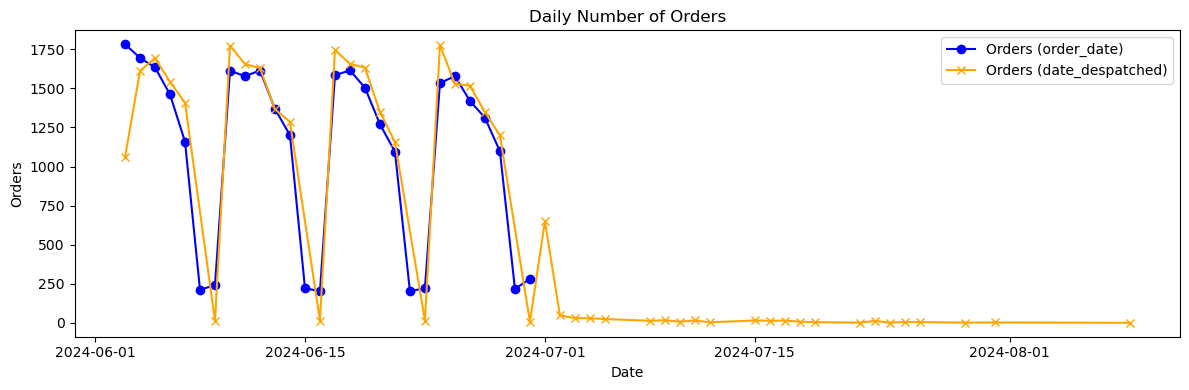

In [31]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 4))  # Adjusted to create only one plot

# Plot 1: Number of orders per day
ax.plot(daily_orders.index, daily_orders.values, marker='o', color='b', label='Orders (order_date)')
ax.plot(daily_orders_dispatch.index, daily_orders_dispatch.values, marker='x', color='orange', label='Orders (date_despatched)')
ax.set_title('Daily Number of Orders')
ax.set_xlabel('Date')
ax.set_ylabel('Orders')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

>**Observation:** \
> Order date and Delivery date largely move in line, however there is a delay.\
> For analysis we will use dispatch date and limit it to June.\
> Noted that the beginning of June will be a bit light as it won't show dispatches flowing through from May.\
> There seems to be a trend where the dispatches and orders dip, possibly linked to day of the week.

## c) Visualise for day of the week.

  Day of the Week  Number of Orders
0          Monday            7039.0
1         Tuesday            6544.0
2       Wednesday            6532.0
3        Thursday            5665.0
4          Friday            5089.0
5        Saturday               NaN
6          Sunday              50.0


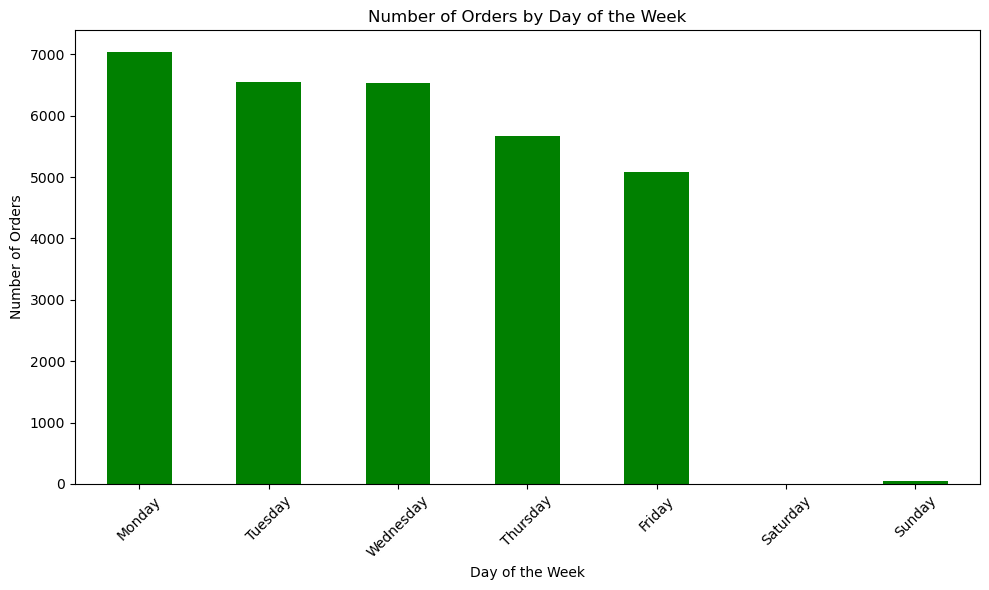

In [32]:
# Extract the day of the week from 'order_date'
orders_df1['day_of_week'] = orders_df1['date_despatched'].dt.day_name()

# Group by day of the week and count the number of orders
orders_per_day = orders_df1.groupby('day_of_week').size()

# Sort the days of the week for better readability
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
orders_per_day = orders_per_day.reindex(days_order)

# Plotting the number of orders per day of the week
plt.figure(figsize=(10, 6))
orders_per_day.plot(kind='bar', color='green')
plt.title('Number of Orders by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()

# Convert the series to a DataFrame
orders_per_day_df = orders_per_day.reset_index()
orders_per_day_df.columns = ['Day of the Week', 'Number of Orders']

# Print the DataFrame
print(orders_per_day_df)

>**Observation:** \
> Limited orders dispatched on weekends. When running the route optimisier, we will review whether we will run deliveries on weekends or if we use external couriers.

## d) Create a dataframe that consists of dispatches in June.

In [33]:
# Create a dataframe that looks at June dispatches only.
dispatch_june = orders_df1[orders_df1['date_despatched'].dt.month == 6]

# View dataframe.
dispatch_june.head()

# View the DataFrame.
print(f"The dataset has {dispatch_june.shape[0]} rows and {dispatch_june.shape[1]} columns.")
dispatch_june.head()

The dataset has 29982 rows and 17 columns.


,order_id,website_id,order_date,date_despatched,courier,products_price,delivery_price,total_price,delivery_cost,total_cubic_m,pallet_space,line_weight_recalc,delivery_postcode,distance_miles,latitude,longitude,day_of_week
0,2729772,971172,2024-06-03,2024-06-03,DX Express,26.46,7.37,33.83,6.95,0.138750,0.062500,2.55,HU6 9,125.859,53.781069,-0.371417,Monday
1,2729773,971173,2024-06-03,2024-06-03,DX Express,18.80,7.37,26.17,6.95,0.006000,0.005556,4.40,SE8 3,111.199,51.482013,-0.029615,Monday
2,2729774,889210,2024-06-03,2024-06-03,DX Freight,351.07,19.99,371.06,25.33,0.280986,0.397727,54.28,NG11 7,48.507,52.898976,-1.173471,Monday
3,2729775,971174,2024-06-03,2024-06-03,DX Express,56.14,0.00,56.14,6.95,0.103600,0.111111,6.16,G44 5,314.067,55.814208,-4.255686,Monday
4,2729776,971175,2024-06-03,2024-06-03,DX Freight,144.16,0.00,144.16,16.87,0.360400,0.188768,33.71,LS24 9,123.908,53.868379,-1.252846,Monday


In [34]:
#View correlation table
dispatch_june[['products_price', 'delivery_price','total_price', 'delivery_cost',
               'total_cubic_m', 'pallet_space', 'line_weight_recalc']].corr()

,products_price,delivery_price,total_price,delivery_cost,total_cubic_m,pallet_space,line_weight_recalc
products_price,1.000000,0.103546,0.999288,0.710934,0.626647,0.369073,0.854177
delivery_price,0.103546,1.000000,0.141007,0.222128,0.059989,0.048362,0.089795
total_price,0.999288,0.141007,1.000000,0.716063,0.626015,0.369195,0.853619
delivery_cost,0.710934,0.222128,0.716063,1.000000,0.630448,0.405579,0.778518
total_cubic_m,0.626647,0.059989,0.626015,0.630448,1.000000,0.486170,0.623330
pallet_space,0.369073,0.048362,0.369195,0.405579,0.486170,1.000000,0.369951
line_weight_recalc,0.854177,0.089795,0.853619,0.778518,0.623330,0.369951,1.000000


## e) Review metrics by courier

In [35]:
# Group by per courier based on dispatch day.
# Key metrics on the full dataset
print("\n=== Key Metrics on Full Dataset ===")
courier_dispatches_full = dispatch_june.groupby('courier').agg(
    order_count=('date_despatched', 'count'),
    price=('total_price', 'sum'),
    delivery_cost=('delivery_cost', 'sum'),
    pallet_space=('pallet_space', 'sum'),
    cost_pc_of_price=('delivery_cost', lambda x: round(
        (x.sum() / dispatch_june.loc[x.index, 'total_price'].sum()) * 100, 2)
    ),
    rev_per_pallet=('total_price', lambda x: round(
        x.sum() / dispatch_june.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    cost_per_pallet=('delivery_cost', lambda x: round(
        x.sum() / dispatch_june.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    rev_per_order=('total_price', lambda x: round(
        x.sum() / dispatch_june.loc[x.index, 'date_despatched'].count(), 2)
    )
)

# Format all numeric columns with a thousand separator and two decimal places
formatted_courier_dispatches_full = courier_dispatches_full.applymap(
    lambda x: "{:,.2f}".format(x) if isinstance(x, (int, float)) else x)

# Display the formatted DataFrame
print(formatted_courier_dispatches_full)


# Key metrics on orders smaller than or equal to 100 miles.
print("\n=== Key Metrics on orders within 100 miles ===")
courier_dispatches_100m = dispatch_june[dispatch_june['distance_miles'] <= 100].groupby('courier').agg(
    order_count=('date_despatched', 'count'),
    price=('total_price', 'sum'),
    delivery_cost=('delivery_cost', 'sum'),
    pallet_space=('pallet_space', 'sum'),
    cost_pc_of_price=('delivery_cost', lambda x: round(
        (x.sum() / dispatch_june.loc[x.index, 'total_price'].sum()) * 100, 2)
    ),
    rev_per_pallet=('total_price', lambda x: round(
        x.sum() / dispatch_june.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    cost_per_pallet=('delivery_cost', lambda x: round(
        x.sum() / dispatch_june.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    rev_per_order=('total_price', lambda x: round(
        x.sum() / dispatch_june.loc[x.index, 'date_despatched'].count(), 2)
    )
)
# Format all numeric columns with a thousand separator and two decimal places
formatted_courier_dispatches_100m = courier_dispatches_100m.applymap(
    lambda x: "{:,.2f}".format(x) if isinstance(x, (int, float)) else x)

# Display the formatted DataFrame
print(formatted_courier_dispatches_100m)


# Key metrics on orders smaller than or equal to 50 miles.
print("\n=== Key Metrics on orders within 50 miles ===")
courier_dispatches_50m = dispatch_june[dispatch_june['distance_miles'] <= 50].groupby('courier').agg(
    order_count=('date_despatched', 'count'),
    price=('total_price', 'sum'),
    delivery_cost=('delivery_cost', 'sum'),
    pallet_space=('pallet_space', 'sum'),
    cost_pc_of_price=('delivery_cost', lambda x: round(
        (x.sum() / dispatch_june.loc[x.index, 'total_price'].sum()) * 100, 2)
    ),
    rev_per_pallet=('total_price', lambda x: round(
        x.sum() / dispatch_june.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    cost_per_pallet=('delivery_cost', lambda x: round(
        x.sum() / dispatch_june.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    rev_per_order=('total_price', lambda x: round(
        x.sum() / dispatch_june.loc[x.index, 'date_despatched'].count(), 2)
    )
)

# Format all numeric columns with a thousand separator and two decimal places.
formatted_courier_dispatches_50m = courier_dispatches_50m.applymap(
    lambda x: "{:,.2f}".format(x) if isinstance(x, (int, float)) else x)

# Display the formatted DataFrame
print(formatted_courier_dispatches_50m)


# Key metrics on orders smaller than or equal to 25 miles.
print("\n=== Key Metrics on orders within 25 miles ===")
courier_dispatches_25m = dispatch_june[dispatch_june['distance_miles'] <= 25].groupby('courier').agg(
   order_count=('date_despatched', 'count'),
    price=('total_price', 'sum'),
    delivery_cost=('delivery_cost', 'sum'),
    pallet_space=('pallet_space', 'sum'),
    cost_pc_of_price=('delivery_cost', lambda x: round(
        (x.sum() / dispatch_june.loc[x.index, 'total_price'].sum()) * 100, 2)
    ),
    rev_per_pallet=('total_price', lambda x: round(
        x.sum() / dispatch_june.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    cost_per_pallet=('delivery_cost', lambda x: round(
        x.sum() / dispatch_june.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    rev_per_order=('total_price', lambda x: round(
        x.sum() / dispatch_june.loc[x.index, 'date_despatched'].count(), 2)
    )
)

# Format all numeric columns with a thousand separator and two decimal places.
formatted_courier_dispatches_25m = courier_dispatches_25m.applymap(
    lambda x: "{:,.2f}".format(x) if isinstance(x, (int, float)) else x)

# Display the formatted DataFrame
print(formatted_courier_dispatches_25m)


=== Key Metrics on Full Dataset ===
           order_count         price delivery_cost pallet_space  \
courier                                                           
DHLExpress    1,242.00     14,105.67      7,797.56         5.47   
DX Express   11,976.00    848,344.51     90,975.36       763.92   
DX Freight   11,475.00  1,919,530.29    249,359.90     4,905.53   
Direct           52.00     35,347.56          0.00        59.36   
MFS           4,861.00  2,699,015.63    335,596.42     6,410.51   
Split           376.00    269,427.48     34,439.00       969.90   

           cost_pc_of_price rev_per_pallet cost_per_pallet rev_per_order  
courier                                                                   
DHLExpress            55.28       2,578.52        1,425.39         11.36  
DX Express            10.72       1,110.52          119.09         70.84  
DX Freight            12.99         391.30           50.83        167.28  
Direct                 0.00         595.50         

>**Observation:** \
> There are orders that Kite already delivers (direct). We will exclude these.\
> **Express** orders appear to be high volume for the revenue it contributes to and low pallet space.\
> **MFS** appears to be lower volume, but significant revenue contribution and high pallet usage. These appear to be your big orders.\
> **DX Freight** - second largest courier. Delivers similar volumes to Express but contributes significantly more to revenue and costs.\

In [36]:
# Create a new DataFrame that excludes rows with 'courier' as 'direct' as this is already delivered by Kite.
orders_df2 = dispatch_june[dispatch_june['courier'] != 'Direct']

# View the DataFrame.
print(f"The dataset has {orders_df2.shape[0]} rows and {orders_df2.shape[1]} columns.")
orders_df2.head()

The dataset has 29930 rows and 17 columns.


,order_id,website_id,order_date,date_despatched,courier,products_price,delivery_price,total_price,delivery_cost,total_cubic_m,pallet_space,line_weight_recalc,delivery_postcode,distance_miles,latitude,longitude,day_of_week
0,2729772,971172,2024-06-03,2024-06-03,DX Express,26.46,7.37,33.83,6.95,0.138750,0.062500,2.55,HU6 9,125.859,53.781069,-0.371417,Monday
1,2729773,971173,2024-06-03,2024-06-03,DX Express,18.80,7.37,26.17,6.95,0.006000,0.005556,4.40,SE8 3,111.199,51.482013,-0.029615,Monday
2,2729774,889210,2024-06-03,2024-06-03,DX Freight,351.07,19.99,371.06,25.33,0.280986,0.397727,54.28,NG11 7,48.507,52.898976,-1.173471,Monday
3,2729775,971174,2024-06-03,2024-06-03,DX Express,56.14,0.00,56.14,6.95,0.103600,0.111111,6.16,G44 5,314.067,55.814208,-4.255686,Monday
4,2729776,971175,2024-06-03,2024-06-03,DX Freight,144.16,0.00,144.16,16.87,0.360400,0.188768,33.71,LS24 9,123.908,53.868379,-1.252846,Monday


In [37]:
#Determining unique values of the categorical variables.
unique_values = orders_df2[['courier']].apply(lambda x: x.unique())

# Display unique values.
unique_values

,courier
0,DX Express
1,DX Freight
2,MFS
3,Split
4,DHLExpress


In [38]:
# Assigned the dataframe.
df = orders_df2

# Group by per courier based on dispatch day.
# Key metrics on the full dataset.
print("\n=== Key Metrics on Full Dataset ===")
courier_dispatches_full = df.groupby('courier').agg(
    order_count=('date_despatched', 'count'),
    price=('total_price', 'sum'),
    delivery_cost=('delivery_cost', 'sum'),
    pallet_space=('pallet_space', 'sum'),
    cost_pc_of_price=('delivery_cost', lambda x: round(
        (x.sum() / df.loc[x.index, 'total_price'].sum()) * 100, 2)
    ),
    rev_per_pallet=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    cost_per_pallet=('delivery_cost', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    rev_per_order=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'date_despatched'].count(), 2)
    )
)

# Format all numeric columns with a thousand separator and two decimal places
formatted_courier_dispatches_full = courier_dispatches_full.applymap(
    lambda x: "{:,.2f}".format(x) if isinstance(x, (int, float)) else x)

# Display the formatted DataFrame
print(formatted_courier_dispatches_full)


# Key metrics on orders smaller than or equal to 100 miles.
print("\n=== Key Metrics on orders within 100 miles ===")
courier_dispatches_100m = df[df['distance_miles'] <= 100].groupby('courier').agg(
    order_count=('date_despatched', 'count'),
    price=('total_price', 'sum'),
    delivery_cost=('delivery_cost', 'sum'),
    pallet_space=('pallet_space', 'sum'),
    cost_pc_of_price=('delivery_cost', lambda x: round(
        (x.sum() / df.loc[x.index, 'total_price'].sum()) * 100, 2)
    ),
    rev_per_pallet=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    cost_per_pallet=('delivery_cost', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    rev_per_order=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'date_despatched'].count(), 2)
    )
)
# Format all numeric columns with a thousand separator and two decimal places
formatted_courier_dispatches_100m = courier_dispatches_100m.applymap(
    lambda x: "{:,.2f}".format(x) if isinstance(x, (int, float)) else x)

# Display the formatted DataFrame
print(formatted_courier_dispatches_100m)


# Key metrics on orders smaller than or equal to 50 miles.
print("\n=== Key Metrics on orders within 50 miles ===")
courier_dispatches_50m = df[df['distance_miles'] <= 50].groupby('courier').agg(
    order_count=('date_despatched', 'count'),
    price=('total_price', 'sum'),
    delivery_cost=('delivery_cost', 'sum'),
    pallet_space=('pallet_space', 'sum'),
    cost_pc_of_price=('delivery_cost', lambda x: round(
        (x.sum() / df.loc[x.index, 'total_price'].sum()) * 100, 2)
    ),
    rev_per_pallet=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    cost_per_pallet=('delivery_cost', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    rev_per_order=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'date_despatched'].count(), 2)
    )
)

# Format all numeric columns with a thousand separator and two decimal places.
formatted_courier_dispatches_50m = courier_dispatches_50m.applymap(
    lambda x: "{:,.2f}".format(x) if isinstance(x, (int, float)) else x)

# Display the formatted DataFrame
print(formatted_courier_dispatches_50m)


# Key metrics on orders smaller than or equal to 25 miles.
print("\n=== Key Metrics on orders within 25 miles ===")
courier_dispatches_25m = df[df['distance_miles'] <= 25].groupby('courier').agg(
   order_count=('date_despatched', 'count'),
    price=('total_price', 'sum'),
    delivery_cost=('delivery_cost', 'sum'),
    pallet_space=('pallet_space', 'sum'),
    cost_pc_of_price=('delivery_cost', lambda x: round(
        (x.sum() / df.loc[x.index, 'total_price'].sum()) * 100, 2)
    ),
    rev_per_pallet=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    cost_per_pallet=('delivery_cost', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    rev_per_order=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'date_despatched'].count(), 2)
    )
)

# Format all numeric columns with a thousand separator and two decimal places.
formatted_courier_dispatches_25m = courier_dispatches_25m.applymap(
    lambda x: "{:,.2f}".format(x) if isinstance(x, (int, float)) else x)

# Display the formatted DataFrame
print(formatted_courier_dispatches_25m)


=== Key Metrics on Full Dataset ===
           order_count         price delivery_cost pallet_space  \
courier                                                           
DHLExpress    1,242.00     14,105.67      7,797.56         5.47   
DX Express   11,976.00    848,344.51     90,975.36       763.92   
DX Freight   11,475.00  1,919,530.29    249,359.90     4,905.53   
MFS           4,861.00  2,699,015.63    335,596.42     6,410.51   
Split           376.00    269,427.48     34,439.00       969.90   

           cost_pc_of_price rev_per_pallet cost_per_pallet rev_per_order  
courier                                                                   
DHLExpress            55.28       2,578.52        1,425.39         11.36  
DX Express            10.72       1,110.52          119.09         70.84  
DX Freight            12.99         391.30           50.83        167.28  
MFS                   12.43         421.03           52.35        555.24  
Split                 12.78         277.79 

## f) Investigate data within 50 miles radius
- Kite indicated that 50 miles is the radius that they believe could be benefical. We will investigate the 50 miles radius primarly.
- we will then see if 25 miles or 100 miles would work based on analysis done on 50 miles.

In [39]:
# Create a df for 50 miles only.
orders_50m = orders_df2[orders_df2['distance_miles'] <= 50].reset_index(drop=True)

#View dateframe
print(f"The dataset has {orders_50m.shape[0]} rows and {orders_50m.shape[1]} columns.")
orders_50m.head()

The dataset has 4018 rows and 17 columns.


,order_id,website_id,order_date,date_despatched,courier,products_price,delivery_price,total_price,delivery_cost,total_cubic_m,pallet_space,line_weight_recalc,delivery_postcode,distance_miles,latitude,longitude,day_of_week
0,2729774,889210,2024-06-03,2024-06-03,DX Freight,351.07,19.99,371.06,25.33,0.280986,0.397727,54.28,NG11 7,48.507,52.898976,-1.173471,Monday
1,2729788,784153,2024-06-03,2024-06-03,DX Freight,146.70,0.00,146.70,22.51,0.270000,0.277778,48.00,CV22 7,10.594,52.358672,-1.277863,Monday
2,2729796,896445,2024-06-03,2024-06-03,DX Freight,127.69,0.00,127.69,14.45,0.857425,0.448908,27.02,LE8 9,29.936,52.554763,-1.094327,Monday
3,2729807,885272,2024-06-03,2024-06-03,MFS,285.11,0.00,285.11,40.39,0.608900,0.413009,138.00,OX16 5,32.482,52.062262,-1.342841,Monday
4,2729809,843804,2024-06-03,2024-06-03,MFS,365.72,0.00,365.72,34.58,1.276950,0.938889,179.70,CV6 7,4.969,52.434320,-1.507344,Monday


<Figure size 800x600 with 0 Axes>

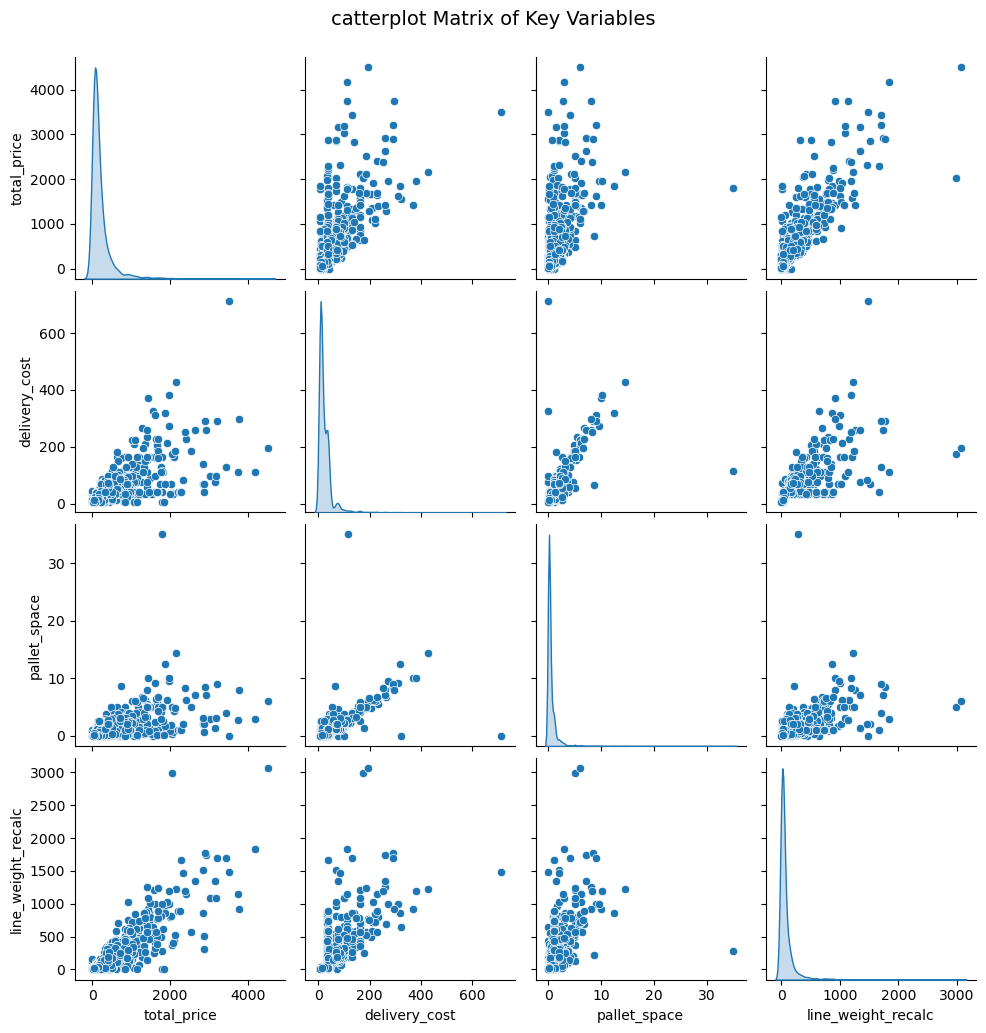

In [40]:
#Set the figure size to make the plot bigger
plt.figure(figsize=(8, 6))

# Create scatterplot with Seaborn.
sns.pairplot(orders_50m, 
             x_vars=['total_price','delivery_cost', 'pallet_space', 'line_weight_recalc'],
             y_vars=['total_price','delivery_cost', 'pallet_space', 'line_weight_recalc'],
             diag_kind='kde'
            )

# Add a title to the entire figure.
plt.suptitle('catterplot Matrix of Key Variables', 
             fontsize=14, 
             y=1.03)  

# Show the plot
plt.show()

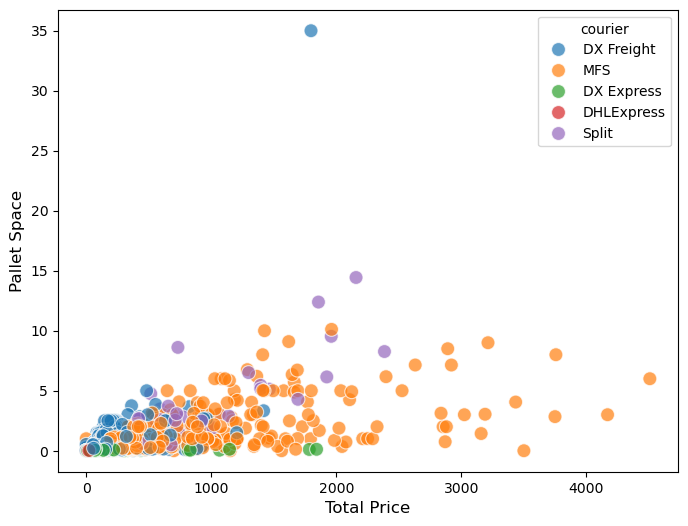

In [41]:
#Set the figure size to make the plot bigger
plt.figure(figsize=(8, 6))

#Determine dataframe
df = orders_50m

# Create scatterplot with Seaborn
sns.scatterplot(x='total_price', 
                y='pallet_space', 
                data=df,
                hue='courier', 
                s=100,   
                alpha=0.7,
               ) 

# Add titles and labels.
plt.title('', fontsize=16)
plt.xlabel('Total Price', fontsize=12)
plt.ylabel('Pallet Space', fontsize=12)

# Show the plot
plt.show()

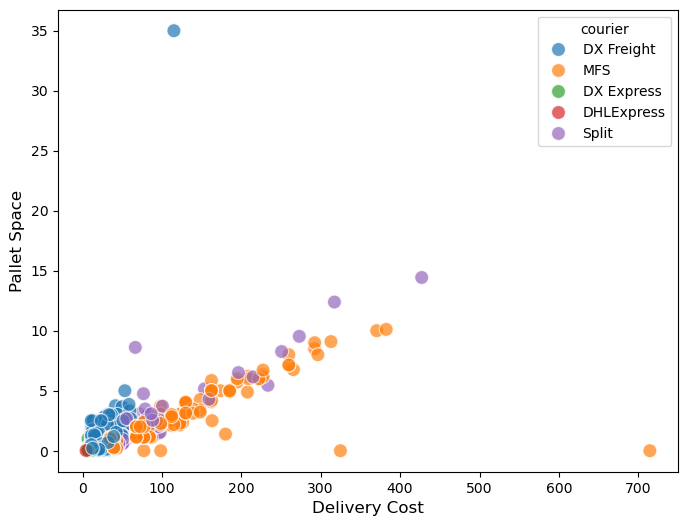

In [42]:
#Set the figure size to make the plot bigger
plt.figure(figsize=(8, 6))

# Create scatterplot with Seaborn
sns.scatterplot(x='delivery_cost', 
                y='pallet_space', 
                data=orders_50m,
                hue='courier', 
                s=100,   
                alpha=0.7,
               ) 

# Add titles and labels.
plt.title('', fontsize=16)
plt.xlabel('Delivery Cost', fontsize=12)
plt.ylabel('Pallet Space', fontsize=12)

# Show the plot
plt.show()

In [43]:
# Save DataFrame as csv.
#orders_50m.to_csv('orders_50m.csv')

In [44]:
orders_50m.columns

Index(['order_id', 'website_id', 'order_date', 'date_despatched', 'courier',
       'products_price', 'delivery_price', 'total_price', 'delivery_cost',
       'total_cubic_m', 'pallet_space', 'line_weight_recalc',
       'delivery_postcode', 'distance_miles', 'latitude', 'longitude',
       'day_of_week'],
      dtype='object')

# 3. Clustering using delivery cost and pallet
- the idea is that we can identify clusters  where the cost per pallet is high. 
- This would suggest these orders may be disproportionately expensive relative to the space they occupy, making them potentially good candidates for testing insourcing
- we also need to find a cluster that covers enough of the revenue/ cost base balancing pallet capacity and number of orders per day.


## a) Cluster based on cost and pallet (K-means clustering)

In [45]:
# Make a copy of the full df in case I need to revert back.
df_cost_pallet = orders_50m.copy()

# View df
df_cost_pallet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            4018 non-null   int64         
 1   website_id          4018 non-null   int64         
 2   order_date          4018 non-null   datetime64[ns]
 3   date_despatched     4018 non-null   datetime64[ns]
 4   courier             4018 non-null   object        
 5   products_price      4018 non-null   float64       
 6   delivery_price      4018 non-null   float64       
 7   total_price         4018 non-null   float64       
 8   delivery_cost       4018 non-null   float64       
 9   total_cubic_m       4018 non-null   float64       
 10  pallet_space        4018 non-null   float64       
 11  line_weight_recalc  4018 non-null   float64       
 12  delivery_postcode   4018 non-null   object        
 13  distance_miles      4018 non-null   float64     

In [46]:
# Keep only necessary columns.
cluster_cost_pallet = df_cost_pallet[['delivery_cost', 'pallet_space']]

#View DataFrame.
cluster_cost_pallet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   delivery_cost  4018 non-null   float64
 1   pallet_space   4018 non-null   float64
dtypes: float64(2)
memory usage: 62.9 KB


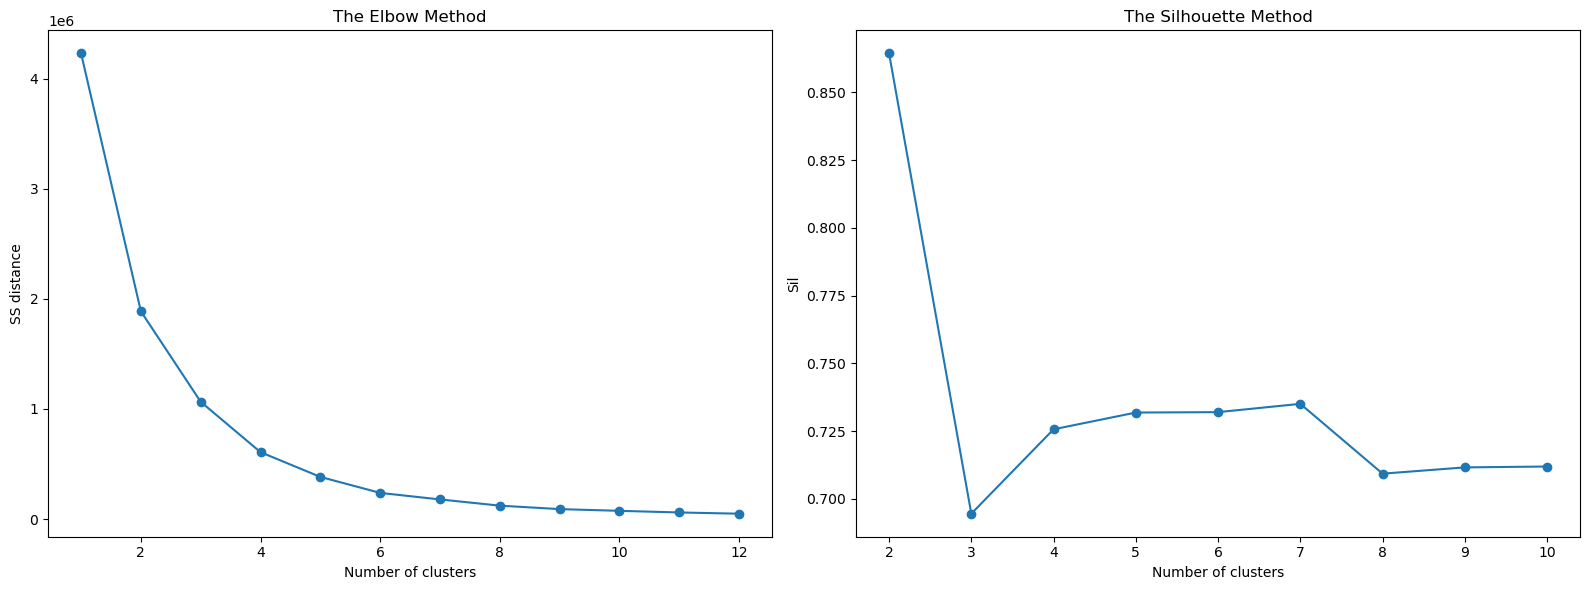

In [47]:
# Set up a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow Method Plot (Left)
ss = []
for i in range(1, 13):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(cluster_cost_pallet)
    ss.append(kmeans.inertia_)

axes[0].plot(range(1, 13), ss, marker='o')
axes[0].set_title("The Elbow Method")
axes[0].set_xlabel("Number of clusters")
axes[0].set_ylabel("SS distance")
# Optionally highlight the optimal k
# axes[0].scatter(8, ss[4], color='red', s=200, edgecolor='black', label='Optimal k=7')

# Silhouette Method Plot (Right)
sil = []
kmax = 10

for k in range(2, kmax + 1):
    kmeans_s = KMeans(n_clusters=k).fit(cluster_cost_pallet)
    labels = kmeans_s.labels_
    sil.append(silhouette_score(cluster_cost_pallet, labels, metric='euclidean'))

axes[1].plot(range(2, kmax + 1), sil, marker='o')
axes[1].set_title("The Silhouette Method")
axes[1].set_xlabel("Number of clusters")
axes[1].set_ylabel("Sil")
# Optionally highlight the optimal k
# axes[1].scatter(5, sil[3], color='red', s=200, edgecolor='black', label='Optimal k=7')

# Adjust layout for spacing
plt.tight_layout()

# Show the plots
plt.show()

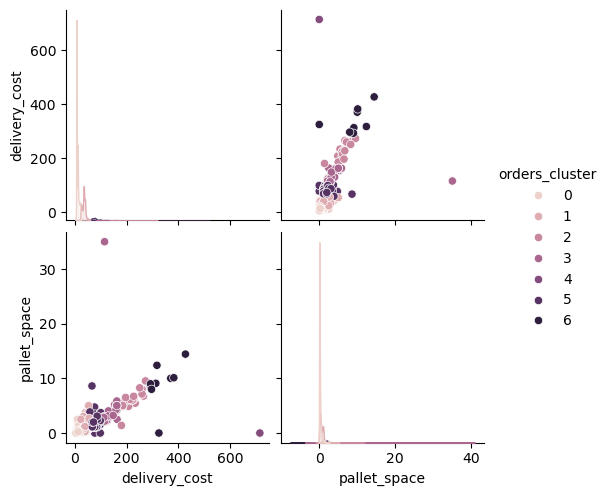

In [48]:
# Use 7 clusters.
kmeans = KMeans(n_clusters = 7, 
                max_iter = 15000,
                init='k-means++',
                random_state=0).fit(cluster_cost_pallet)

clusters = kmeans.labels_

cluster_cost_pallet['orders_cluster'] = clusters

# Plot the predicted.
sns.pairplot(cluster_cost_pallet,
             hue='orders_cluster',
             diag_kind= 'kde')

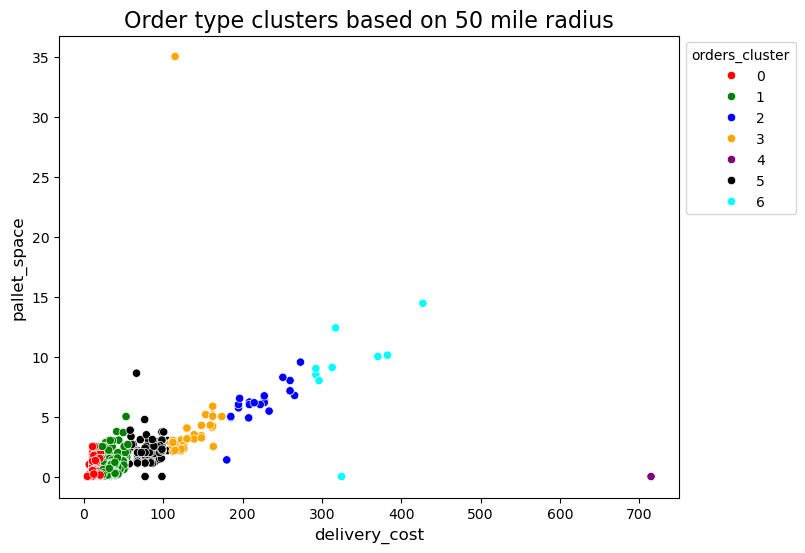

In [49]:
# Visualising the clusters.
plt.figure(figsize=(8, 6))

# Use Seaborn's predefined palette with 8 distinct colors
#palette = sns.color_palette("tab10", 5)

# Create a scatterplot.
sns.scatterplot(x='delivery_cost', 
                y ='pallet_space',
                data=cluster_cost_pallet,
                hue='orders_cluster',
                palette=['red', 'green', 'blue', 'orange', 'purple', 'black', 'cyan' ]
               )

# Add titles and labels to make it clearer
plt.title('Order type clusters based on 50 mile radius', fontsize=16)
plt.xlabel('delivery_cost', fontsize=12)
plt.ylabel('pallet_space', fontsize=12)

# Adjust the legend.
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='orders_cluster') 

# Save the plot as a PNG file
#plt.savefig('Customer clusters3.png', format='png', dpi=300, bbox_inches='tight')

In [50]:
# Add K-means clustering and  to DataFrame.
df_cost_pallet[['orders_cluster']] = cluster_cost_pallet[['orders_cluster']]

# View DataFrame
df_cost_pallet.head()

,order_id,website_id,order_date,date_despatched,courier,products_price,delivery_price,total_price,delivery_cost,total_cubic_m,pallet_space,line_weight_recalc,delivery_postcode,distance_miles,latitude,longitude,day_of_week,orders_cluster
0,2729774,889210,2024-06-03,2024-06-03,DX Freight,351.07,19.99,371.06,25.33,0.280986,0.397727,54.28,NG11 7,48.507,52.898976,-1.173471,Monday,1
1,2729788,784153,2024-06-03,2024-06-03,DX Freight,146.70,0.00,146.70,22.51,0.270000,0.277778,48.00,CV22 7,10.594,52.358672,-1.277863,Monday,1
2,2729796,896445,2024-06-03,2024-06-03,DX Freight,127.69,0.00,127.69,14.45,0.857425,0.448908,27.02,LE8 9,29.936,52.554763,-1.094327,Monday,0
3,2729807,885272,2024-06-03,2024-06-03,MFS,285.11,0.00,285.11,40.39,0.608900,0.413009,138.00,OX16 5,32.482,52.062262,-1.342841,Monday,1
4,2729809,843804,2024-06-03,2024-06-03,MFS,365.72,0.00,365.72,34.58,1.276950,0.938889,179.70,CV6 7,4.969,52.434320,-1.507344,Monday,1


>**Observation:** \
> After reviewing the above there appears to be 2 clear outliers, which we will remove.

In [51]:
# Remove rows where x_column or y_column has values above/below certain thresholds
df_cost_pallet = df_cost_pallet[(df_cost_pallet['pallet_space'] < 30) & (df_cost_pallet['delivery_cost'] < 700)]

#View dataframe
df_cost_pallet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4016 entries, 0 to 4017
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            4016 non-null   int64         
 1   website_id          4016 non-null   int64         
 2   order_date          4016 non-null   datetime64[ns]
 3   date_despatched     4016 non-null   datetime64[ns]
 4   courier             4016 non-null   object        
 5   products_price      4016 non-null   float64       
 6   delivery_price      4016 non-null   float64       
 7   total_price         4016 non-null   float64       
 8   delivery_cost       4016 non-null   float64       
 9   total_cubic_m       4016 non-null   float64       
 10  pallet_space        4016 non-null   float64       
 11  line_weight_recalc  4016 non-null   float64       
 12  delivery_postcode   4016 non-null   object        
 13  distance_miles      4016 non-null   float64       
 1

## b) Explore the characteristics order type clusters

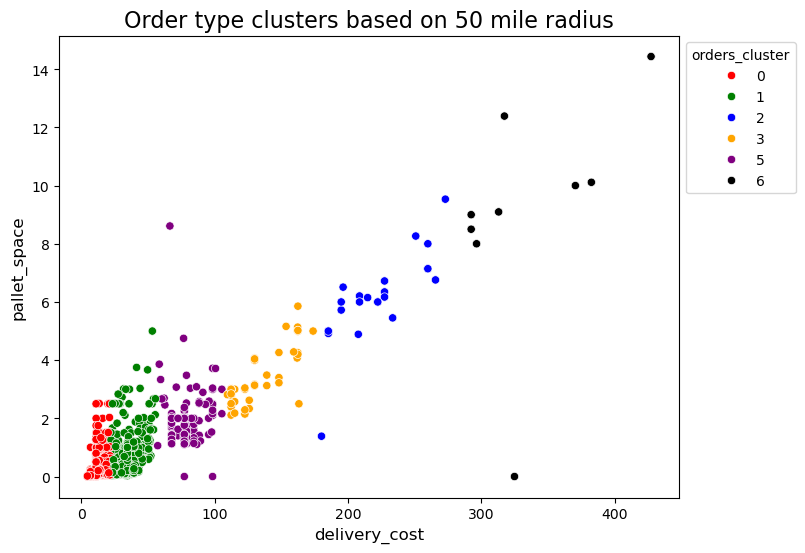

In [52]:
# Visualising the clusters.
plt.figure(figsize=(8, 6))

# Use Seaborn's predefined palette with 8 distinct colors
#palette = sns.color_palette("tab10", 5)

# Create a scatterplot.
sns.scatterplot(x='delivery_cost', 
                y ='pallet_space',
                data=df_cost_pallet,
                hue='orders_cluster',
                palette=['red', 'green', 'blue', 'orange', 'purple', 'black', 'cyan' ]
               )

# Add titles and labels to make it clearer
plt.title('Order type clusters based on 50 mile radius', fontsize=16)
plt.xlabel('delivery_cost', fontsize=12)
plt.ylabel('pallet_space', fontsize=12)

# Adjust the legend.
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='orders_cluster') 

# Save the plot as a PNG file
#plt.savefig('Customer clusters3.png', format='png', dpi=300, bbox_inches='tight')

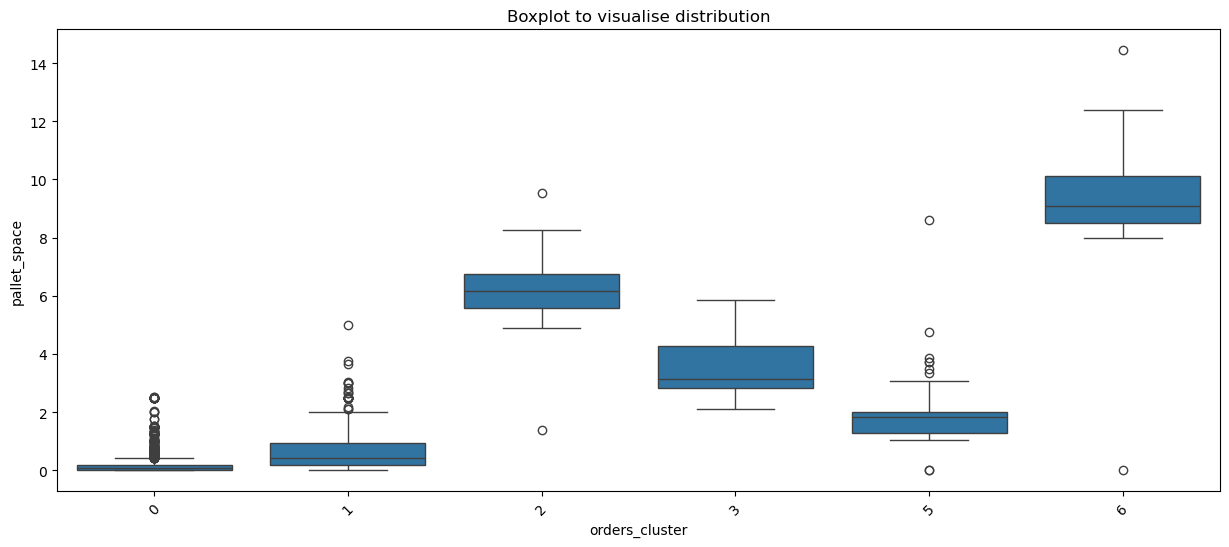

In [53]:
# Specify the columns to include
columns = ['pallet_space', 'orders_cluster']

# Plot a boxplot for the specified columns
plt.figure(figsize=(15, 6))
sns.boxplot(x='orders_cluster', y='pallet_space', data=df_cost_pallet)
plt.xticks(rotation=45)
plt.title('Boxplot to visualise distribution')
plt.show()

In [54]:
# Group by order clusters.
# Assign dataframe.
df = df_cost_pallet

# Key metrics on 50 miles radius.
print("\n=== Key Metrics by order type cluster ===")
cost_pallet_dispatches_50m = df.groupby('orders_cluster').agg(
   order_count=('date_despatched', 'count'),
    price=('total_price', 'sum'),
    delivery_cost=('delivery_cost', 'sum'),
    pallet_space=('pallet_space', 'sum'),
    cost_pc_of_price=('delivery_cost', lambda x: round(
        (x.sum() / df.loc[x.index, 'total_price'].sum()) * 100, 2)
    ),
    rev_per_pallet=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    cost_per_pallet=('delivery_cost', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    rev_per_order=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'date_despatched'].count(), 2)
    )
)

# Format all numeric columns with a thousand separator and two decimal places.
formatted_cost_pallet_dispatches_50m = cost_pallet_dispatches_50m.applymap(
    lambda x: "{:,.2f}".format(x) if isinstance(x, (int, float)) else x)

# Display the formatted DataFrame
formatted_cost_pallet_dispatches_50m


=== Key Metrics by order type cluster ===


,order_count,price,delivery_cost,pallet_space,cost_pc_of_price,rev_per_pallet,cost_per_pallet,rev_per_order
orders_cluster,,,,,,,,
0,"2,551.00","221,661.33","25,541.46",433.92,11.52,510.83,58.86,86.89
1,"1,202.00","390,826.15","40,473.98",677.18,10.36,577.14,59.77,325.15
2,23.00,"42,334.43","5,090.54",141.31,12.02,299.59,36.02,"1,840.63"
3,54.00,"70,852.78","7,329.94",192.54,10.35,367.98,38.07,"1,312.09"
5,177.00,"123,663.09","13,763.48",330.22,11.13,374.48,41.68,698.66
6,9.00,"20,444.63","3,016.17",81.53,14.75,250.75,36.99,"2,271.63"


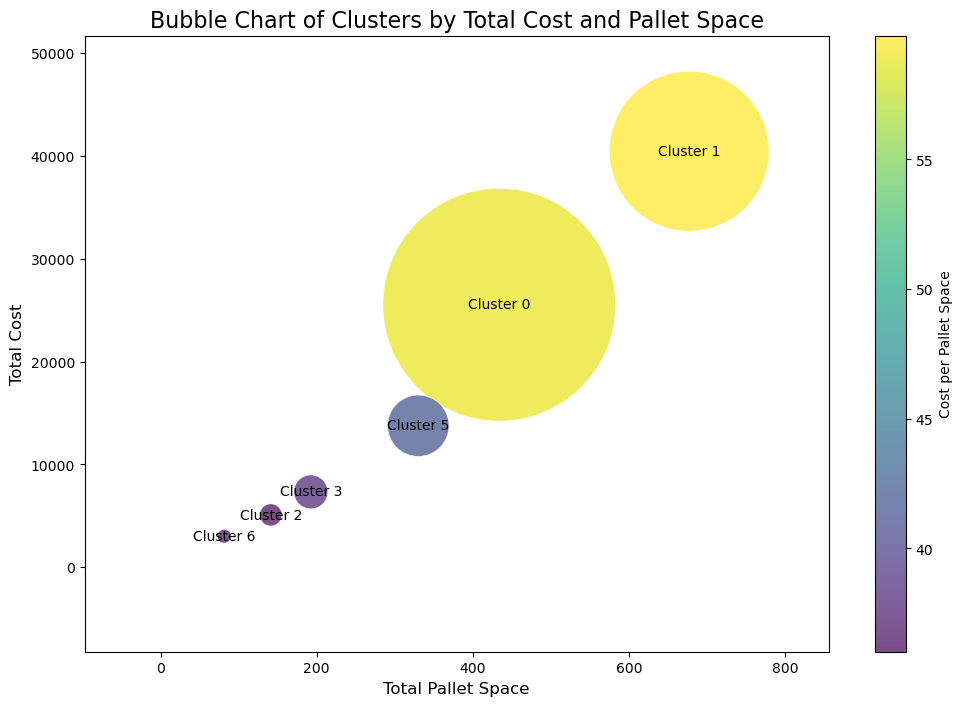

In [55]:
# Set variable
df = cost_pallet_dispatches_50m

# Set up the bubble chart
plt.figure(figsize=(12, 8))
#sns.set(style="whitegrid")

# Bubble chart with Matplotlib scatter plot
bubble_chart = plt.scatter(
    x=df["pallet_space"],
    y=df["delivery_cost"],
    s=df["order_count"] * 11,  # Adjust the size scaling if needed
    c=df["cost_per_pallet"],
    cmap="viridis",
    alpha=0.7,
    edgecolors="w",
    linewidth=0.5
)

# Add color bar to represent cost per pallet space
cbar = plt.colorbar(bubble_chart)
cbar.set_label("Cost per Pallet Space")

# Labeling the chart
plt.xlabel("Total Pallet Space", fontsize=12)
plt.ylabel("Total Cost", fontsize=12)
plt.title("Bubble Chart of Clusters by Total Cost and Pallet Space", fontsize=16)

# Annotate clusters for clarity
for i, row in df.iterrows():
    plt.annotate(f"Cluster {row.name}", (row["pallet_space"], row["delivery_cost"]),
                 ha="center", va="center", fontsize=10, color="black")

# Adds a 10% padding to avoid clipping
plt.margins(0.3) 

# Remove the grid
plt.grid(False)


# Save the plot as an image file
#plt.savefig("bubble_chart_clusters.png", format="png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

>**Observation:** \
> Cluster 5, 3, 2, and 6 all have similar characteristics - low order volume, low cost and revenue per pallet (compared to cluster 0 and 1), high revenue per order and high pallet usage relative to order volume. We will group these Clusters into 1 for ease of analysis.

In [56]:
# Define the mapping dictionary for mapping cluster 5, 3,2 and 6 to consolidated order cluster.
orders_cluster_consol = {
    0: 0,
    1: 1,
    2: 2,
    3: 2,
    5: 2,
    6: 2
}

# Map the cluster names to the orders_cluster column in the DataFrame
df_cost_pallet['orders_cluster_consol'] = df_cost_pallet['orders_cluster'].map(orders_cluster_consol)

# Display the DataFrame to check the result
df_cost_pallet.head()

,order_id,website_id,order_date,date_despatched,courier,products_price,delivery_price,total_price,delivery_cost,total_cubic_m,pallet_space,line_weight_recalc,delivery_postcode,distance_miles,latitude,longitude,day_of_week,orders_cluster,orders_cluster_consol
0,2729774,889210,2024-06-03,2024-06-03,DX Freight,351.07,19.99,371.06,25.33,0.280986,0.397727,54.28,NG11 7,48.507,52.898976,-1.173471,Monday,1,1
1,2729788,784153,2024-06-03,2024-06-03,DX Freight,146.70,0.00,146.70,22.51,0.270000,0.277778,48.00,CV22 7,10.594,52.358672,-1.277863,Monday,1,1
2,2729796,896445,2024-06-03,2024-06-03,DX Freight,127.69,0.00,127.69,14.45,0.857425,0.448908,27.02,LE8 9,29.936,52.554763,-1.094327,Monday,0,0
3,2729807,885272,2024-06-03,2024-06-03,MFS,285.11,0.00,285.11,40.39,0.608900,0.413009,138.00,OX16 5,32.482,52.062262,-1.342841,Monday,1,1
4,2729809,843804,2024-06-03,2024-06-03,MFS,365.72,0.00,365.72,34.58,1.276950,0.938889,179.70,CV6 7,4.969,52.434320,-1.507344,Monday,1,1


In [57]:
# Define the mapping dictionary mapping for order cluster naming.
cluster_name_mapping = {
    0: "Cluster 0 - High volume, Low pallet usage & value/order",
    1: "Cluster 1 - Moderate volume and pallet usage, above average value/order",
    2: "Cluster 2 - Low volume, High pallet usage & value/order",
}

# Map the cluster names to the orders_cluster column in the DataFrame
df_cost_pallet['cluster_name_mapping'] = df_cost_pallet['orders_cluster_consol'].map(cluster_name_mapping)

# Display the DataFrame to check the result
df_cost_pallet.head()

,order_id,website_id,order_date,date_despatched,courier,products_price,delivery_price,total_price,delivery_cost,total_cubic_m,pallet_space,line_weight_recalc,delivery_postcode,distance_miles,latitude,longitude,day_of_week,orders_cluster,orders_cluster_consol,cluster_name_mapping
0,2729774,889210,2024-06-03,2024-06-03,DX Freight,351.07,19.99,371.06,25.33,0.280986,0.397727,54.28,NG11 7,48.507,52.898976,-1.173471,Monday,1,1,"Cluster 1 - Moderate volume and pallet usage, ..."
1,2729788,784153,2024-06-03,2024-06-03,DX Freight,146.70,0.00,146.70,22.51,0.270000,0.277778,48.00,CV22 7,10.594,52.358672,-1.277863,Monday,1,1,"Cluster 1 - Moderate volume and pallet usage, ..."
2,2729796,896445,2024-06-03,2024-06-03,DX Freight,127.69,0.00,127.69,14.45,0.857425,0.448908,27.02,LE8 9,29.936,52.554763,-1.094327,Monday,0,0,"Cluster 0 - High volume, Low pallet usage & va..."
3,2729807,885272,2024-06-03,2024-06-03,MFS,285.11,0.00,285.11,40.39,0.608900,0.413009,138.00,OX16 5,32.482,52.062262,-1.342841,Monday,1,1,"Cluster 1 - Moderate volume and pallet usage, ..."
4,2729809,843804,2024-06-03,2024-06-03,MFS,365.72,0.00,365.72,34.58,1.276950,0.938889,179.70,CV6 7,4.969,52.434320,-1.507344,Monday,1,1,"Cluster 1 - Moderate volume and pallet usage, ..."


In [58]:
# Review key metrics on consolidated order clusters.
# Assign dataframe.
df = df_cost_pallet

# Key metrics on 50 miles radius.
print("\n=== Key Metrics by order type cluster ===")
order_cluster_metrics = df.groupby('cluster_name_mapping').agg(
   order_count=('date_despatched', 'count'),
    price=('total_price', 'sum'),
    delivery_cost=('delivery_cost', 'sum'),
    pallet_space=('pallet_space', 'sum'),
    cost_pc_of_price=('delivery_cost', lambda x: round(
        (x.sum() / df.loc[x.index, 'total_price'].sum()) * 100, 2)
    ),
    rev_per_pallet=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    cost_per_pallet=('delivery_cost', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    rev_per_order=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'date_despatched'].count(), 2)
    )
)

# Format all numeric columns with a thousand separator and two decimal places.
formatted_order_cluster_metrics = order_cluster_metrics.applymap(
    lambda x: "{:,.2f}".format(x) if isinstance(x, (int, float)) else x)

# Display the formatted DataFrame
formatted_order_cluster_metrics


=== Key Metrics by order type cluster ===


,order_count,price,delivery_cost,pallet_space,cost_pc_of_price,rev_per_pallet,cost_per_pallet,rev_per_order
cluster_name_mapping,,,,,,,,
"Cluster 0 - High volume, Low pallet usage & value/order","2,551.00","221,661.33","25,541.46",433.92,11.52,510.83,58.86,86.89
"Cluster 1 - Moderate volume and pallet usage, above average value/order","1,202.00","390,826.15","40,473.98",677.18,10.36,577.14,59.77,325.15
"Cluster 2 - Low volume, High pallet usage & value/order",263.00,"257,294.93","29,200.13",745.61,11.35,345.08,39.16,978.31


In [59]:
# Create summary metrics with cluster number for ease of visualisation.
# Key metrics on order cluster
print("\n=== Key Metrics on by order type cluster ===")
summary_metrics_order_type = df.groupby('orders_cluster_consol').agg(
    order_count=('date_despatched', 'count'),
    price=('total_price', 'sum'),
    delivery_cost=('delivery_cost', 'sum'),
    pallet_space=('pallet_space', 'sum'),
    rev_per_pallet=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    cost_per_pallet=('delivery_cost', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    rev_per_order=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'date_despatched'].count(), 2)
    )
)

# Display the result
summary_metrics_order_type


=== Key Metrics on by order type cluster ===


,order_count,price,delivery_cost,pallet_space,rev_per_pallet,cost_per_pallet,rev_per_order
orders_cluster_consol,,,,,,,
0,2551,221661.33,25541.46,433.922784,510.83,58.86,86.89
1,1202,390826.15,40473.98,677.176873,577.14,59.77,325.15
2,263,257294.93,29200.13,745.607918,345.08,39.16,978.31


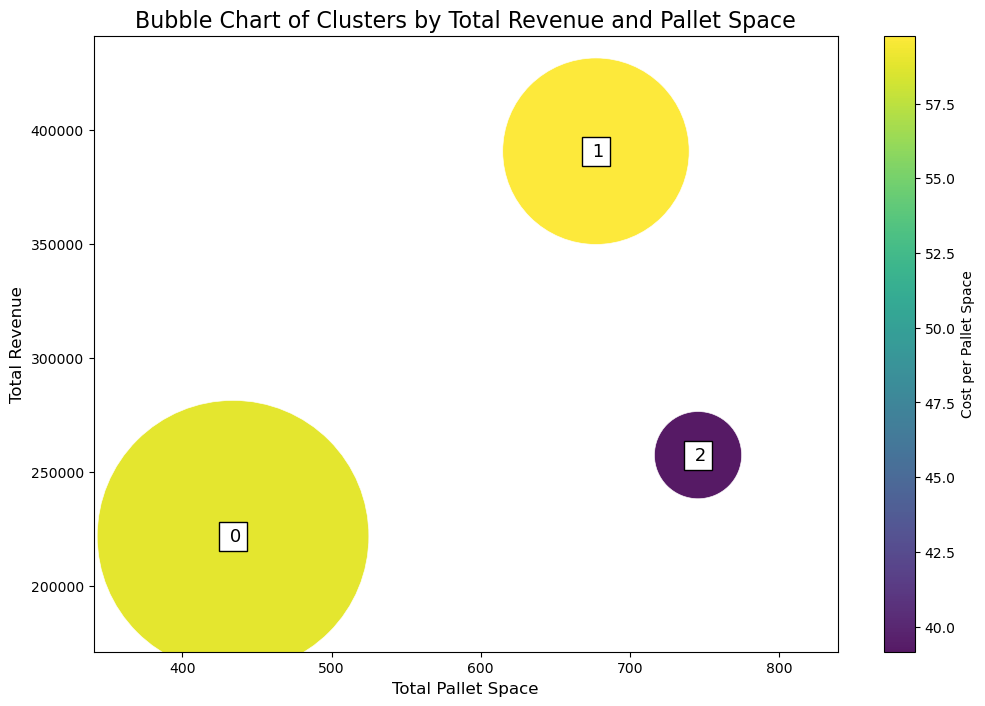

In [60]:
# Set variable
df = summary_metrics_order_type

# Set up the bubble chart
plt.figure(figsize=(12, 8))
#sns.set(style="whitegrid")

# Bubble chart with Matplotlib scatter plot
bubble_chart = plt.scatter(
    x=df["pallet_space"],
    y=df["price"],
    s=df["order_count"] * 15,  # Adjust the size scaling if needed
    c=df["cost_per_pallet"],
    cmap="viridis",
    alpha=0.9,
    edgecolors="w",
    linewidth=0.5
)

# Add color bar to represent cost per pallet space
cbar = plt.colorbar(bubble_chart)
cbar.set_label("Cost per Pallet Space")

# Labeling the chart
plt.xlabel("Total Pallet Space", fontsize=12)
plt.ylabel("Total Revenue", fontsize=12)
plt.title("Bubble Chart of Clusters by Total Revenue and Pallet Space", fontsize=16)

# Annotate clusters for clarity
for i, row in df.iterrows():
    plt.annotate(f" {row.name}", (row["pallet_space"], row["price"]),
                 ha="center", va="center", fontsize=13, color="black",
                bbox=dict(facecolor="white", edgecolor="black", alpha=1))


# Adds a 10% padding to avoid clipping
plt.margins(0.3) 

# Remove the grid
plt.grid(False)


# Save the plot as an image file
#plt.savefig("bubble_chart_clusters.png", format="png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

> Will use Tableau for visualisation.

In [61]:
# Key metrics on order cluster by percentage.
print("\n=== Key Metrics by order type cluster ===")
summary_metrics_order_plot = df_cost_pallet.groupby('orders_cluster_consol').agg(
    order_count=('date_despatched', 'count'),
    price=('total_price', 'sum'),
    delivery_cost=('delivery_cost', 'sum'),
    pallet_space=('pallet_space', 'sum'),
)

# Calculate percentages.
summary_metrics_order_plot['order%'] = summary_metrics_order_plot['order_count'] / summary_metrics_order_plot['order_count'].sum() * 100
summary_metrics_order_plot['revenue%'] = summary_metrics_order_plot['price'] / summary_metrics_order_plot['price'].sum() * 100
summary_metrics_order_plot['delivery_cost%'] = summary_metrics_order_plot['delivery_cost'] / summary_metrics_order_plot['delivery_cost'].sum() * 100
summary_metrics_order_plot['pallet%'] = summary_metrics_order_plot['pallet_space'] / summary_metrics_order_plot['pallet_space'].sum() * 100


# Display only necessary columns.
summary_metrics_order_plot = summary_metrics_order_plot[['order%', 'revenue%', 'delivery_cost%','pallet%']]


# Sort by count% in ascending order
summary_metrics_order_plot = summary_metrics_order_plot.sort_values(by='order%', ascending=False)

# Print the result
summary_metrics_order_plot


=== Key Metrics by order type cluster ===


,order%,revenue%,delivery_cost%,pallet%
orders_cluster_consol,,,,
0,63.520916,25.484688,26.824877,23.370551
1,29.930279,44.933784,42.507733,36.471918
2,6.548805,29.581528,30.667390,40.157531


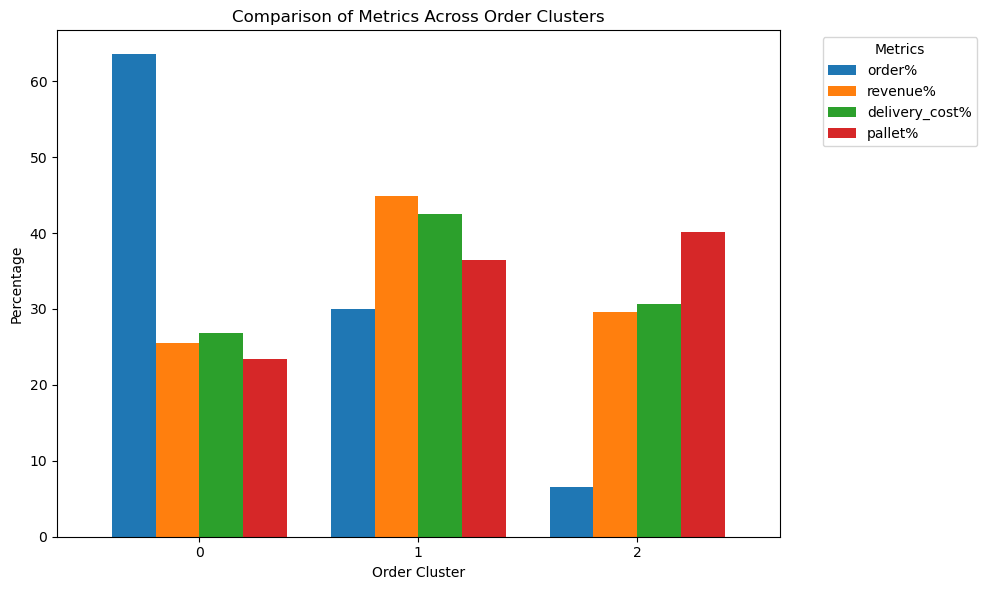

In [62]:
# Visualise table above.
summary_metrics_order_plot.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Comparison of Metrics Across Order Clusters')
plt.ylabel('Percentage')
plt.xlabel('Order Cluster')
plt.xticks(rotation=0)
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

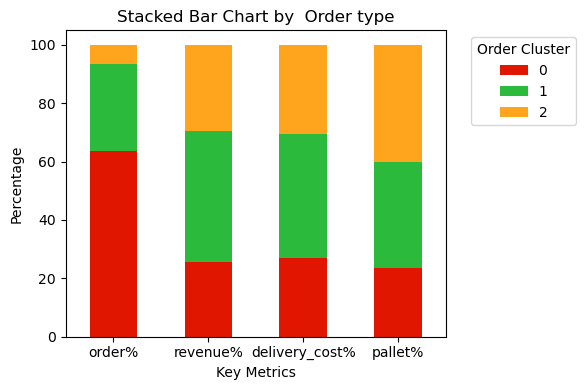

In [63]:
# Transpose the dataframe to switch rows and columns
summary_metrics_t = summary_metrics_order_plot.T

# Define custom colors for each cluster: 0 = red, 1 = green, 2 = orange
custom_colours = ['#E11601', '#2CBA3D', '#FFA41D']

# Plot a stacked bar chart with customer segments (count%, loyalty, etc.) stacked within each bar
summary_metrics_order_plot.T.plot(kind='bar', stacked=True, figsize=(6, 4), color=custom_colours)
plt.title('Stacked Bar Chart by  Order type')
plt.ylabel('Percentage')
plt.xlabel('Key Metrics')
plt.xticks(rotation=0)
plt.legend(title='Order Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot as a PNG file
#plt.savefig('Order Cluster_segment.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

>**Observation:** \
> **Cluster 0:** 63% of order count but only accounts for 25% of revenue. This will put pressure on number of orders we can do a day. Current assumption is 20-25. This means that we won't cover enough revenue/ cost base.\
> **Cluster 1:** 30% of order volume, but accounts for 45% of revenue. It also has a highest cost per pallet.\
> **Cluster 2:** These are large orders - 7% of order volume but 30% of revenue. This is a key area, however, it does put pressure on pallet consumption and does not cover as much revenue as cluster 1. This group could be used to subsidise cluster 1 on low pallet consumption days.

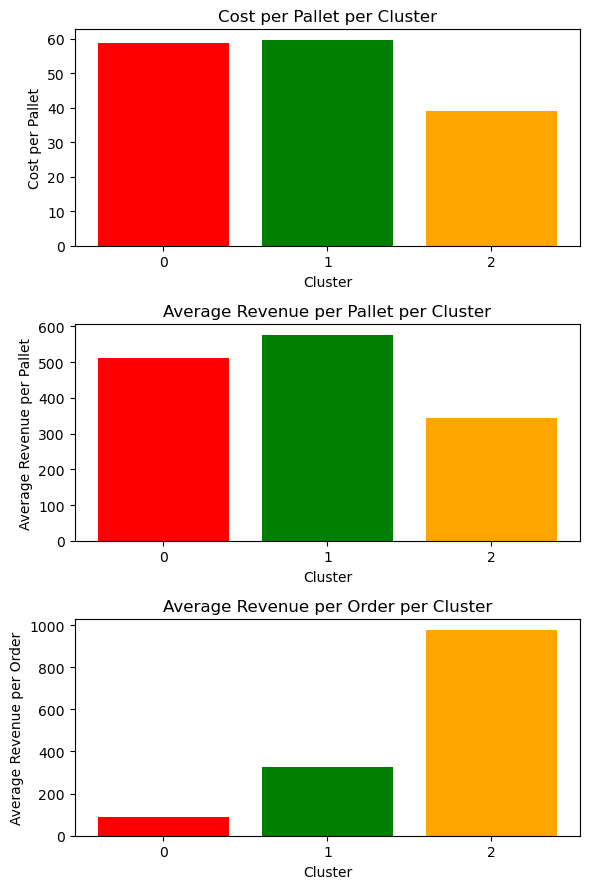

In [64]:
# Define colors for clusters.
cluster_colors = {
    0: 'red',
    1: 'green',
    2: 'orange'
}

# Extract data from the summary table.
cost_per_pallet = summary_metrics_order_type['cost_per_pallet']
ave_rev_per_pallet = summary_metrics_order_type['rev_per_pallet']
ave_rev_per_order = summary_metrics_order_type['rev_per_order']

# Create bar plots
fig, axes = plt.subplots(3, 1, figsize=(6, 9))

# Function to format x-axis as categorical labels.
def format_xticks(ax, labels):
    ax.set_xticks(labels)
    ax.set_xticklabels(labels)

# Bar plot for cost per pallet.
axes[0].bar(cost_per_pallet.index, cost_per_pallet.values, color=[cluster_colors[i] for i in cost_per_pallet.index])
axes[0].set_title('Cost per Pallet per Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Cost per Pallet')
format_xticks(axes[0], cost_per_pallet.index)

# Bar plot for average revenue per pallet.
axes[1].bar(ave_rev_per_pallet.index, ave_rev_per_pallet.values, color=[cluster_colors[i] for i in ave_rev_per_pallet.index])
axes[1].set_title('Average Revenue per Pallet per Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Average Revenue per Pallet')
format_xticks(axes[1], ave_rev_per_pallet.index)

# Bar plot for average revenue per order.
axes[2].bar(ave_rev_per_order.index, ave_rev_per_order.values, color=[cluster_colors[i] for i in ave_rev_per_order.index])
axes[2].set_title('Average Revenue per Order per Cluster')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Average Revenue per Order')
format_xticks(axes[2], ave_rev_per_order.index)

# Improve layout
plt.tight_layout()

# Show the plots
plt.show()

>**Observation:** \
> **Cluster 0: High volume, Low pallet usage & value/order:** Has really low revenue per order, it requires high volume to achieve meaningful revenue/ cost cover. This will strain resources as more logistics will be needed. This is also seen by the high volume of orders.\
> **Cluster 1: Moderate volume and pallet usage, above average value/order:** Has above average revenue per order and highest cost per pallet. This suggests that potential savings could be achieved by insourcing and thus reducing the cost per pallet and maintaining good revenue coverage.\
> **Cluster 2: Low volume, High pallet usage & value/order:** High revenue per order which means we can do fewer deliveries to achieve higher revenue. However, the pallet consumption is high and cost/ revenue per pallet is low (compared to cluster 0 and cluster 1) so already outsourcing might be at a reasonable cost.

>> **We will run the route optimisation calcualtion on cluster 1: Moderate volume and pallet usage, above average value/order.**

## c) Review cluster split by courier
 - to see if there is a pattern in the clusters with regards to the couriers used.

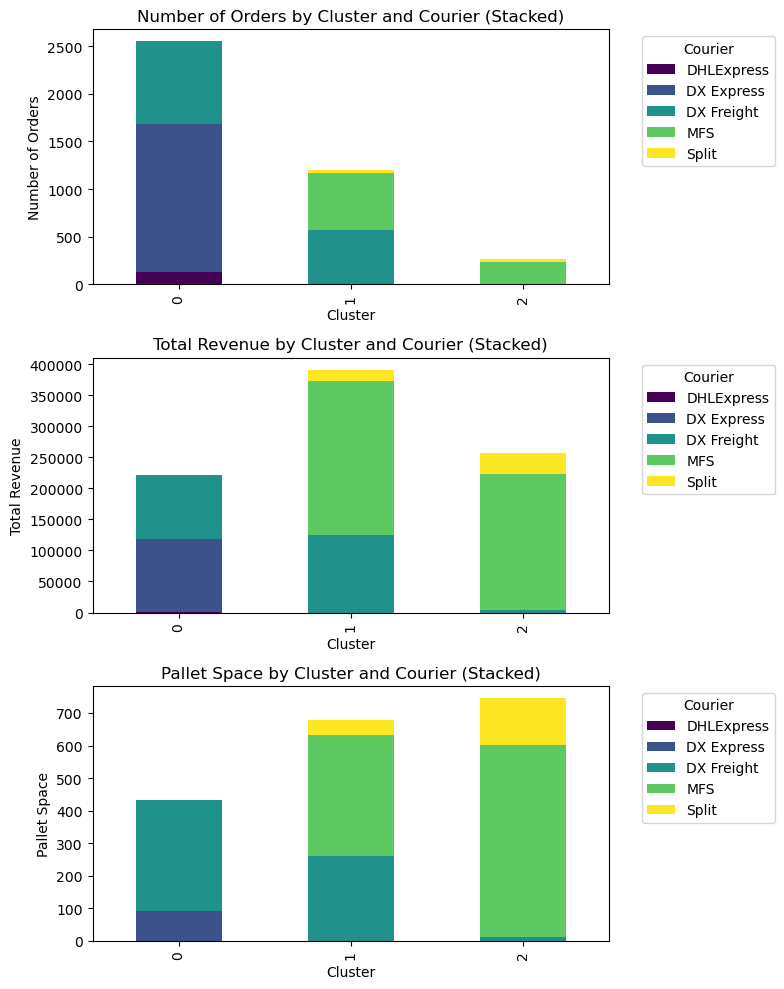

In [65]:
# Group the data by 'orders_cluster_consol' and 'courier' and calculate metrics.
number_of_orders = df_cost_pallet.groupby(['orders_cluster_consol', 'courier']).size().unstack(fill_value=0)
total_revenue = df_cost_pallet.groupby(['orders_cluster_consol', 'courier'])['total_price'].sum().unstack(fill_value=0)
pallet_space = df_cost_pallet.groupby(['orders_cluster_consol', 'courier'])['pallet_space'].sum().unstack(fill_value=0)

# Set up figure and axes for three stacked bar charts.
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

# Plot 1: Number of Orders (Stacked)
number_of_orders.plot(kind='bar', stacked=True, ax=axes[0], colormap='viridis')
axes[0].set_title('Number of Orders by Cluster and Courier (Stacked)')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Number of Orders')
axes[0].legend(title='Courier', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Total Revenue (Stacked)
total_revenue.plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis')
axes[1].set_title('Total Revenue by Cluster and Courier (Stacked)')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Total Revenue')
axes[1].legend(title='Courier', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 3: Pallet Space (Stacked)
pallet_space.plot(kind='bar', stacked=True, ax=axes[2], colormap='viridis')
axes[2].set_title('Pallet Space by Cluster and Courier (Stacked)')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Pallet Space')
axes[2].legend(title='Courier', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout.
plt.tight_layout()

# Show the plots
plt.show()

>**Observation:** \
> **Cluster 0: High volume, Low pallet usage & value/order:** represents Express deliveries and smaller DX Freight orders.\
> **Cluster 1: Moderate volume and pallet usage, above average value/order:** includes larger DX Freight (covering some of the ugly freight) and smaller MFS pallet orders.\
> **Cluster 2:Low volume, High pallet usage & value/order:** features low-volume but high-pallet usage deliveries, primarily larger MFS shipments.

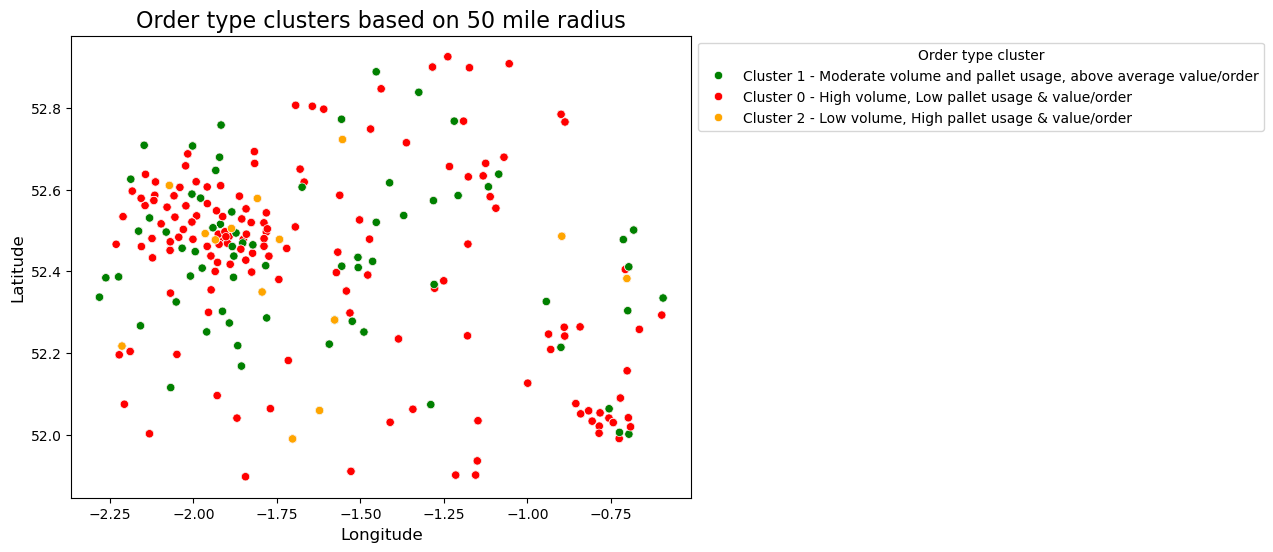

In [66]:
# Define a custom color palette for the clusters.
custom_palette = {
    "Cluster 0 - High volume, Low pallet usage & value/order": "red",
    "Cluster 1 - Moderate volume and pallet usage, above average value/order": "green",
    "Cluster 2 - Low volume, High pallet usage & value/order": "orange"
}

# Create a scatterplot with the custom palette.
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='longitude',
    y='latitude',
    data=df_cost_pallet,
    hue='cluster_name_mapping',
    palette=custom_palette
)

# Add titles and labels for clarity.
plt.title('Order type clusters based on 50 mile radius', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Adjust the legend.
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Order type cluster')

# Show the plot.
plt.show()

>**Observation**:
> Will perform K-means clustering for area mapping.

# 4. Cluster dataframe by area

In [67]:
# Keep only necessary columns.
cluster_area = df_cost_pallet[['latitude', 'longitude']]

#View DataFrame
cluster_area.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4016 entries, 0 to 4017
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   4016 non-null   float64
 1   longitude  4016 non-null   float64
dtypes: float64(2)
memory usage: 223.2 KB


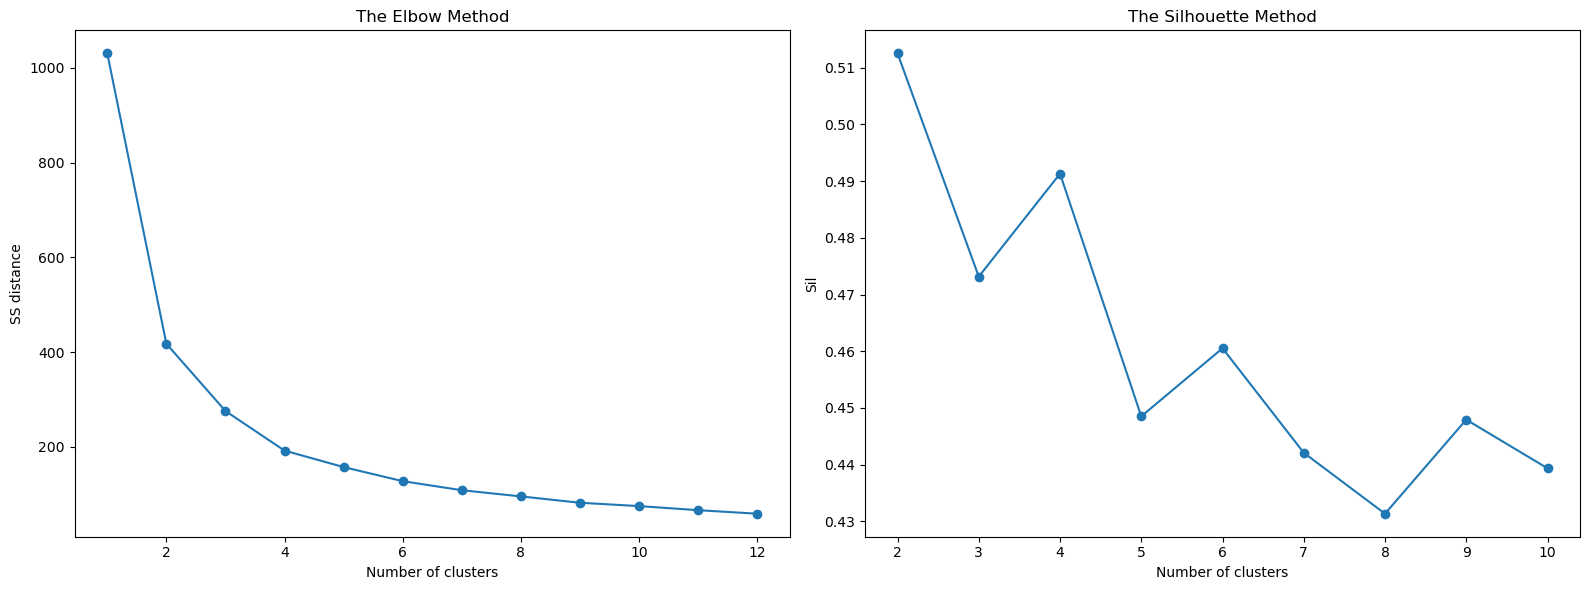

In [68]:
# Set up a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow Method Plot (Left)
ss = []
for i in range(1, 13):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(cluster_area)
    ss.append(kmeans.inertia_)

axes[0].plot(range(1, 13), ss, marker='o')
axes[0].set_title("The Elbow Method")
axes[0].set_xlabel("Number of clusters")
axes[0].set_ylabel("SS distance")
# Optionally highlight the optimal k
# axes[0].scatter(8, ss[4], color='red', s=200, edgecolor='black', label='Optimal k=7')

# Silhouette Method Plot (Right)
sil = []
kmax = 10

for k in range(2, kmax + 1):
    kmeans_s = KMeans(n_clusters=k).fit(cluster_area)
    labels = kmeans_s.labels_
    sil.append(silhouette_score(cluster_area, labels, metric='euclidean'))

axes[1].plot(range(2, kmax + 1), sil, marker='o')
axes[1].set_title("The Silhouette Method")
axes[1].set_xlabel("Number of clusters")
axes[1].set_ylabel("Sil")
# Optionally highlight the optimal k
# axes[1].scatter(5, sil[3], color='red', s=200, edgecolor='black', label='Optimal k=7')

# Adjust layout for spacing
plt.tight_layout()

# Show the plots
plt.show()

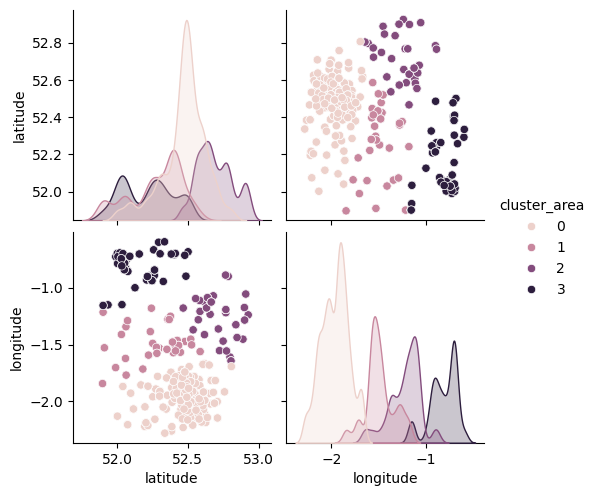

In [69]:
# Use 4 clusters.
kmeans = KMeans(n_clusters = 4, 
                max_iter = 15000,
                init='k-means++',
                random_state=0).fit(cluster_area)

clusters = kmeans.labels_

cluster_area['cluster_area'] = clusters

# Plot the predicted.
sns.pairplot(cluster_area,
             hue='cluster_area',
             diag_kind= 'kde')

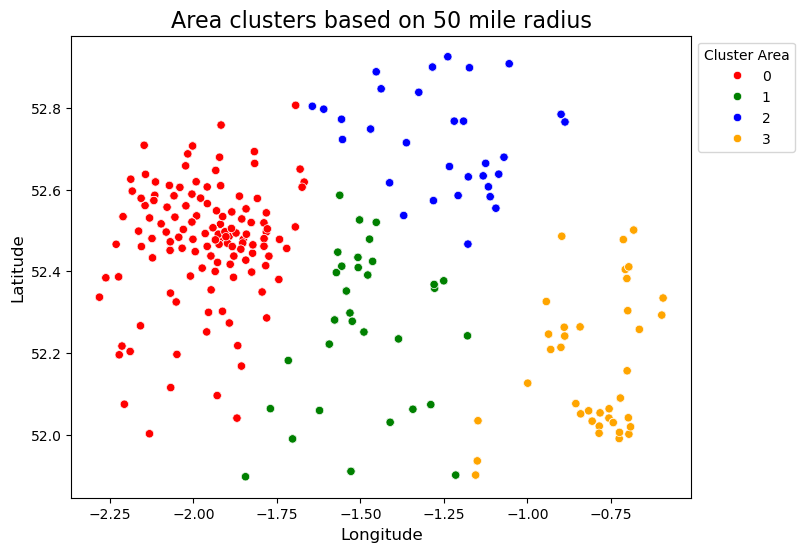

In [70]:
# Visualising the clusters.
plt.figure(figsize=(8, 6))

# Use Seaborn's predefined palette with 8 distinct colors
#palette = sns.color_palette("tab10", 5)

# Create a scatterplot.
sns.scatterplot(x='longitude' , 
                y ='latitude',
                data=cluster_area,
                hue='cluster_area',
                palette=['red', 'green', 'blue', 'orange', 'purple', 'black', 'cyan']
               )

# Add titles and labels to make it clearer
plt.title('Area clusters based on 50 mile radius', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Remove the grid
plt.grid(False)


# Adjust the legend.
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Cluster Area') 

# Save the plot as a PNG file
#plt.savefig('Area cluster.png', format='png', dpi=300, bbox_inches='tight')

In [71]:
# Add K-means clustering and  to DataFrame.
df_cost_pallet[['cluster_area']] = cluster_area[['cluster_area']]

# View DataFrame
df_cost_pallet.head()

,order_id,website_id,order_date,date_despatched,courier,products_price,delivery_price,total_price,delivery_cost,total_cubic_m,...,line_weight_recalc,delivery_postcode,distance_miles,latitude,longitude,day_of_week,orders_cluster,orders_cluster_consol,cluster_name_mapping,cluster_area
0,2729774,889210,2024-06-03,2024-06-03,DX Freight,351.07,19.99,371.06,25.33,0.280986,...,54.28,NG11 7,48.507,52.898976,-1.173471,Monday,1,1,"Cluster 1 - Moderate volume and pallet usage, ...",2
1,2729788,784153,2024-06-03,2024-06-03,DX Freight,146.70,0.00,146.70,22.51,0.270000,...,48.00,CV22 7,10.594,52.358672,-1.277863,Monday,1,1,"Cluster 1 - Moderate volume and pallet usage, ...",1
2,2729796,896445,2024-06-03,2024-06-03,DX Freight,127.69,0.00,127.69,14.45,0.857425,...,27.02,LE8 9,29.936,52.554763,-1.094327,Monday,0,0,"Cluster 0 - High volume, Low pallet usage & va...",2
3,2729807,885272,2024-06-03,2024-06-03,MFS,285.11,0.00,285.11,40.39,0.608900,...,138.00,OX16 5,32.482,52.062262,-1.342841,Monday,1,1,"Cluster 1 - Moderate volume and pallet usage, ...",1
4,2729809,843804,2024-06-03,2024-06-03,MFS,365.72,0.00,365.72,34.58,1.276950,...,179.70,CV6 7,4.969,52.434320,-1.507344,Monday,1,1,"Cluster 1 - Moderate volume and pallet usage, ...",1


In [72]:
# Define the mapping dictionary mapping for order cluster
area_name_mapping = {
    0: "Greater Birmingham and Black Country",
    1: "South Midlands and Cotswolds",
    2: "Leicestershire and East Midlands",
    3: "Northampton and Milton Keynes",
}

# Map the cluster names to the orders_cluster column in the DataFrame
df_cost_pallet['area_name'] = df_cost_pallet['cluster_area'].map(area_name_mapping)

# Display the DataFrame to check the result
df_cost_pallet.head()

,order_id,website_id,order_date,date_despatched,courier,products_price,delivery_price,total_price,delivery_cost,total_cubic_m,...,delivery_postcode,distance_miles,latitude,longitude,day_of_week,orders_cluster,orders_cluster_consol,cluster_name_mapping,cluster_area,area_name
0,2729774,889210,2024-06-03,2024-06-03,DX Freight,351.07,19.99,371.06,25.33,0.280986,...,NG11 7,48.507,52.898976,-1.173471,Monday,1,1,"Cluster 1 - Moderate volume and pallet usage, ...",2,Leicestershire and East Midlands
1,2729788,784153,2024-06-03,2024-06-03,DX Freight,146.70,0.00,146.70,22.51,0.270000,...,CV22 7,10.594,52.358672,-1.277863,Monday,1,1,"Cluster 1 - Moderate volume and pallet usage, ...",1,South Midlands and Cotswolds
2,2729796,896445,2024-06-03,2024-06-03,DX Freight,127.69,0.00,127.69,14.45,0.857425,...,LE8 9,29.936,52.554763,-1.094327,Monday,0,0,"Cluster 0 - High volume, Low pallet usage & va...",2,Leicestershire and East Midlands
3,2729807,885272,2024-06-03,2024-06-03,MFS,285.11,0.00,285.11,40.39,0.608900,...,OX16 5,32.482,52.062262,-1.342841,Monday,1,1,"Cluster 1 - Moderate volume and pallet usage, ...",1,South Midlands and Cotswolds
4,2729809,843804,2024-06-03,2024-06-03,MFS,365.72,0.00,365.72,34.58,1.276950,...,CV6 7,4.969,52.434320,-1.507344,Monday,1,1,"Cluster 1 - Moderate volume and pallet usage, ...",1,South Midlands and Cotswolds


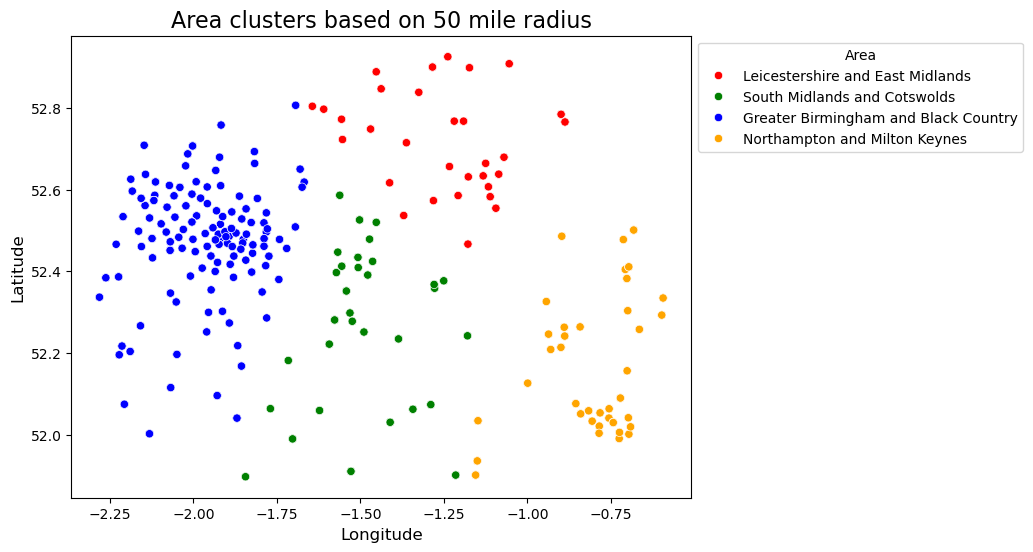

In [73]:
# Visualising the clusters.
plt.figure(figsize=(8, 6))

# Use Seaborn's predefined palette with 8 distinct colors
#palette = sns.color_palette("tab10", 5)

# Create a scatterplot.
sns.scatterplot(x='longitude' , 
                y ='latitude',
                data=df_cost_pallet,
                hue='area_name',
                palette=['red', 'green', 'blue', 'orange', 'purple', 'black', 'cyan']
               )

# Add titles and labels to make it clearer
plt.title('Area clusters based on 50 mile radius', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Remove the grid
plt.grid(False)


# Adjust the legend.
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Area') 

# Save the plot as a PNG file
#plt.savefig('Area cluster.png', format='png', dpi=300, bbox_inches='tight')

In [74]:
# Save DataFrame as csv.
df_cost_pallet.to_csv('df_cost_clustering_pallet.csv')

In [75]:
# Create a mapping dictionary for cluster names
cluster_name_mapping = {
    0: "High volume, Low pallet usage & value/order",
    1: "Moderate volume and pallet usage, above average value/order",
    2: "Low volume, High pallet usage & value/order"
}

# Create variable
df = df_cost_pallet

# Loop through each cluster from 0 to 2
for cluster in range(3):  # Adjust the range if you have more or fewer clusters
    # Get the cluster name from the mapping
    cluster_name = cluster_name_mapping.get(cluster, "Unnamed Cluster")
    
    # Print cluster metrics header with the cluster name
    print(f"\n=== Key Metrics for Order Type Cluster {cluster}: {cluster_name} ===")
    
    # Filter the DataFrame for the current cluster
    df_cluster = df[df['orders_cluster_consol'] == cluster]

    # Group by 'area_name' and calculate metrics
    cluster_metrics = df_cluster.groupby('area_name').agg(
        order_count=('date_despatched', 'count'),
        revenue=('total_price', 'sum'),
        cost=('delivery_cost', 'sum'),
        pallet_space=('pallet_space', 'sum'),
        cost_pc_of_rev=('delivery_cost', lambda x: round((x.sum() / df_cluster.loc[x.index, 'total_price'].sum()) * 100, 2)),
        ave_rev_per_pallet=('total_price', lambda x: round(x.sum() / df_cluster.loc[x.index, 'pallet_space'].sum(), 2)),
        ave_cost_per_pallet=('delivery_cost', lambda x: round(x.sum() / df_cluster.loc[x.index, 'pallet_space'].sum(), 2))
    )

    # Display the result for the current cluster
    print(cluster_metrics)


=== Key Metrics for Order Type Cluster 0: High volume, Low pallet usage & value/order ===
                                      order_count   revenue      cost  \
area_name                                                               
Greater Birmingham and Black Country         1066  94731.89  10659.69   
Leicestershire and East Midlands              511  44447.14   5016.72   
Northampton and Milton Keynes                 438  35719.94   4432.19   
South Midlands and Cotswolds                  536  46762.36   5432.86   

                                      pallet_space  cost_pc_of_rev  \
area_name                                                            
Greater Birmingham and Black Country    173.015728           11.25   
Leicestershire and East Midlands         76.786312           11.29   
Northampton and Milton Keynes            76.665352           12.41   
South Midlands and Cotswolds            107.455393           11.62   

                                      ave_rev_per

>**Observation:** \
> **Greater Birmingham** is the most customer dense region acorss all clusters.\
> **Northampton and Milton Keynes** is the least dense.\
> We will run the route optimisation for Cluster 1 for all 4 areas, but note that Northampton and Milton Keynes may not have sufficient volume to make it profitable for Kite.

# 5. Explore the order details dataframe

In [76]:
# View dataframe.
orders_details_df1.head()

,order_id,part_number,description,packs,pack_price,units_per_pack,pack_weight,pallet_quantity,cubic_m_per_unit,total_pack_price,total_units,pallet_space,line_weight_recalc,total_cubic_m,website_id,delivery_postcode,distance_miles,latitude,longitude,courier
0,2729772,BB305X435,Clear bubble bags 305x435mm - pack of 150,1,26.46,150,2.55,2400,0.000925,26.46,150,0.062500,2.55,0.138750,971172.0,HU6 9,125.859,53.781069,-0.371417,DX Express
1,2729773,PBL1215,Light duty polythene bags - 11.75x14.75 inches...,1,18.80,1000,4.40,180000,0.000006,18.80,1000,0.005556,4.40,0.006000,971173.0,SE8 3,111.199,51.482013,-0.029615,DX Express
2,2729774,CSW222X150X88-BPB6,Brown postal boxes - 222x150x88mm (8.75x6x3.5 ...,1,20.55,50,3.90,2200,0.000726,20.55,50,0.022727,3.90,0.036300,889210.0,NG11 7,48.507,52.898976,-1.173471,DX Freight
3,2729774,PS320X140X420-BROWN,Twist handle paper carrier bags brown 320x140x...,1,52.28,250,5.00,3750,0.000144,52.28,250,0.066667,5.00,0.036000,889210.0,NG11 7,48.507,52.898976,-1.173471,DX Freight
4,2729774,TPK048050S,"Paper kraft tape - 48mm x 50m, Solvent - pack ...",3,13.05,6,1.28,2592,0.000677,39.15,18,0.006944,3.84,0.012186,889210.0,NG11 7,48.507,52.898976,-1.173471,DX Freight


In [77]:
# Load the CSV file as orders.
#orders_details_df1 = pd.read_csv('orders_details_merged_df.csv', index_col=0) 

# View the DataFrame.
#print(f"The dataset has {orders_details_df1.shape[0]} rows and {orders_details_df1.shape[1]} columns.")
#orders_details_df1.head()

In [78]:
# View metadata.
orders_details_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73885 entries, 0 to 73884
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            73885 non-null  int64  
 1   part_number         73885 non-null  object 
 2   description         73885 non-null  object 
 3   packs               73885 non-null  int64  
 4   pack_price          73885 non-null  float64
 5   units_per_pack      73885 non-null  int64  
 6   pack_weight         73885 non-null  float64
 7   pallet_quantity     73885 non-null  int64  
 8   cubic_m_per_unit    69930 non-null  float64
 9   total_pack_price    73885 non-null  float64
 10  total_units         73885 non-null  int64  
 11  pallet_space        73885 non-null  float64
 12  line_weight_recalc  73885 non-null  float64
 13  total_cubic_m       69930 non-null  float64
 14  website_id          73885 non-null  float64
 15  delivery_postcode   73885 non-null  object 
 16  dist

## a) Review the products.

In [79]:
# Determine unique products using product description.
unique_count = orders_details_df1['description'].nunique()

# Print the result
print(f"There are {unique_count} unique items in the 'description' column.")

There are 2390 unique items in the 'description' column.


In [80]:
# Group by 'description' and sum up the 'total_price'
price_per_description = orders_details_df1.groupby('description')['total_pack_price'].sum()

# Sort the results from largest to smallest
price_per_description_sorted = price_per_description.sort_values(ascending=False)

# Print the sorted result
price_per_description_sorted.head(20)

description
Double wall boxes - 24x18x18 inches (610x457x457 mm) - pack of 20                     75143.82
Double wall boxes - 18x12x12 inches (457x305x305 mm) - pack of 20                     67197.71
Speedman Box - Protective Paper Void Fill                                             51925.90
Starch based loose fill - 15 cu ft bag                                                45432.80
Packaging tape - Kite premium acrylic - clear 48mm x 66m - Pack of 36 rolls           44306.31
Double wall boxes - 12x12x12 inches (305x305x305 mm) - pack of 20                     42086.12
Double wall boxes - 12x9x9 inches (305x229x229 mm) - pack of 20                       40784.21
Double wall boxes - 12x9x6 inches (305x229x152 mm) - pack of 20                       39204.24
Double wall boxes - 18x18x18 inches (457x457x457 mm) - pack of 20                     38733.15
Double wall boxes - 16x16x16 inches (406x406x406 mm) - pack of 20                     38442.86
Double wall boxes - 15x10x10 inches (3

>**Observation:** \
> There are too many products and so will need to consolidate the products for understanding if there is a product mix based on order clusters.

## b) Consolidate products

In [81]:
# Create a copy of the order_details_df1 dataframe.
orders_details_group = orders_details_df1.copy()

In [82]:
# Modify description to remove everything after the first hyphen.
orders_details_group['modified_description'] = orders_details_group['description'].str.split(' - ').str[0]

# View the DataFrame.
orders_details_group.head()

,order_id,part_number,description,packs,pack_price,units_per_pack,pack_weight,pallet_quantity,cubic_m_per_unit,total_pack_price,...,pallet_space,line_weight_recalc,total_cubic_m,website_id,delivery_postcode,distance_miles,latitude,longitude,courier,modified_description
0,2729772,BB305X435,Clear bubble bags 305x435mm - pack of 150,1,26.46,150,2.55,2400,0.000925,26.46,...,0.062500,2.55,0.138750,971172.0,HU6 9,125.859,53.781069,-0.371417,DX Express,Clear bubble bags 305x435mm
1,2729773,PBL1215,Light duty polythene bags - 11.75x14.75 inches...,1,18.80,1000,4.40,180000,0.000006,18.80,...,0.005556,4.40,0.006000,971173.0,SE8 3,111.199,51.482013,-0.029615,DX Express,Light duty polythene bags
2,2729774,CSW222X150X88-BPB6,Brown postal boxes - 222x150x88mm (8.75x6x3.5 ...,1,20.55,50,3.90,2200,0.000726,20.55,...,0.022727,3.90,0.036300,889210.0,NG11 7,48.507,52.898976,-1.173471,DX Freight,Brown postal boxes
3,2729774,PS320X140X420-BROWN,Twist handle paper carrier bags brown 320x140x...,1,52.28,250,5.00,3750,0.000144,52.28,...,0.066667,5.00,0.036000,889210.0,NG11 7,48.507,52.898976,-1.173471,DX Freight,Twist handle paper carrier bags brown 320x140x...
4,2729774,TPK048050S,"Paper kraft tape - 48mm x 50m, Solvent - pack ...",3,13.05,6,1.28,2592,0.000677,39.15,...,0.006944,3.84,0.012186,889210.0,NG11 7,48.507,52.898976,-1.173471,DX Freight,Paper kraft tape


In [83]:
# Modify the 'modified_description' to remove special characters and sizing.
orders_details_group['modified_description'] = orders_details_group['modified_description'].apply(lambda x: re.sub(
    r'(\d+[^a-zA-Z]*[a-zA-Z]*[-x]?)+|pack of \d+|(?<=\s)-|[()]|\bsize \d+\b|\b\d+\b', '', x).strip().lower()
)

# View the dataframe to confirm changes
orders_details_group.head()

,order_id,part_number,description,packs,pack_price,units_per_pack,pack_weight,pallet_quantity,cubic_m_per_unit,total_pack_price,...,pallet_space,line_weight_recalc,total_cubic_m,website_id,delivery_postcode,distance_miles,latitude,longitude,courier,modified_description
0,2729772,BB305X435,Clear bubble bags 305x435mm - pack of 150,1,26.46,150,2.55,2400,0.000925,26.46,...,0.062500,2.55,0.138750,971172.0,HU6 9,125.859,53.781069,-0.371417,DX Express,clear bubble bags
1,2729773,PBL1215,Light duty polythene bags - 11.75x14.75 inches...,1,18.80,1000,4.40,180000,0.000006,18.80,...,0.005556,4.40,0.006000,971173.0,SE8 3,111.199,51.482013,-0.029615,DX Express,light duty polythene bags
2,2729774,CSW222X150X88-BPB6,Brown postal boxes - 222x150x88mm (8.75x6x3.5 ...,1,20.55,50,3.90,2200,0.000726,20.55,...,0.022727,3.90,0.036300,889210.0,NG11 7,48.507,52.898976,-1.173471,DX Freight,brown postal boxes
3,2729774,PS320X140X420-BROWN,Twist handle paper carrier bags brown 320x140x...,1,52.28,250,5.00,3750,0.000144,52.28,...,0.066667,5.00,0.036000,889210.0,NG11 7,48.507,52.898976,-1.173471,DX Freight,twist handle paper carrier bags brown
4,2729774,TPK048050S,"Paper kraft tape - 48mm x 50m, Solvent - pack ...",3,13.05,6,1.28,2592,0.000677,39.15,...,0.006944,3.84,0.012186,889210.0,NG11 7,48.507,52.898976,-1.173471,DX Freight,paper kraft tape


In [84]:
# Determine unique products using product description.
unique_count = orders_details_group['modified_description'].nunique()

# Print the result
print(f"There are {unique_count} unique items in the 'description' column.")

There are 806 unique items in the 'description' column.


In [85]:
# Replace any description containing 'sample' with just 'sample' in the modified_description column.
orders_details_group.loc[
    orders_details_group['modified_description'].str.contains('sample', case=False, na=False), 'modified_description'
] = 'sample'

# View the updated DataFrame.
orders_details_group.head()

,order_id,part_number,description,packs,pack_price,units_per_pack,pack_weight,pallet_quantity,cubic_m_per_unit,total_pack_price,...,pallet_space,line_weight_recalc,total_cubic_m,website_id,delivery_postcode,distance_miles,latitude,longitude,courier,modified_description
0,2729772,BB305X435,Clear bubble bags 305x435mm - pack of 150,1,26.46,150,2.55,2400,0.000925,26.46,...,0.062500,2.55,0.138750,971172.0,HU6 9,125.859,53.781069,-0.371417,DX Express,clear bubble bags
1,2729773,PBL1215,Light duty polythene bags - 11.75x14.75 inches...,1,18.80,1000,4.40,180000,0.000006,18.80,...,0.005556,4.40,0.006000,971173.0,SE8 3,111.199,51.482013,-0.029615,DX Express,light duty polythene bags
2,2729774,CSW222X150X88-BPB6,Brown postal boxes - 222x150x88mm (8.75x6x3.5 ...,1,20.55,50,3.90,2200,0.000726,20.55,...,0.022727,3.90,0.036300,889210.0,NG11 7,48.507,52.898976,-1.173471,DX Freight,brown postal boxes
3,2729774,PS320X140X420-BROWN,Twist handle paper carrier bags brown 320x140x...,1,52.28,250,5.00,3750,0.000144,52.28,...,0.066667,5.00,0.036000,889210.0,NG11 7,48.507,52.898976,-1.173471,DX Freight,twist handle paper carrier bags brown
4,2729774,TPK048050S,"Paper kraft tape - 48mm x 50m, Solvent - pack ...",3,13.05,6,1.28,2592,0.000677,39.15,...,0.006944,3.84,0.012186,889210.0,NG11 7,48.507,52.898976,-1.173471,DX Freight,paper kraft tape


In [86]:
# Determine unique products using product description.
unique_count = orders_details_group['modified_description'].nunique()

# Print the result
print(f"There are {unique_count} unique items in the 'description' column.")

There are 629 unique items in the 'description' column.


> Unique product reduce from 2300 to 629. This is a good start however is still too many to visualise trends. 
> Tried various methods to reduce number of products (fuzzyWuzzy for string matching). It did produce required results and so will mapped manually for the rest of the 50miles dataset.

## c) Further consolidate product descriptions for 50 mile radius. 

In [87]:
# Make a copy of the full orders_details
orders_details_50miles = orders_details_group.copy()

In [88]:
# View metadata
orders_details_50miles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73885 entries, 0 to 73884
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              73885 non-null  int64  
 1   part_number           73885 non-null  object 
 2   description           73885 non-null  object 
 3   packs                 73885 non-null  int64  
 4   pack_price            73885 non-null  float64
 5   units_per_pack        73885 non-null  int64  
 6   pack_weight           73885 non-null  float64
 7   pallet_quantity       73885 non-null  int64  
 8   cubic_m_per_unit      69930 non-null  float64
 9   total_pack_price      73885 non-null  float64
 10  total_units           73885 non-null  int64  
 11  pallet_space          73885 non-null  float64
 12  line_weight_recalc    73885 non-null  float64
 13  total_cubic_m         69930 non-null  float64
 14  website_id            73885 non-null  float64
 15  delivery_postcode  

In [89]:
# Select only the necessary columns from 50 miles dataset(df_cost_pallet) for merging.
df_cost_pallet_columns = df_cost_pallet[['order_id', 'date_despatched', 'orders_cluster', 'orders_cluster_consol',
                                         'cluster_name_mapping', 'cluster_area', 'area_name', 'day_of_week']]

# Merge the DataFrames on 'order id'.
orders_details_50miles = pd.merge(orders_details_50miles, df_cost_pallet_columns, on='order_id', how='left')

# View dataframe.
print(orders_details_50miles.info())
orders_details_50miles.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73885 entries, 0 to 73884
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id               73885 non-null  int64         
 1   part_number            73885 non-null  object        
 2   description            73885 non-null  object        
 3   packs                  73885 non-null  int64         
 4   pack_price             73885 non-null  float64       
 5   units_per_pack         73885 non-null  int64         
 6   pack_weight            73885 non-null  float64       
 7   pallet_quantity        73885 non-null  int64         
 8   cubic_m_per_unit       69930 non-null  float64       
 9   total_pack_price       73885 non-null  float64       
 10  total_units            73885 non-null  int64         
 11  pallet_space           73885 non-null  float64       
 12  line_weight_recalc     73885 non-null  float64       
 13  t

,order_id,part_number,description,packs,pack_price,units_per_pack,pack_weight,pallet_quantity,cubic_m_per_unit,total_pack_price,...,longitude,courier,modified_description,date_despatched,orders_cluster,orders_cluster_consol,cluster_name_mapping,cluster_area,area_name,day_of_week
0,2729772,BB305X435,Clear bubble bags 305x435mm - pack of 150,1,26.46,150,2.55,2400,0.000925,26.46,...,-0.371417,DX Express,clear bubble bags,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,2729773,PBL1215,Light duty polythene bags - 11.75x14.75 inches...,1,18.80,1000,4.40,180000,0.000006,18.80,...,-0.029615,DX Express,light duty polythene bags,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,2729774,CSW222X150X88-BPB6,Brown postal boxes - 222x150x88mm (8.75x6x3.5 ...,1,20.55,50,3.90,2200,0.000726,20.55,...,-1.173471,DX Freight,brown postal boxes,2024-06-03,1.0,1.0,"Cluster 1 - Moderate volume and pallet usage, ...",2.0,Leicestershire and East Midlands,Monday
3,2729774,PS320X140X420-BROWN,Twist handle paper carrier bags brown 320x140x...,1,52.28,250,5.00,3750,0.000144,52.28,...,-1.173471,DX Freight,twist handle paper carrier bags brown,2024-06-03,1.0,1.0,"Cluster 1 - Moderate volume and pallet usage, ...",2.0,Leicestershire and East Midlands,Monday
4,2729774,TPK048050S,"Paper kraft tape - 48mm x 50m, Solvent - pack ...",3,13.05,6,1.28,2592,0.000677,39.15,...,-1.173471,DX Freight,paper kraft tape,2024-06-03,1.0,1.0,"Cluster 1 - Moderate volume and pallet usage, ...",2.0,Leicestershire and East Midlands,Monday


>**Observation:** \
> The current dataset is the full cleaned dataset, the dataset brought in for merging is the 50 miles dataset. The missing values from index 21-27 is a result of merging with a smaller dataset. As I result I can delete the null values so that this dataframe (orders_details_50 miles) will represent 50 miles and remove the non-50miles entries.

In [90]:
# Delete rows with null values in specified columns
columns_to_check = ['date_despatched', 'orders_cluster', 'cluster_area']
orders_details_50miles = orders_details_50miles.dropna(subset=columns_to_check)

# Reset the index
orders_details_50miles.reset_index(drop=True, inplace=True)

In [91]:
# Review metadata.
orders_details_50miles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9552 entries, 0 to 9551
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id               9552 non-null   int64         
 1   part_number            9552 non-null   object        
 2   description            9552 non-null   object        
 3   packs                  9552 non-null   int64         
 4   pack_price             9552 non-null   float64       
 5   units_per_pack         9552 non-null   int64         
 6   pack_weight            9552 non-null   float64       
 7   pallet_quantity        9552 non-null   int64         
 8   cubic_m_per_unit       9063 non-null   float64       
 9   total_pack_price       9552 non-null   float64       
 10  total_units            9552 non-null   int64         
 11  pallet_space           9552 non-null   float64       
 12  line_weight_recalc     9552 non-null   float64       
 13  tot

### Mapping products

In [92]:
# Load the mapping into a dictionary or Series (file mapped in excel).
mapping_dict = pd.read_csv('order_details_description_mapping.csv', index_col='modified_description')['description_mapping'].to_dict()

# Apply the mapping to create a new column in the DataFrame
orders_details_50miles['description_mapping'] = orders_details_50miles['modified_description'].map(mapping_dict)

#View dataframe
orders_details_50miles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9552 entries, 0 to 9551
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id               9552 non-null   int64         
 1   part_number            9552 non-null   object        
 2   description            9552 non-null   object        
 3   packs                  9552 non-null   int64         
 4   pack_price             9552 non-null   float64       
 5   units_per_pack         9552 non-null   int64         
 6   pack_weight            9552 non-null   float64       
 7   pallet_quantity        9552 non-null   int64         
 8   cubic_m_per_unit       9063 non-null   float64       
 9   total_pack_price       9552 non-null   float64       
 10  total_units            9552 non-null   int64         
 11  pallet_space           9552 non-null   float64       
 12  line_weight_recalc     9552 non-null   float64       
 13  tot

In [93]:
# Determine unique products using product description.
unique_count = orders_details_50miles['description_mapping'].nunique()

# Print the result
print(f"There are {unique_count} unique items in the 'description' column.")

There are 19 unique items in the 'description' column.


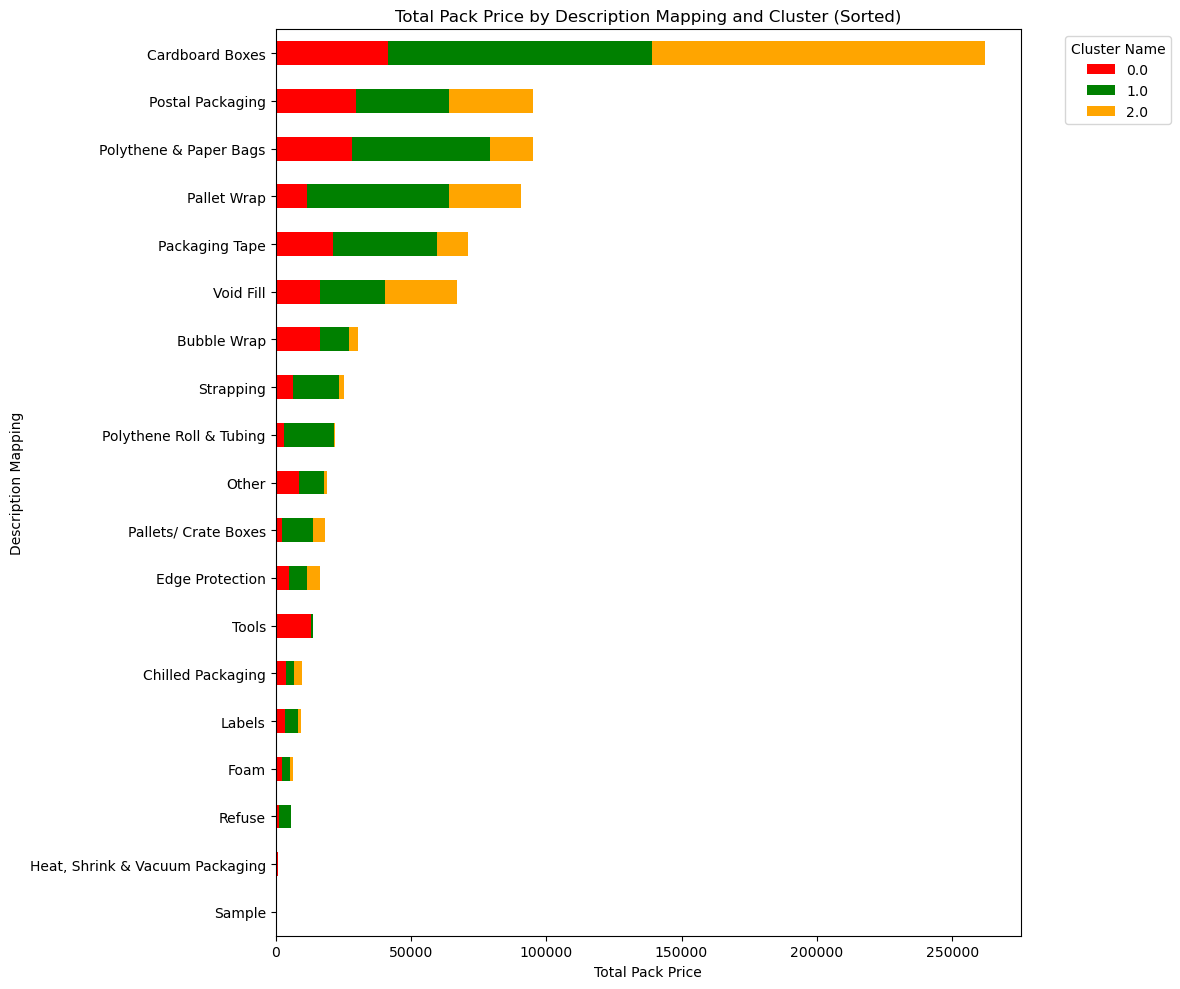

In [94]:
# Group by 'description_mapping' and 'cluster_name_mapping' and sum 'total_pack_price'
pivot_data = orders_details_50miles.pivot_table(
    values='total_pack_price',
    index='description_mapping',
    columns='orders_cluster_consol',
    aggfunc='sum',
    fill_value=0
)

# Add a column to sum total values for sorting purposes
pivot_data['Total'] = pivot_data.sum(axis=1)

# Sort by the 'Total' column in descending order
pivot_data = pivot_data.sort_values(by='Total', ascending=True)

# Drop the 'Total' column after sorting
pivot_data = pivot_data.drop(columns='Total')

# Define custom colors for clusters
cluster_colors = {
    0: 'red',
    1: 'green',
    2: 'orange'
}

# Apply the custom colors to the plot based on column names (cluster labels)
colors = [cluster_colors.get(col, 'gray') for col in pivot_data.columns]

# Plot a horizontal stacked bar chart with custom colors
pivot_data.plot(kind='barh', stacked=True, figsize=(12, 10), color=colors)

# Add titles and labels
plt.title('Total Pack Price by Description Mapping and Cluster (Sorted)')
plt.ylabel('Description Mapping')
plt.xlabel('Total Pack Price')
plt.legend(title='Cluster Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

In [95]:
# Save DataFrame as csv.
orders_details_50miles.to_csv('order_details_mapped_50m.csv')

>**Conclusion:** \
> **Cluster 1: Moderate volume and pallet usage, above average value/order:** Will be selected for testing through the route optimisation calculation.\
> **Cluster 2: Low volume, High pallet usage & value/order:** Should be considered on days where there is excess capacity but limited driver time available as these orders yield high revenue per order.

# 6. Explore other radii at high-level
- using same methodology, run a test in the route optimisation for 100 miles and 25 miles to see if the same metrics produce profitable results.

## a) 100 miles

In [96]:
# Create a df for 50 miles only
orders_100m = orders_df2[orders_df2['distance_miles'] <= 100].reset_index(drop=True)

#View dateframe
print(f"The dataset has {orders_100m.shape[0]} rows and {orders_100m.shape[1]} columns.")
orders_100m.head()

The dataset has 12610 rows and 17 columns.


,order_id,website_id,order_date,date_despatched,courier,products_price,delivery_price,total_price,delivery_cost,total_cubic_m,pallet_space,line_weight_recalc,delivery_postcode,distance_miles,latitude,longitude,day_of_week
0,2729774,889210,2024-06-03,2024-06-03,DX Freight,351.07,19.99,371.06,25.33,0.280986,0.397727,54.28,NG11 7,48.507,52.898976,-1.173471,Monday
1,2729778,971176,2024-06-03,2024-06-03,DX Express,45.04,0.00,45.04,6.95,0.070900,0.053084,9.49,SL6 7,84.703,51.524006,-0.729014,Monday
2,2729779,967968,2024-06-03,2024-06-03,DX Freight,85.70,19.99,105.69,14.14,0.369499,0.345906,22.88,E5 9,94.973,51.559275,-0.053612,Monday
3,2729781,734698,2024-06-03,2024-06-03,DX Freight,110.63,0.00,110.63,11.62,0.470920,0.279053,20.88,LN8 5,94.783,53.374901,-0.325718,Monday
4,2729782,948543,2024-06-03,2024-06-04,MFS,410.74,0.00,410.74,34.58,0.553000,0.420000,178.20,NW10 0,90.091,51.541227,-0.248166,Tuesday


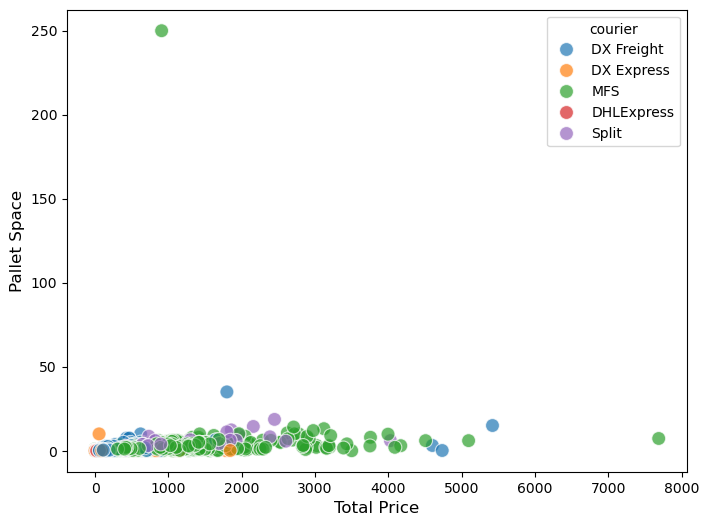

In [97]:
#Set the figure size to make the plot bigger
plt.figure(figsize=(8, 6))

#Determine dataframe
df = orders_100m

# Create scatterplot with Seaborn
sns.scatterplot(x='total_price', 
                y='pallet_space', 
                data=df,
                hue='courier', 
                s=100,   
                alpha=0.7,
               ) 

# Add titles and labels.
plt.title('', fontsize=16)
plt.xlabel('Total Price', fontsize=12)
plt.ylabel('Pallet Space', fontsize=12)

# Show the plot
plt.show()

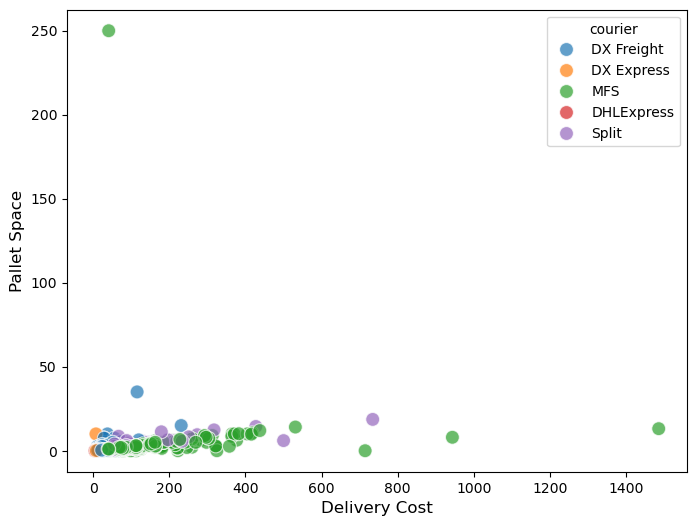

In [98]:
#Set the figure size to make the plot bigger
plt.figure(figsize=(8, 6))

# Create scatterplot with Seaborn
sns.scatterplot(x='delivery_cost', 
                y='pallet_space', 
                data=orders_100m,
                hue='courier', 
                s=100,   
                alpha=0.7,
               ) 

# Add titles and labels.
plt.title('', fontsize=16)
plt.xlabel('Delivery Cost', fontsize=12)
plt.ylabel('Pallet Space', fontsize=12)

# Show the plot
plt.show()

In [99]:
# Remove rows where x_column or y_column has values above/below certain thresholds
orders_100m = orders_100m[(orders_100m['pallet_space'] < 200) 
                                & (orders_100m['delivery_cost'] < 1400)
                               ]

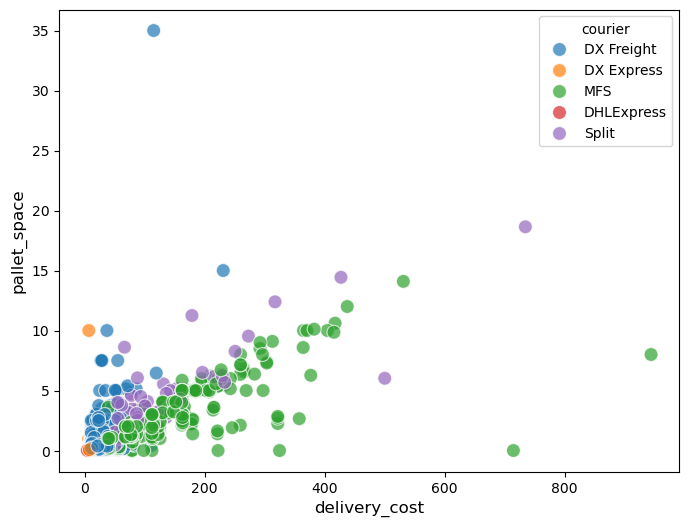

In [100]:
#Set the figure size to make the plot bigger
plt.figure(figsize=(8, 6))

# Create scatterplot with Seaborn
sns.scatterplot(x='delivery_cost', 
                y='pallet_space', 
                data=orders_100m,
                hue='courier', 
                s=100,   
                alpha=0.7,
               ) 

# Add titles and labels.
plt.title('', fontsize=16)
plt.xlabel('delivery_cost', fontsize=12)
plt.ylabel('pallet_space', fontsize=12)

# Show the plot
plt.show()

### K-means clustering for order type

In [101]:
# Make a copy of the full df in case I need to revert back.
df_cost_pallet_100m = orders_100m.copy()

# View df
df_cost_pallet_100m.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12608 entries, 0 to 12609
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            12608 non-null  int64         
 1   website_id          12608 non-null  int64         
 2   order_date          12608 non-null  datetime64[ns]
 3   date_despatched     12608 non-null  datetime64[ns]
 4   courier             12608 non-null  object        
 5   products_price      12608 non-null  float64       
 6   delivery_price      12608 non-null  float64       
 7   total_price         12608 non-null  float64       
 8   delivery_cost       12608 non-null  float64       
 9   total_cubic_m       12608 non-null  float64       
 10  pallet_space        12608 non-null  float64       
 11  line_weight_recalc  12608 non-null  float64       
 12  delivery_postcode   12608 non-null  object        
 13  distance_miles      12608 non-null  float64       


In [102]:
# Keep only necessary columns.
cluster_cost_pallet = df_cost_pallet_100m[['delivery_cost', 'pallet_space']]

#View DataFrame.
cluster_cost_pallet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12608 entries, 0 to 12609
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   delivery_cost  12608 non-null  float64
 1   pallet_space   12608 non-null  float64
dtypes: float64(2)
memory usage: 295.5 KB


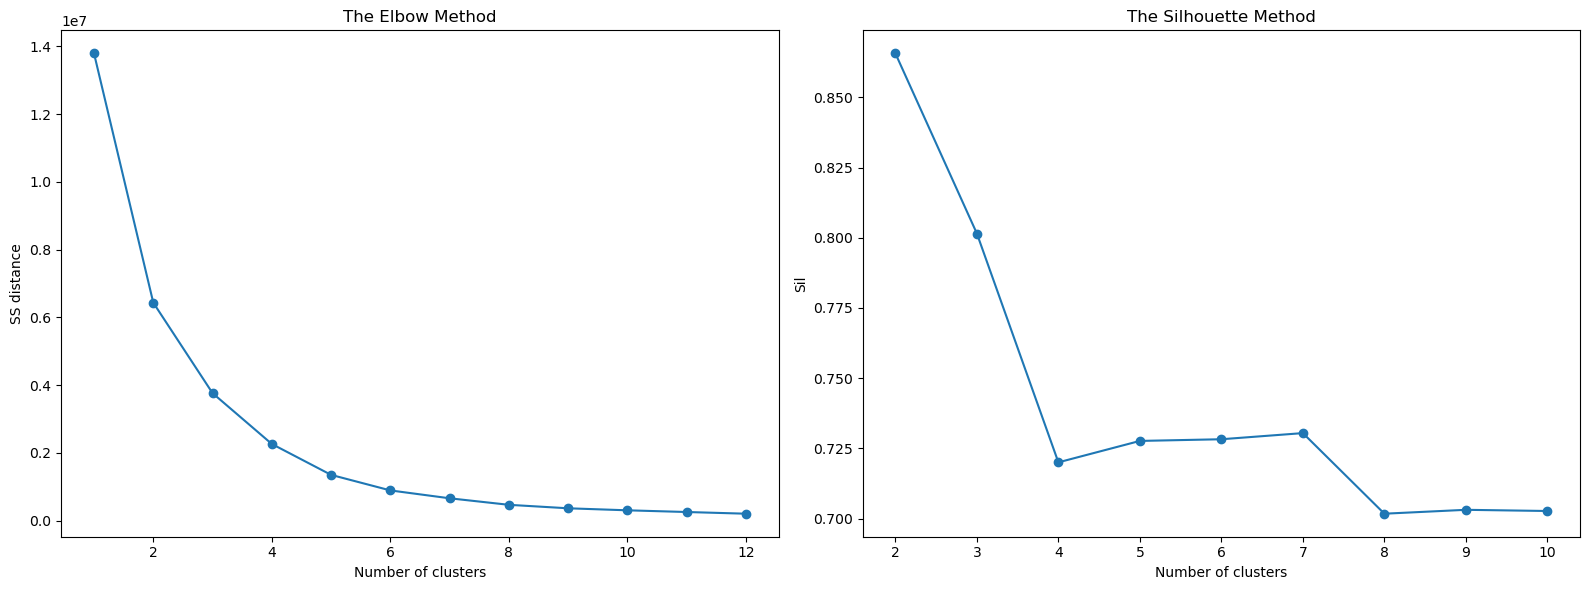

In [103]:
# Set up a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow Method Plot (Left)
ss = []
for i in range(1, 13):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(cluster_cost_pallet)
    ss.append(kmeans.inertia_)

axes[0].plot(range(1, 13), ss, marker='o')
axes[0].set_title("The Elbow Method")
axes[0].set_xlabel("Number of clusters")
axes[0].set_ylabel("SS distance")
# Optionally highlight the optimal k
# axes[0].scatter(8, ss[4], color='red', s=200, edgecolor='black', label='Optimal k=7')

# Silhouette Method Plot (Right)
sil = []
kmax = 10

for k in range(2, kmax + 1):
    kmeans_s = KMeans(n_clusters=k).fit(cluster_cost_pallet)
    labels = kmeans_s.labels_
    sil.append(silhouette_score(cluster_cost_pallet, labels, metric='euclidean'))

axes[1].plot(range(2, kmax + 1), sil, marker='o')
axes[1].set_title("The Silhouette Method")
axes[1].set_xlabel("Number of clusters")
axes[1].set_ylabel("Sil")
# Optionally highlight the optimal k
# axes[1].scatter(5, sil[3], color='red', s=200, edgecolor='black', label='Optimal k=7')

# Adjust layout for spacing
plt.tight_layout()

# Show the plots
plt.show()

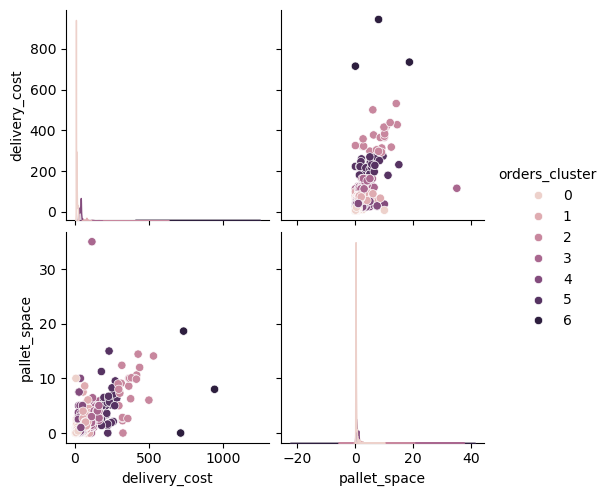

In [104]:
# Use 7 clusters.
kmeans = KMeans(n_clusters = 7, 
                max_iter = 15000,
                init='k-means++',
                random_state=0).fit(cluster_cost_pallet)

clusters = kmeans.labels_

cluster_cost_pallet['orders_cluster'] = clusters

# Plot the predicted.
sns.pairplot(cluster_cost_pallet,
             hue='orders_cluster',
             diag_kind= 'kde')

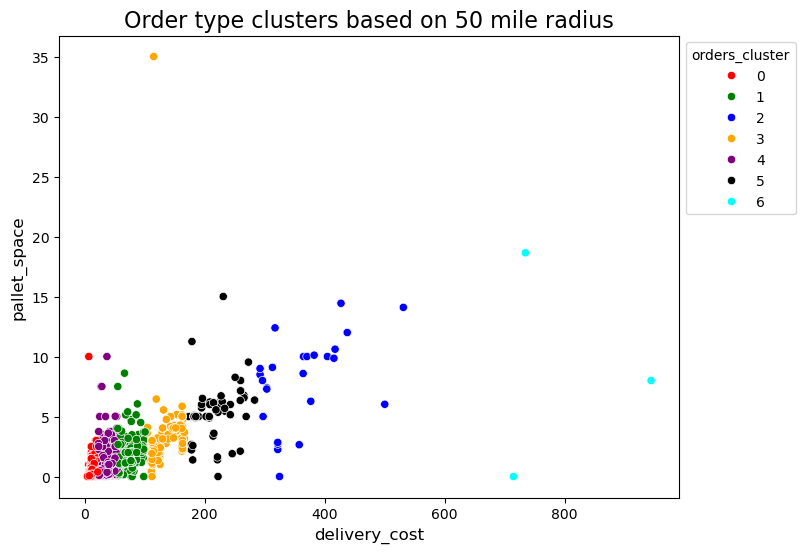

In [105]:
# Visualising the clusters.
plt.figure(figsize=(8, 6))

# Use Seaborn's predefined palette with 8 distinct colors
#palette = sns.color_palette("tab10", 5)

# Create a scatterplot.
sns.scatterplot(x='delivery_cost', 
                y ='pallet_space',
                data=cluster_cost_pallet,
                hue='orders_cluster',
                palette=['red', 'green', 'blue', 'orange', 'purple', 'black', 'cyan' ]
               )

# Add titles and labels to make it clearer
plt.title('Order type clusters based on 50 mile radius', fontsize=16)
plt.xlabel('delivery_cost', fontsize=12)
plt.ylabel('pallet_space', fontsize=12)

# Adjust the legend.
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='orders_cluster') 

# Save the plot as a PNG file
#plt.savefig('Customer clusters3.png', format='png', dpi=300, bbox_inches='tight')

In [106]:
# Add K-means clustering and  to DataFrame.
df_cost_pallet_100m[['orders_cluster']] = cluster_cost_pallet[['orders_cluster']]

# View DataFrame
df_cost_pallet_100m.head()

,order_id,website_id,order_date,date_despatched,courier,products_price,delivery_price,total_price,delivery_cost,total_cubic_m,pallet_space,line_weight_recalc,delivery_postcode,distance_miles,latitude,longitude,day_of_week,orders_cluster
0,2729774,889210,2024-06-03,2024-06-03,DX Freight,351.07,19.99,371.06,25.33,0.280986,0.397727,54.28,NG11 7,48.507,52.898976,-1.173471,Monday,4
1,2729778,971176,2024-06-03,2024-06-03,DX Express,45.04,0.00,45.04,6.95,0.070900,0.053084,9.49,SL6 7,84.703,51.524006,-0.729014,Monday,0
2,2729779,967968,2024-06-03,2024-06-03,DX Freight,85.70,19.99,105.69,14.14,0.369499,0.345906,22.88,E5 9,94.973,51.559275,-0.053612,Monday,0
3,2729781,734698,2024-06-03,2024-06-03,DX Freight,110.63,0.00,110.63,11.62,0.470920,0.279053,20.88,LN8 5,94.783,53.374901,-0.325718,Monday,0
4,2729782,948543,2024-06-03,2024-06-04,MFS,410.74,0.00,410.74,34.58,0.553000,0.420000,178.20,NW10 0,90.091,51.541227,-0.248166,Tuesday,4


In [107]:
# Remove rows where x_column or y_column has values above/below certain thresholds
df_cost_pallet_100m = df_cost_pallet_100m[(df_cost_pallet_100m['pallet_space'] < 30) 
                                #& (df_cost_pallet['delivery_cost'] < 700)
                               ]

#View dataframe
df_cost_pallet_100m.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12607 entries, 0 to 12609
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            12607 non-null  int64         
 1   website_id          12607 non-null  int64         
 2   order_date          12607 non-null  datetime64[ns]
 3   date_despatched     12607 non-null  datetime64[ns]
 4   courier             12607 non-null  object        
 5   products_price      12607 non-null  float64       
 6   delivery_price      12607 non-null  float64       
 7   total_price         12607 non-null  float64       
 8   delivery_cost       12607 non-null  float64       
 9   total_cubic_m       12607 non-null  float64       
 10  pallet_space        12607 non-null  float64       
 11  line_weight_recalc  12607 non-null  float64       
 12  delivery_postcode   12607 non-null  object        
 13  distance_miles      12607 non-null  float64       


In [108]:
# Group by order clusters.
# Assign dataframe.
df = df_cost_pallet_100m

# Key metrics on 100 miles radius.
print("\n=== Key Metrics by order type cluster ===")
cost_pallet_dispatches_100m = df.groupby('orders_cluster').agg(
   order_count=('date_despatched', 'count'),
    price=('total_price', 'sum'),
    delivery_cost=('delivery_cost', 'sum'),
    pallet_space=('pallet_space', 'sum'),
    cost_pc_of_price=('delivery_cost', lambda x: round(
        (x.sum() / df.loc[x.index, 'total_price'].sum()) * 100, 2)
    ),
    rev_per_pallet=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    cost_per_pallet=('delivery_cost', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    rev_per_order=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'date_despatched'].count(), 2)
    )
)

# Format all numeric columns with a thousand separator and two decimal places.
formatted_cost_pallet_dispatches_100m = cost_pallet_dispatches_100m.applymap(
    lambda x: "{:,.2f}".format(x) if isinstance(x, (int, float)) else x)

# Display the formatted DataFrame
formatted_cost_pallet_dispatches_100m


=== Key Metrics by order type cluster ===


,order_count,price,delivery_cost,pallet_space,cost_pc_of_price,rev_per_pallet,cost_per_pallet,rev_per_order
orders_cluster,,,,,,,,
0,"8,375.00","715,377.64","84,277.18","1,393.75",11.78,513.27,60.47,85.42
1,561.00,"346,273.74","41,947.18",912.33,12.11,379.55,45.98,617.24
2,25.00,"61,115.81","9,055.56",199.09,14.82,306.98,45.48,"2,444.63"
3,214.00,"205,287.79","27,517.17",615.44,13.40,333.56,44.71,959.29
4,"3,354.00","1,056,411.09","114,624.95","1,929.24",10.85,547.58,59.41,314.97
5,75.00,"117,983.47","16,059.77",400.50,13.61,294.59,40.10,"1,573.11"
6,3.00,"7,271.25","2,393.06",26.64,32.91,272.92,89.82,"2,423.75"


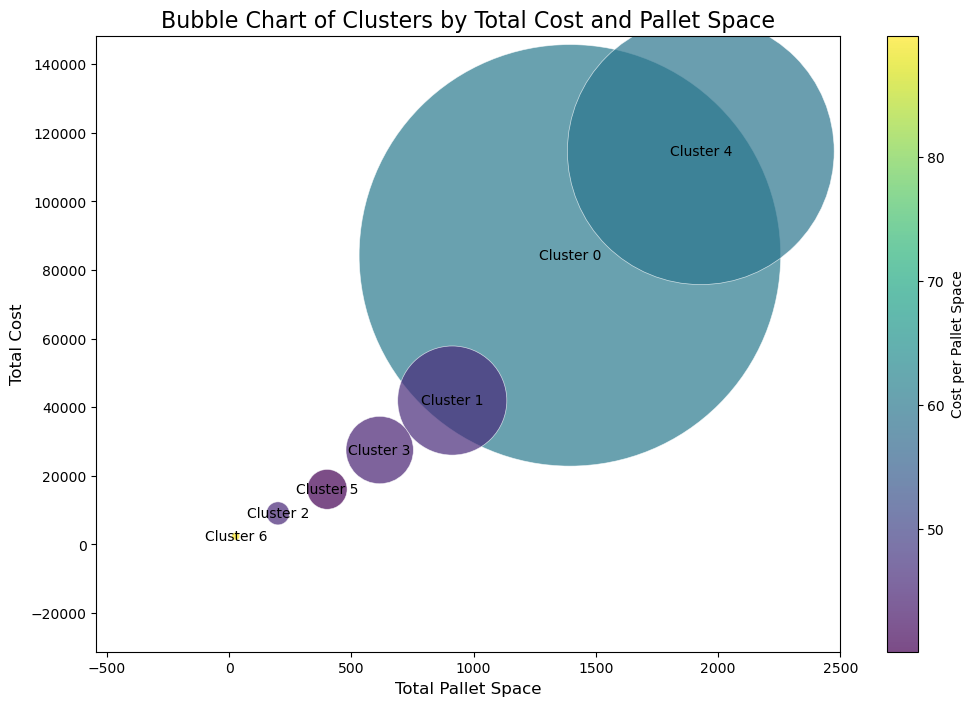

In [109]:
# Set variable
df = cost_pallet_dispatches_100m

# Set up the bubble chart
plt.figure(figsize=(12, 8))
#sns.set(style="whitegrid")

# Bubble chart with Matplotlib scatter plot
bubble_chart = plt.scatter(
    x=df["pallet_space"],
    y=df["delivery_cost"],
    s=df["order_count"] * 11,  # Adjust the size scaling if needed
    c=df["cost_per_pallet"],
    cmap="viridis",
    alpha=0.7,
    edgecolors="w",
    linewidth=0.5
)

# Add color bar to represent cost per pallet space
cbar = plt.colorbar(bubble_chart)
cbar.set_label("Cost per Pallet Space")

# Labeling the chart
plt.xlabel("Total Pallet Space", fontsize=12)
plt.ylabel("Total Cost", fontsize=12)
plt.title("Bubble Chart of Clusters by Total Cost and Pallet Space", fontsize=16)

# Annotate clusters for clarity
for i, row in df.iterrows():
    plt.annotate(f"Cluster {row.name}", (row["pallet_space"], row["delivery_cost"]),
                 ha="center", va="center", fontsize=10, color="black")

# Adds a 10% padding to avoid clipping
plt.margins(0.3) 

# Remove the grid
plt.grid(False)


# Save the plot as an image file
#plt.savefig("bubble_chart_clusters.png", format="png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

In [110]:
# Key metrics on order cluster by percentage.
print("\n=== Key Metrics by order type cluster ===")
summary_metrics_order_100m_plot = df_cost_pallet_100m.groupby('orders_cluster').agg(
    order_count=('date_despatched', 'count'),
    price=('total_price', 'sum'),
    delivery_cost=('delivery_cost', 'sum'),
    pallet_space=('pallet_space', 'sum'),
)

# Calculate percentages.
summary_metrics_order_100m_plot['order%'] = summary_metrics_order_100m_plot['order_count'] / summary_metrics_order_100m_plot['order_count'].sum() * 100
summary_metrics_order_100m_plot['revenue%'] = summary_metrics_order_100m_plot['price'] / summary_metrics_order_100m_plot['price'].sum() * 100
summary_metrics_order_100m_plot['delivery_cost%'] = summary_metrics_order_100m_plot['delivery_cost'] / summary_metrics_order_100m_plot['delivery_cost'].sum() * 100
summary_metrics_order_100m_plot['pallet%'] = summary_metrics_order_100m_plot['pallet_space'] / summary_metrics_order_100m_plot['pallet_space'].sum() * 100


# Display only necessary columns.
summary_metrics_order_100m_plot = summary_metrics_order_100m_plot[['order%', 'revenue%', 'delivery_cost%','pallet%']]


# Sort by count% in ascending order
summary_metrics_order_100m_plot = summary_metrics_order_100m_plot.sort_values(by='order%', ascending=False)

# Print the result
summary_metrics_order_100m_plot


=== Key Metrics by order type cluster ===


,order%,revenue%,delivery_cost%,pallet%
orders_cluster,,,,
0,66.431348,28.504272,28.484062,25.447399
4,26.604267,42.092774,38.741023,35.224401
1,4.449909,13.797301,14.177338,16.657416
3,1.697470,8.179706,9.300273,11.236836
5,0.594908,4.701060,5.427893,7.312473
2,0.198303,2.435164,3.060605,3.635026
6,0.023796,0.289723,0.808808,0.486450


> **Observation:** \
Using the same metrics as before - cluster 4 will be selected for testing.

### K-means clustering for area type

In [111]:
# Keep only necessary columns.
cluster_area = df_cost_pallet_100m[['latitude', 'longitude']]

#View DataFrame
cluster_area.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12607 entries, 0 to 12609
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   12607 non-null  float64
 1   longitude  12607 non-null  float64
dtypes: float64(2)
memory usage: 553.5 KB


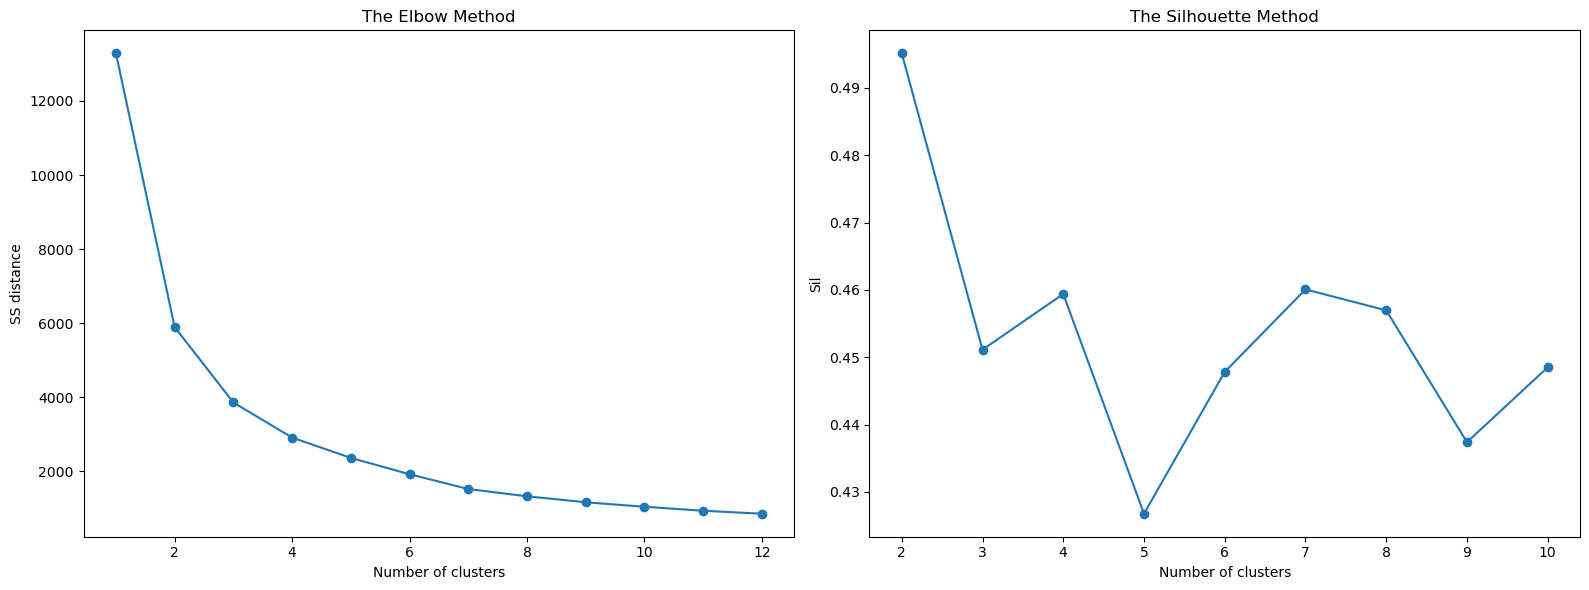

In [112]:
# Set up a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow Method Plot (Left)
ss = []
for i in range(1, 13):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(cluster_area)
    ss.append(kmeans.inertia_)

axes[0].plot(range(1, 13), ss, marker='o')
axes[0].set_title("The Elbow Method")
axes[0].set_xlabel("Number of clusters")
axes[0].set_ylabel("SS distance")
# Optionally highlight the optimal k
# axes[0].scatter(8, ss[4], color='red', s=200, edgecolor='black', label='Optimal k=7')

# Silhouette Method Plot (Right)
sil = []
kmax = 10

for k in range(2, kmax + 1):
    kmeans_s = KMeans(n_clusters=k).fit(cluster_area)
    labels = kmeans_s.labels_
    sil.append(silhouette_score(cluster_area, labels, metric='euclidean'))

axes[1].plot(range(2, kmax + 1), sil, marker='o')
axes[1].set_title("The Silhouette Method")
axes[1].set_xlabel("Number of clusters")
axes[1].set_ylabel("Sil")
# Optionally highlight the optimal k
# axes[1].scatter(5, sil[3], color='red', s=200, edgecolor='black', label='Optimal k=7')

# Adjust layout for spacing
plt.tight_layout()

# Show the plots
plt.show()

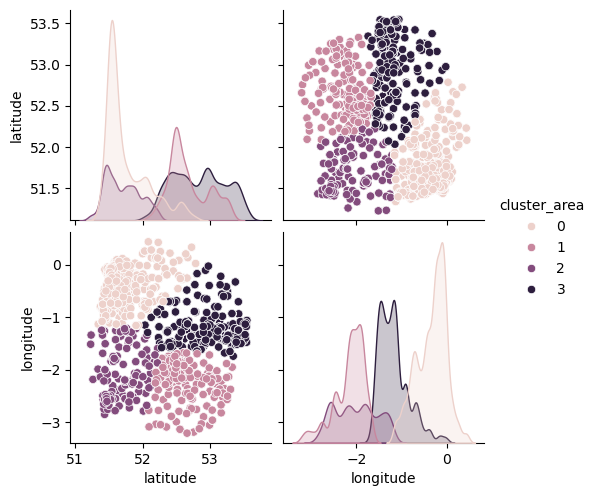

In [113]:
# Use 4 clusters.
kmeans = KMeans(n_clusters = 4, 
                max_iter = 15000,
                init='k-means++',
                random_state=0).fit(cluster_area)

clusters = kmeans.labels_

cluster_area['cluster_area'] = clusters

# Plot the predicted.
sns.pairplot(cluster_area,
             hue='cluster_area',
             diag_kind= 'kde')

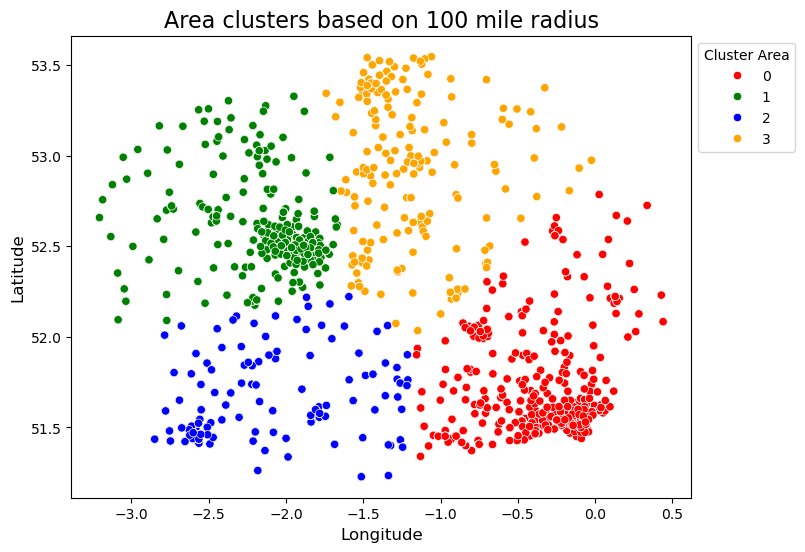

In [114]:
# Visualising the clusters.
plt.figure(figsize=(8, 6))

# Use Seaborn's predefined palette with 8 distinct colors
#palette = sns.color_palette("tab10", 5)

# Create a scatterplot.
sns.scatterplot(x='longitude' , 
                y ='latitude',
                data=cluster_area,
                hue='cluster_area',
                palette=['red', 'green', 'blue', 'orange', 'purple', 'black', 'cyan']
               )

# Add titles and labels to make it clearer
plt.title('Area clusters based on 100 mile radius', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Remove the grid
plt.grid(False)


# Adjust the legend.
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Cluster Area') 

# Save the plot as a PNG file
#plt.savefig('Area cluster.png', format='png', dpi=300, bbox_inches='tight')

In [115]:
# Add K-means clustering and  to DataFrame.
df_cost_pallet_100m[['cluster_area']] = cluster_area[['cluster_area']]

# View DataFrame
df_cost_pallet_100m.head()

,order_id,website_id,order_date,date_despatched,courier,products_price,delivery_price,total_price,delivery_cost,total_cubic_m,pallet_space,line_weight_recalc,delivery_postcode,distance_miles,latitude,longitude,day_of_week,orders_cluster,cluster_area
0,2729774,889210,2024-06-03,2024-06-03,DX Freight,351.07,19.99,371.06,25.33,0.280986,0.397727,54.28,NG11 7,48.507,52.898976,-1.173471,Monday,4,3
1,2729778,971176,2024-06-03,2024-06-03,DX Express,45.04,0.00,45.04,6.95,0.070900,0.053084,9.49,SL6 7,84.703,51.524006,-0.729014,Monday,0,0
2,2729779,967968,2024-06-03,2024-06-03,DX Freight,85.70,19.99,105.69,14.14,0.369499,0.345906,22.88,E5 9,94.973,51.559275,-0.053612,Monday,0,0
3,2729781,734698,2024-06-03,2024-06-03,DX Freight,110.63,0.00,110.63,11.62,0.470920,0.279053,20.88,LN8 5,94.783,53.374901,-0.325718,Monday,0,3
4,2729782,948543,2024-06-03,2024-06-04,MFS,410.74,0.00,410.74,34.58,0.553000,0.420000,178.20,NW10 0,90.091,51.541227,-0.248166,Tuesday,4,0


In [116]:
# Save DataFrame as csv.
df_cost_pallet.to_csv('df_cost_clustering_pallet_100m.csv')

## a) 25 miles

In [117]:
# Create a df for 25 miles only
orders_25m = orders_df2[orders_df2['distance_miles'] <= 25].reset_index(drop=True)

#View dateframe
print(f"The dataset has {orders_25m.shape[0]} rows and {orders_25m.shape[1]} columns.")
orders_25m.head()

The dataset has 971 rows and 17 columns.


,order_id,website_id,order_date,date_despatched,courier,products_price,delivery_price,total_price,delivery_cost,total_cubic_m,pallet_space,line_weight_recalc,delivery_postcode,distance_miles,latitude,longitude,day_of_week
0,2729788,784153,2024-06-03,2024-06-03,DX Freight,146.70,0.00,146.70,22.51,0.270000,0.277778,48.00,CV22 7,10.594,52.358672,-1.277863,Monday
1,2729809,843804,2024-06-03,2024-06-03,MFS,365.72,0.00,365.72,34.58,1.276950,0.938889,179.70,CV6 7,4.969,52.434320,-1.507344,Monday
2,2729832,481958,2024-06-03,2024-06-03,MFS,2853.84,0.00,2853.84,67.73,0.147476,2.000000,1518.00,B46 1,17.113,52.508924,-1.694806,Monday
3,2729843,892015,2024-06-03,2024-06-03,DX Freight,64.35,0.00,64.35,15.25,0.223050,0.200000,29.07,CV10 9,15.807,52.526092,-1.502530,Monday
4,2729870,572938,2024-06-03,2024-06-03,DX Express,33.41,7.37,40.78,6.95,0.089760,0.071429,9.98,CV2 3,6.401,52.424559,-1.463448,Monday


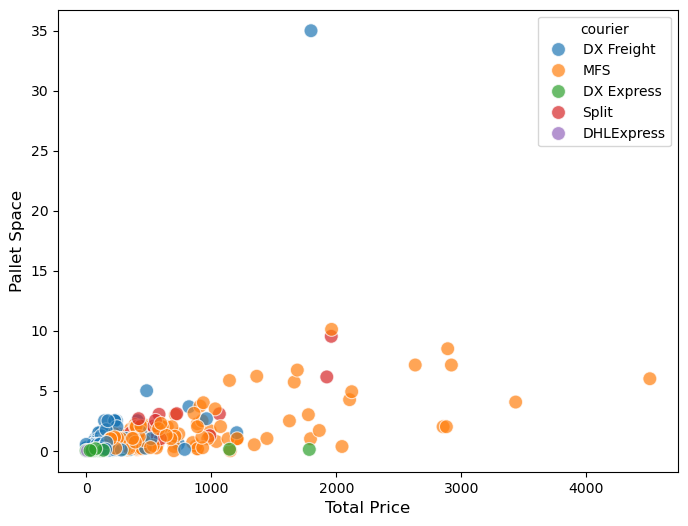

In [118]:
#Set the figure size to make the plot bigger
plt.figure(figsize=(8, 6))

#Determine dataframe
df = orders_25m

# Create scatterplot with Seaborn
sns.scatterplot(x='total_price', 
                y='pallet_space', 
                data=df,
                hue='courier', 
                s=100,   
                alpha=0.7,
               ) 

# Add titles and labels.
plt.title('', fontsize=16)
plt.xlabel('Total Price', fontsize=12)
plt.ylabel('Pallet Space', fontsize=12)

# Show the plot
plt.show()

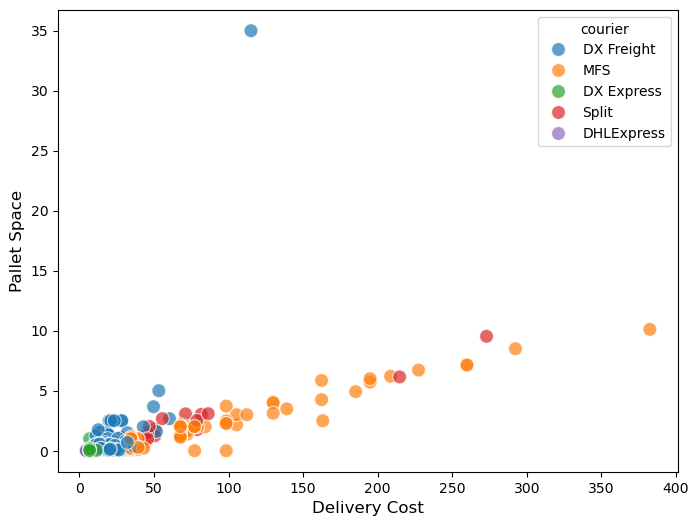

In [119]:
#Set the figure size to make the plot bigger
plt.figure(figsize=(8, 6))

# Create scatterplot with Seaborn
sns.scatterplot(x='delivery_cost', 
                y='pallet_space', 
                data=orders_25m,
                hue='courier', 
                s=100,   
                alpha=0.7,
               ) 

# Add titles and labels.
plt.title('', fontsize=16)
plt.xlabel('Delivery Cost', fontsize=12)
plt.ylabel('Pallet Space', fontsize=12)

# Show the plot
plt.show()

### K-means clustering for order type

In [120]:
# Make a copy of the full df in case I need to revert back.
df_cost_pallet_25m = orders_25m.copy()

# View df
df_cost_pallet_25m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            971 non-null    int64         
 1   website_id          971 non-null    int64         
 2   order_date          971 non-null    datetime64[ns]
 3   date_despatched     971 non-null    datetime64[ns]
 4   courier             971 non-null    object        
 5   products_price      971 non-null    float64       
 6   delivery_price      971 non-null    float64       
 7   total_price         971 non-null    float64       
 8   delivery_cost       971 non-null    float64       
 9   total_cubic_m       971 non-null    float64       
 10  pallet_space        971 non-null    float64       
 11  line_weight_recalc  971 non-null    float64       
 12  delivery_postcode   971 non-null    object        
 13  distance_miles      971 non-null    float64       

In [121]:
# Keep only necessary columns.
cluster_cost_pallet = df_cost_pallet_25m[['delivery_cost', 'pallet_space']]

#View DataFrame.
cluster_cost_pallet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   delivery_cost  971 non-null    float64
 1   pallet_space   971 non-null    float64
dtypes: float64(2)
memory usage: 15.3 KB


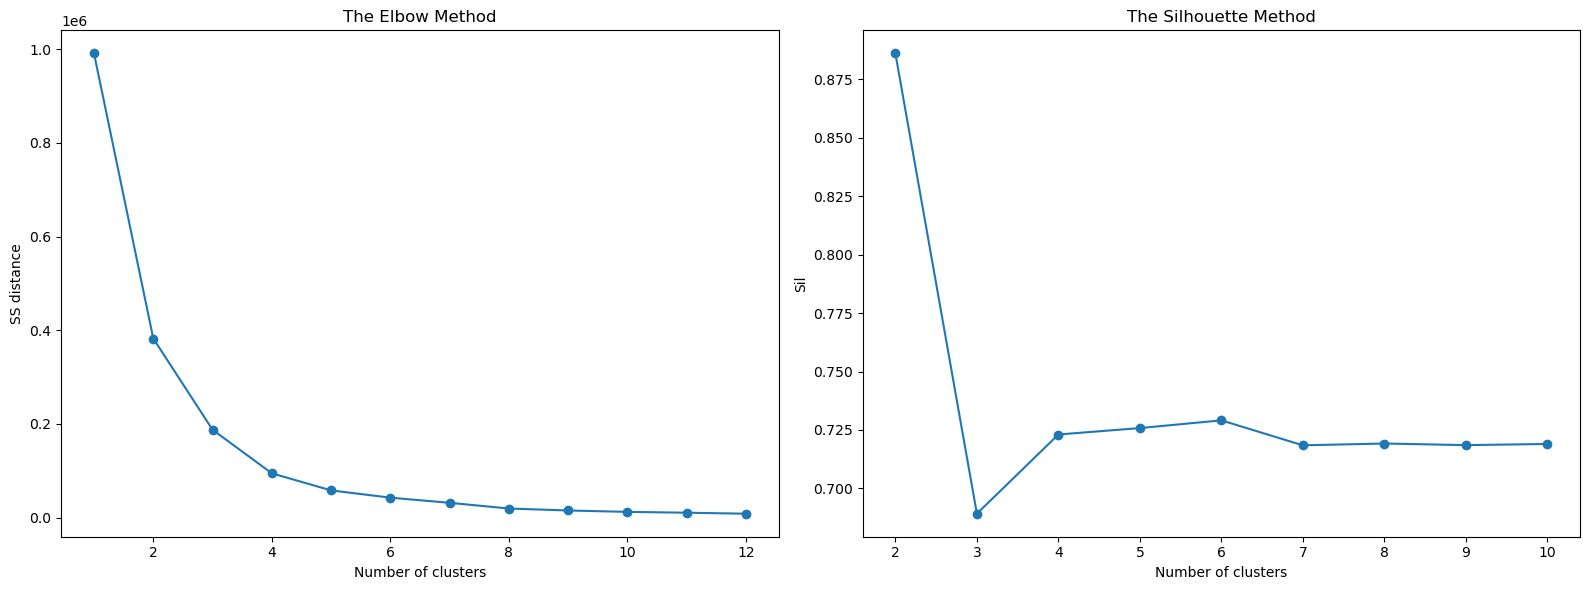

In [122]:
# Set up a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow Method Plot (Left)
ss = []
for i in range(1, 13):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(cluster_cost_pallet)
    ss.append(kmeans.inertia_)

axes[0].plot(range(1, 13), ss, marker='o')
axes[0].set_title("The Elbow Method")
axes[0].set_xlabel("Number of clusters")
axes[0].set_ylabel("SS distance")
# Optionally highlight the optimal k
# axes[0].scatter(8, ss[4], color='red', s=200, edgecolor='black', label='Optimal k=7')

# Silhouette Method Plot (Right)
sil = []
kmax = 10

for k in range(2, kmax + 1):
    kmeans_s = KMeans(n_clusters=k).fit(cluster_cost_pallet)
    labels = kmeans_s.labels_
    sil.append(silhouette_score(cluster_cost_pallet, labels, metric='euclidean'))

axes[1].plot(range(2, kmax + 1), sil, marker='o')
axes[1].set_title("The Silhouette Method")
axes[1].set_xlabel("Number of clusters")
axes[1].set_ylabel("Sil")
# Optionally highlight the optimal k
# axes[1].scatter(5, sil[3], color='red', s=200, edgecolor='black', label='Optimal k=7')

# Adjust layout for spacing
plt.tight_layout()

# Show the plots
plt.show()

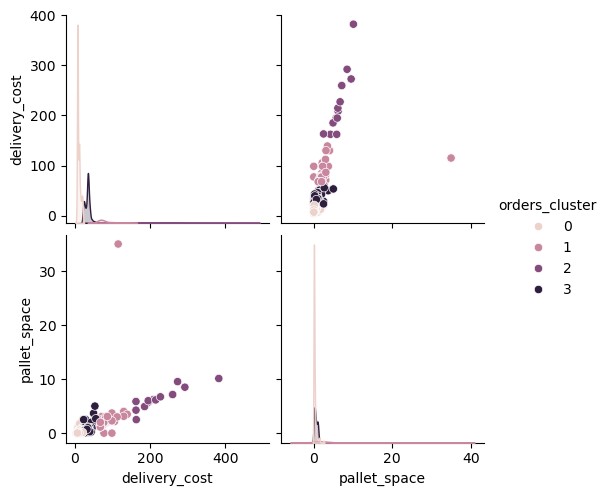

In [123]:
# Use 7 clusters.
kmeans = KMeans(n_clusters = 4, 
                max_iter = 15000,
                init='k-means++',
                random_state=0).fit(cluster_cost_pallet)

clusters = kmeans.labels_

cluster_cost_pallet['orders_cluster'] = clusters

# Plot the predicted.
sns.pairplot(cluster_cost_pallet,
             hue='orders_cluster',
             diag_kind= 'kde')

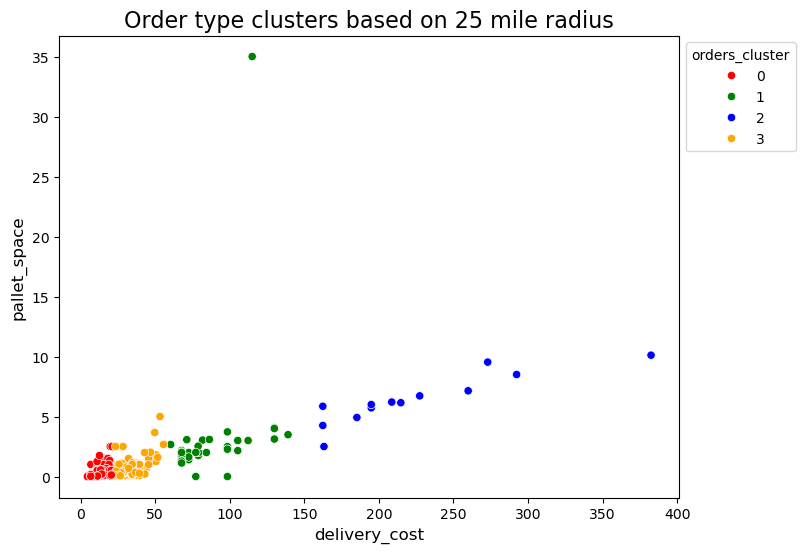

In [124]:
# Visualising the clusters.
plt.figure(figsize=(8, 6))

# Use Seaborn's predefined palette with 8 distinct colors
#palette = sns.color_palette("tab10", 5)

# Create a scatterplot.
sns.scatterplot(x='delivery_cost', 
                y ='pallet_space',
                data=cluster_cost_pallet,
                hue='orders_cluster',
                palette=['red', 'green', 'blue', 'orange', 'purple', 'black', 'cyan' ]
               )

# Add titles and labels to make it clearer
plt.title('Order type clusters based on 25 mile radius', fontsize=16)
plt.xlabel('delivery_cost', fontsize=12)
plt.ylabel('pallet_space', fontsize=12)

# Adjust the legend.
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='orders_cluster') 

# Save the plot as a PNG file
#plt.savefig('Customer clusters3.png', format='png', dpi=300, bbox_inches='tight')

In [125]:
# Add K-means clustering and  to DataFrame.
df_cost_pallet_25m[['orders_cluster']] = cluster_cost_pallet[['orders_cluster']]

# View DataFrame
df_cost_pallet_25m.head()

,order_id,website_id,order_date,date_despatched,courier,products_price,delivery_price,total_price,delivery_cost,total_cubic_m,pallet_space,line_weight_recalc,delivery_postcode,distance_miles,latitude,longitude,day_of_week,orders_cluster
0,2729788,784153,2024-06-03,2024-06-03,DX Freight,146.70,0.00,146.70,22.51,0.270000,0.277778,48.00,CV22 7,10.594,52.358672,-1.277863,Monday,3
1,2729809,843804,2024-06-03,2024-06-03,MFS,365.72,0.00,365.72,34.58,1.276950,0.938889,179.70,CV6 7,4.969,52.434320,-1.507344,Monday,3
2,2729832,481958,2024-06-03,2024-06-03,MFS,2853.84,0.00,2853.84,67.73,0.147476,2.000000,1518.00,B46 1,17.113,52.508924,-1.694806,Monday,1
3,2729843,892015,2024-06-03,2024-06-03,DX Freight,64.35,0.00,64.35,15.25,0.223050,0.200000,29.07,CV10 9,15.807,52.526092,-1.502530,Monday,0
4,2729870,572938,2024-06-03,2024-06-03,DX Express,33.41,7.37,40.78,6.95,0.089760,0.071429,9.98,CV2 3,6.401,52.424559,-1.463448,Monday,0


In [126]:
# Remove rows where x_column or y_column has values above/below certain thresholds
df_cost_pallet_25m = df_cost_pallet_25m[(df_cost_pallet_25m['pallet_space'] < 30) 
                                #& (df_cost_pallet['delivery_cost'] < 700)
                               ]

#View dataframe
df_cost_pallet_25m.info()

<class 'pandas.core.frame.DataFrame'>
Index: 970 entries, 0 to 970
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            970 non-null    int64         
 1   website_id          970 non-null    int64         
 2   order_date          970 non-null    datetime64[ns]
 3   date_despatched     970 non-null    datetime64[ns]
 4   courier             970 non-null    object        
 5   products_price      970 non-null    float64       
 6   delivery_price      970 non-null    float64       
 7   total_price         970 non-null    float64       
 8   delivery_cost       970 non-null    float64       
 9   total_cubic_m       970 non-null    float64       
 10  pallet_space        970 non-null    float64       
 11  line_weight_recalc  970 non-null    float64       
 12  delivery_postcode   970 non-null    object        
 13  distance_miles      970 non-null    float64       
 14 

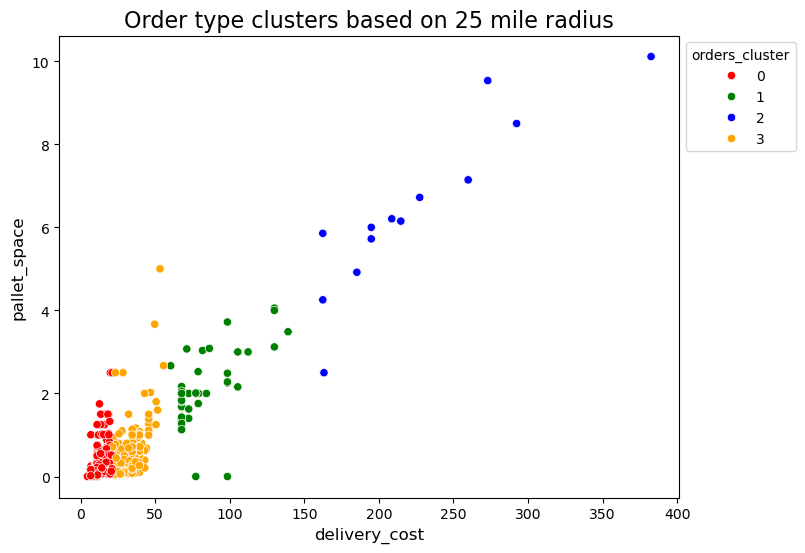

In [127]:
# Visualising the clusters.
plt.figure(figsize=(8, 6))

# Use Seaborn's predefined palette with 8 distinct colors
#palette = sns.color_palette("tab10", 5)

# Create a scatterplot.
sns.scatterplot(x='delivery_cost', 
                y ='pallet_space',
                data=df_cost_pallet_25m,
                hue='orders_cluster',
                palette=['red', 'green', 'blue', 'orange', 'purple', 'black', 'cyan' ]
               )

# Add titles and labels to make it clearer
plt.title('Order type clusters based on 25 mile radius', fontsize=16)
plt.xlabel('delivery_cost', fontsize=12)
plt.ylabel('pallet_space', fontsize=12)

# Adjust the legend.
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='orders_cluster') 

# Save the plot as a PNG file
#plt.savefig('Customer clusters3.png', format='png', dpi=300, bbox_inches='tight')

In [128]:
# Group by order clusters.
# Assign dataframe.
df = df_cost_pallet_25m

# Key metrics on 25 miles radius.
print("\n=== Key Metrics by order type cluster ===")
cost_pallet_dispatches_25m = df.groupby('orders_cluster').agg(
   order_count=('date_despatched', 'count'),
    price=('total_price', 'sum'),
    delivery_cost=('delivery_cost', 'sum'),
    pallet_space=('pallet_space', 'sum'),
    cost_pc_of_price=('delivery_cost', lambda x: round(
        (x.sum() / df.loc[x.index, 'total_price'].sum()) * 100, 2)
    ),
    rev_per_pallet=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    cost_per_pallet=('delivery_cost', lambda x: round(
        x.sum() / df.loc[x.index, 'pallet_space'].sum(), 2)
    ),
    rev_per_order=('total_price', lambda x: round(
        x.sum() / df.loc[x.index, 'date_despatched'].count(), 2)
    )
)

# Format all numeric columns with a thousand separator and two decimal places.
formatted_cost_pallet_dispatches_25m = cost_pallet_dispatches_25m.applymap(
    lambda x: "{:,.2f}".format(x) if isinstance(x, (int, float)) else x)

# Display the formatted DataFrame
formatted_cost_pallet_dispatches_25m


=== Key Metrics by order type cluster ===


,order_count,price,delivery_cost,pallet_space,cost_pc_of_price,rev_per_pallet,cost_per_pallet,rev_per_order
orders_cluster,,,,,,,,
0,596.00,"51,315.20","5,961.11",110.77,11.62,463.25,53.81,86.10
1,55.00,"45,206.88","4,387.98",109.38,9.71,413.30,40.12,821.94
2,14.00,"29,811.40","3,181.13",90.76,10.67,328.47,35.05,"2,129.39"
3,305.00,"95,544.04","9,963.53",175.32,10.43,544.98,56.83,313.26


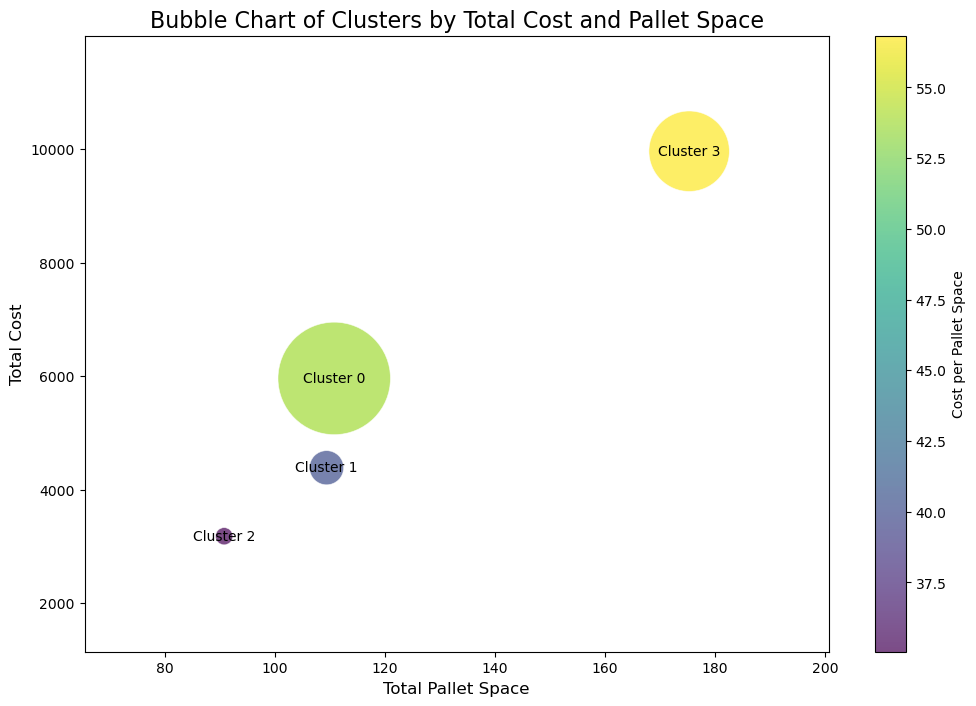

In [129]:
# Set variable
df = cost_pallet_dispatches_25m

# Set up the bubble chart
plt.figure(figsize=(12, 8))
#sns.set(style="whitegrid")

# Bubble chart with Matplotlib scatter plot
bubble_chart = plt.scatter(
    x=df["pallet_space"],
    y=df["delivery_cost"],
    s=df["order_count"] * 11,  # Adjust the size scaling if needed
    c=df["cost_per_pallet"],
    cmap="viridis",
    alpha=0.7,
    edgecolors="w",
    linewidth=0.5
)

# Add color bar to represent cost per pallet space
cbar = plt.colorbar(bubble_chart)
cbar.set_label("Cost per Pallet Space")

# Labeling the chart
plt.xlabel("Total Pallet Space", fontsize=12)
plt.ylabel("Total Cost", fontsize=12)
plt.title("Bubble Chart of Clusters by Total Cost and Pallet Space", fontsize=16)

# Annotate clusters for clarity
for i, row in df.iterrows():
    plt.annotate(f"Cluster {row.name}", (row["pallet_space"], row["delivery_cost"]),
                 ha="center", va="center", fontsize=10, color="black")

# Adds a 10% padding to avoid clipping
plt.margins(0.3) 

# Remove the grid
plt.grid(False)


# Save the plot as an image file
#plt.savefig("bubble_chart_clusters.png", format="png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

In [130]:
# Key metrics on order cluster by percentage.
print("\n=== Key Metrics by order type cluster ===")
summary_metrics_order_25m_plot = df_cost_pallet_25m.groupby('orders_cluster').agg(
    order_count=('date_despatched', 'count'),
    price=('total_price', 'sum'),
    delivery_cost=('delivery_cost', 'sum'),
    pallet_space=('pallet_space', 'sum'),
)

# Calculate percentages.
summary_metrics_order_25m_plot['order%'] = summary_metrics_order_25m_plot['order_count'] / summary_metrics_order_25m_plot['order_count'].sum() * 100
summary_metrics_order_25m_plot['revenue%'] = summary_metrics_order_25m_plot['price'] / summary_metrics_order_25m_plot['price'].sum() * 100
summary_metrics_order_25m_plot['delivery_cost%'] = summary_metrics_order_25m_plot['delivery_cost'] / summary_metrics_order_25m_plot['delivery_cost'].sum() * 100
summary_metrics_order_25m_plot['pallet%'] = summary_metrics_order_25m_plot['pallet_space'] / summary_metrics_order_25m_plot['pallet_space'].sum() * 100


# Display only necessary columns.
summary_metrics_order_25m_plot = summary_metrics_order_25m_plot[['order%', 'revenue%', 'delivery_cost%','pallet%']]


# Sort by count% in ascending order
summary_metrics_order_25m_plot = summary_metrics_order_25m_plot.sort_values(by='order%', ascending=False)

# Print the result
summary_metrics_order_25m_plot


=== Key Metrics by order type cluster ===


,order%,revenue%,delivery_cost%,pallet%
orders_cluster,,,,
0,61.443299,23.127715,25.373174,22.782036
3,31.443299,43.061613,42.409279,36.056573
1,5.670103,20.374700,18.677223,22.495762
2,1.443299,13.435971,13.540325,18.665629


### K-means clustering for area type

In [131]:
# Keep only necessary columns.
cluster_area = df_cost_pallet_25m[['latitude', 'longitude']]

#View DataFrame
cluster_area.info()

<class 'pandas.core.frame.DataFrame'>
Index: 970 entries, 0 to 970
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   970 non-null    float64
 1   longitude  970 non-null    float64
dtypes: float64(2)
memory usage: 55.0 KB


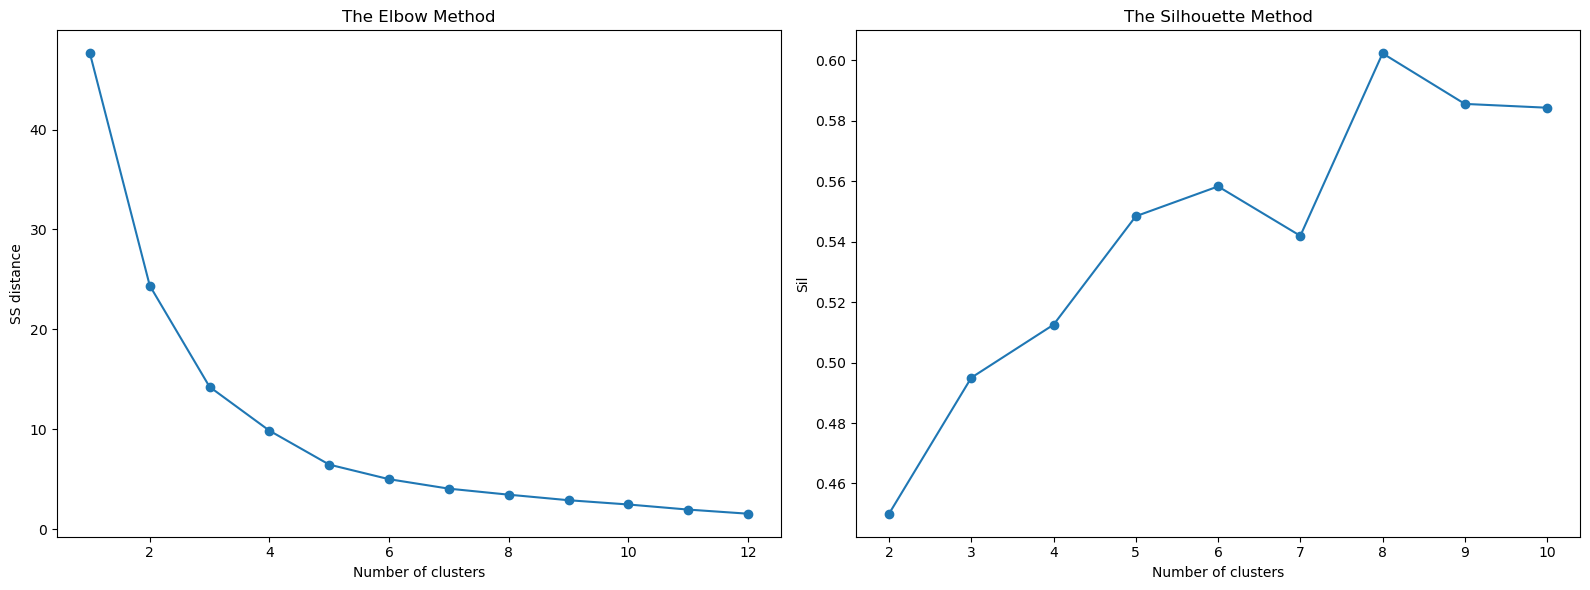

In [132]:
# Set up a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow Method Plot (Left)
ss = []
for i in range(1, 13):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(cluster_area)
    ss.append(kmeans.inertia_)

axes[0].plot(range(1, 13), ss, marker='o')
axes[0].set_title("The Elbow Method")
axes[0].set_xlabel("Number of clusters")
axes[0].set_ylabel("SS distance")
# Optionally highlight the optimal k
# axes[0].scatter(8, ss[4], color='red', s=200, edgecolor='black', label='Optimal k=7')

# Silhouette Method Plot (Right)
sil = []
kmax = 10

for k in range(2, kmax + 1):
    kmeans_s = KMeans(n_clusters=k).fit(cluster_area)
    labels = kmeans_s.labels_
    sil.append(silhouette_score(cluster_area, labels, metric='euclidean'))

axes[1].plot(range(2, kmax + 1), sil, marker='o')
axes[1].set_title("The Silhouette Method")
axes[1].set_xlabel("Number of clusters")
axes[1].set_ylabel("Sil")
# Optionally highlight the optimal k
# axes[1].scatter(5, sil[3], color='red', s=200, edgecolor='black', label='Optimal k=7')

# Adjust layout for spacing
plt.tight_layout()

# Show the plots
plt.show()

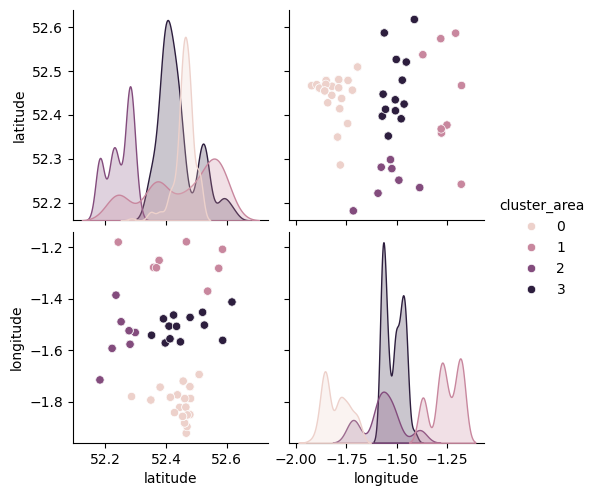

In [133]:
# Use 4 clusters.
kmeans = KMeans(n_clusters = 4, 
                max_iter = 15000,
                init='k-means++',
                random_state=0).fit(cluster_area)

clusters = kmeans.labels_

cluster_area['cluster_area'] = clusters

# Plot the predicted.
sns.pairplot(cluster_area,
             hue='cluster_area',
             diag_kind= 'kde')

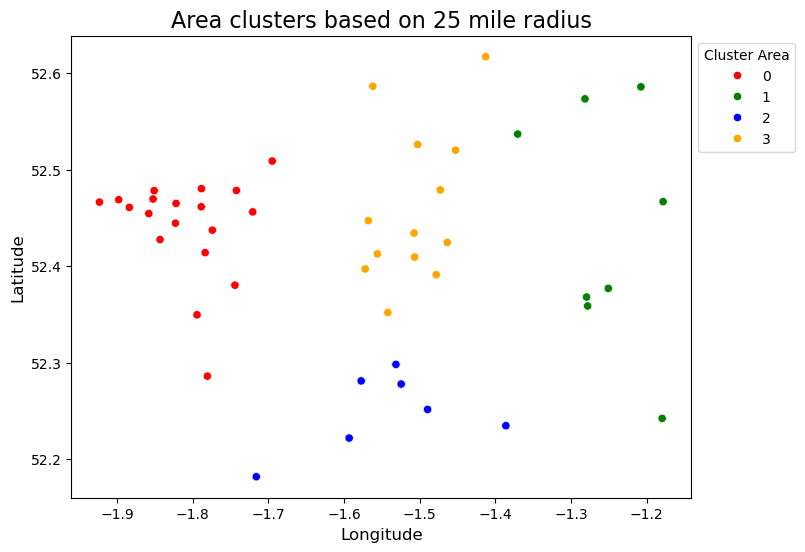

In [134]:
# Visualising the clusters.
plt.figure(figsize=(8, 6))

# Use Seaborn's predefined palette with 8 distinct colors
#palette = sns.color_palette("tab10", 5)

# Create a scatterplot.
sns.scatterplot(x='longitude' , 
                y ='latitude',
                data=cluster_area,
                hue='cluster_area',
                palette=['red', 'green', 'blue', 'orange', 'purple', 'black', 'cyan']
               )

# Add titles and labels to make it clearer
plt.title('Area clusters based on 25 mile radius', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Remove the grid
plt.grid(False)


# Adjust the legend.
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Cluster Area') 

# Save the plot as a PNG file
#plt.savefig('Area cluster.png', format='png', dpi=300, bbox_inches='tight')

In [135]:
# Add K-means clustering and  to DataFrame.
df_cost_pallet_25m[['cluster_area']] = cluster_area[['cluster_area']]

# View DataFrame
df_cost_pallet_25m.head()

,order_id,website_id,order_date,date_despatched,courier,products_price,delivery_price,total_price,delivery_cost,total_cubic_m,pallet_space,line_weight_recalc,delivery_postcode,distance_miles,latitude,longitude,day_of_week,orders_cluster,cluster_area
0,2729788,784153,2024-06-03,2024-06-03,DX Freight,146.70,0.00,146.70,22.51,0.270000,0.277778,48.00,CV22 7,10.594,52.358672,-1.277863,Monday,3,1
1,2729809,843804,2024-06-03,2024-06-03,MFS,365.72,0.00,365.72,34.58,1.276950,0.938889,179.70,CV6 7,4.969,52.434320,-1.507344,Monday,3,3
2,2729832,481958,2024-06-03,2024-06-03,MFS,2853.84,0.00,2853.84,67.73,0.147476,2.000000,1518.00,B46 1,17.113,52.508924,-1.694806,Monday,1,0
3,2729843,892015,2024-06-03,2024-06-03,DX Freight,64.35,0.00,64.35,15.25,0.223050,0.200000,29.07,CV10 9,15.807,52.526092,-1.502530,Monday,0,3
4,2729870,572938,2024-06-03,2024-06-03,DX Express,33.41,7.37,40.78,6.95,0.089760,0.071429,9.98,CV2 3,6.401,52.424559,-1.463448,Monday,0,3


In [136]:
# Save DataFrame as csv.
df_cost_pallet_25m.to_csv('df_cost_clustering_pallet_25m.csv')

>**Observation:** \
> 25 miles radius does not look like a good option. Kept clustering at 4 as the area would be too small if used 7.